# Analysis code for _Intensional Gaps_
# TODO: modify this cell for details about new finite+nonfinite analysis

[Aaron Steven White](http://aaronstevenwhite.io)<br/>
*University of Rochester*<br/>
aaron.white@rochester.edu<br/>
*Last updated*: 8 May 2021

This notebook contains all of the analyses from:

> Kane, Benjamin, William Gantt, and Aaron Steven White. 2021. [Intensional gaps: Relating doxasticity, bouleticity, veridicality, factivity, and neg-raising](https://ling.auf.net/lingbuzz/005930/current.pdf). Accepted to _Semantics and Linguistic Theory_ 31.

If you use any of the code found in this directory, please cite that paper as well as [this repository](https://github.com/MegaAttitude/intensional-gaps.git).

## Notebook Contents

Code relevant to each of the following sections can be jumped to using the links below.

- [Section 3 (Validating a templatic approach)](#Validating-a-templatic-approach)
- [Section 4 (Lexicon-scale data collection)](#Lexicon-scale-data-collection)
- [Section 5 (Discovering inference patterns)](#Discovering-inference-patterns)

These links will not work when viewing this notebook on github.

## Environment Setup

It is strongly recommended that you run this notebook using the docker image it is shipped with. See the README shipped with this notebook for details. The relevant Dockerfile is duplicated below.

```
FROM jupyter/datascience-notebook:r-4.2.3

RUN pip install pyro-ppl==1.8.4 &&\
    R -e "install.packages(c('tidyverse', 'lme4', 'glmmTMB', 'ggrepel'), repos = 'https://cloud.r-project.org')"
```

To run the jupyter notebook server, use:

```bash
docker run -it --rm --user $(id -u):$(id -g) --group-add users -v "$(pwd)":/home/jovyan -p 8888:8888 --name intensional-gaps intensional-gaps
```

Failure to use this docker image could result in minor differences in statistics from the published paper or inability to run the code at all due to API changes.

In [1]:
# base libraries
import os
import re
import json
import pickle

from typing import List, Optional
from warnings import warn
from dataclasses import dataclass
from collections import defaultdict

# numerical computing libraries
import numpy as np
import scipy.stats
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as dist
from torch.utils.data import DataLoader

from numpy.linalg import inv
from numpy import logaddexp
from scipy.special import logsumexp
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster, leaves_list
from scipy.spatial.distance import pdist as pairdist
from sklearn.model_selection import KFold 

# mixture model
import pyro
import pyro.distributions as pdist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.infer.autoguide.initialization import init_to_uniform
from pyro.infer import MCMC, NUTS

# regression, cross-validation, PCA, and CCA
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.cross_decomposition import CCA

# plotting libraries
import seaborn as sns
import rpy2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%load_ext rpy2.ipython

In [2]:
USE_CHECKPOINTS = True
CHECKPOINT_DIR = 'ckpt-sem-syn'
if USE_CHECKPOINTS and not os.path.exists(CHECKPOINT_DIR):
    os.makedirs(CHECKPOINT_DIR)

All the data needed for the analyses in this notebook are downloaded at run time, so an internet connection is also required.

In [3]:
!mkdir -p data
!mkdir -p plots

In cases where values on $[0, 1]$ must be clipped to $(0, 1)$—e.g. for models that use the Beta distribution—we use the following values.

In [4]:
ZERO = 1e-5
ONE = 1 - ZERO
INF = 1e38

In [5]:
project_href = "http://megaattitude.io/projects/mega-intensionality/"

## Lexicon-scale data collection

We collect the MegaIntensionality dataset using the templatic methodology validated above.

In [6]:
bulk1_href = project_href  + 'mega-intensionality-v1/mega-intensionality-v1.tsv'
bulk2_href = 'data/mega-intensionality-nonfinite.tsv'

mc1 = pd.read_csv(bulk1_href, sep='\t')
mc1['participant'] = mc1['participant'].astype('str') + '_1'
mc2 = pd.read_csv(bulk2_href, sep='\t')
mc2['participant'] = mc2['participant'].astype('str') + '_2'

mc = pd.concat([mc1, mc2])
mc_cols = list(mc.columns)
mc_cols_reordered = mc_cols[0:mc_cols.index('target')] + ['target', 'control'] + mc_cols[mc_cols.index('target')+1:-1]
mc = mc[mc_cols_reordered]
mc['participant'] = mc['participant'].astype('category').cat.codes
mc['control'] = mc['control'].fillna('na')

mc

participant antecedent_verb antecedent_polarity   target  control   
0              506         fess_up            negative   object       na  \
1              506        consider            positive  subject       na   
2              506      traumatize            negative  subject       na   
3              506       speculate            positive   object       na   
4              506           blare            positive  subject       na   
...            ...             ...                 ...      ...      ...   
92635          335           cause            negative  subject   object   
92636          335        perceive            positive   object   object   
92637          335           steer            negative   object   object   
92638          335         sign_on            positive  subject  subject   
92639          335         dictate            positive  subject   object   

                 antecedent_frame consequent_verb consequent_embedded_tense   
0      NP V to NP that S[+future]            want                    future  \
1                     NP V that S            want                      past   
2         NP be V that S[+future]         believe                    future   
3      NP V to NP that S[+future]         believe                    future   
4             NP V that S[-tense]            want                    future   
...                           ...             ...                       ...   
92635    NP V NP to VP[+eventive]         believe                    future   
92636    NP V NP to VP[+eventive]          intend                    future   
92637    NP V NP to VP[+eventive]          intend                    future   
92638       NP V to VP[+eventive]          intend                    future   
92639    NP V NP to VP[+eventive]          intend                      past   

                                 antecedent_text   
0      A didn't fess up to B that C would happen  \
1                   A considered that C happened   
2       A wasn't traumatized that C would happen   
3          A speculated to B that C would happen   
4                         A blared that C happen   
...                                          ...   
92635                  A didn't cause B to do C.   
92636                     A perceived B to do C.   
92637                  A didn't steer B to do C.   
92638                       A signed on to do C.   
92639                      A dictated B to do C.   

                                         consequent_text  response  sanity  
0                                   B wanted C to happen      0.38       4  
1                            A wanted C to have happened      0.78       4  
2                         A believed that C would happen      0.67       4  
3                         B believed that C would happen      0.63       4  
4                                   A wanted C to happen      0.86       4  
...                                                  ...       ...     ...  
92635  How likely is it that A believed that B would ...      0.29       4  
92636          How likely is it that B intended to do C?      0.50       4  
92637          How likely is it that B intended to do C?      0.50       4  
92638          How likely is it that A intended to do C?      1.00       4  
92639  How likely is it that A intended for B to have...      1.00       4  

[186080 rows x 12 columns]

To visualize these data, we first derive an aggregate score using a beta mixed model-based normalizer.

In [7]:
def hash_column(col: pd.Series) -> np.array:
    col_as_cat = col.astype('category')
    
    values = torch.tensor(col_as_cat.cat.codes.values).type(torch.long)
    categories = col_as_cat.cat.categories
    
    return values, categories

class UnitNormalizer:
    
    required_columns = ['item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, seed: int = 42):
        self._seed = seed
    
    def _validate_data(self, data: pd.DataFrame) -> None:
        for col in self.required_columns:
            if col not in data.columns:
                raise ValueError(f'"{col}" column is required in {data.name}_data')
                
    def _prepare_data(self, data: pd.DataFrame) -> None:
        self._raw_data = data
        
        self._validate_data(data)

        for col in self.required_columns:
            if col == 'response':
                setattr(self, col, torch.tensor(data[col].values).type(torch.float))
                setattr(self, f'n_{col}', data.shape[0])

            else:
                values, categories = hash_column(data[col])
                setattr(self, col, values)
                setattr(self, f'{col}_categories', categories)
                setattr(self, f'n_{col}', len(categories))
    
    def _init_loc_fn(self, site):        
        return init_to_uniform(site, radius=1e-3)
    
    def _initialize_model(self):
        
        def model(item, participant, response):
            scale = pyro.sample('scale', pdist.Normal(0., self.large_variance))
            
            # Vector of variances for each of the d variables
            theta = pyro.sample("theta", pdist.HalfCauchy(torch.ones(2)).to_event(1))
            # Lower cholesky factor of a correlation matrix
            L_omega = pyro.sample("L_omega", pdist.LKJCorrCholesky(2, 1.0))
            # Lower cholesky factor of the covariance matrix
            participant_scale = torch.mm(theta.sqrt().diag_embed(), L_omega)
            
            with pyro.plate('item_plate', self.n_item):
                locs = pyro.sample('locs', pdist.Normal(0, self.large_variance))
            
            with pyro.plate('participant_plate', self.n_participant):
                locs_scales_participant = pyro.sample('locs_scales_participant',
                                                      pdist.MultivariateNormal(torch.zeros(2),
                                                                              scale_tril=participant_scale))

            with pyro.plate('response_plate', self.n_response):                
                locs = torch.sigmoid(locs[item] + locs_scales_participant[participant, 1])
                scales = torch.square(scale + locs_scales_participant[participant, 0])
                
                concentration1 = scales*locs
                concentration0 = scales*(1.-locs)

                pyro.sample('obs', 
                            pdist.Beta(concentration1.clamp(min=ZERO),
                                      concentration0.clamp(min=ZERO)), 
                            obs=response)
                
                lp = pdist.Beta(concentration1.clamp(min=ZERO), 
                               concentration0.clamp(min=ZERO)).log_prob(response)
                
                return lp
            
        guide = AutoDelta(model, init_loc_fn=self._init_loc_fn)
        
        return model, guide

    def fit(self, data: pd.DataFrame, lr: float = 0.05, tolerance=0.0005, window_size=100,
            iterations: int=1000, verbosity: int=10) -> 'UnitNormalizer':
        pyro.set_rng_seed(self._seed)
        pyro.clear_param_store()
        
        self._prepare_data(data)
        
        optim = pyro.optim.Adam({'lr': lr})
        self._elbo = Trace_ELBO(max_plate_nesting=1)
        
        self._model, self._guide = self._initialize_model()
        
        svi = SVI(self._model, self._guide, optim, loss=self._elbo)
        
        losses = []
         
        like_hist = []
        prev_like_sum = -np.inf
            
        for i in range(iterations):
            
            loss = svi.step(self.item, self.participant, self.response)
            losses.append(loss)
            
            if i and not i % verbosity:
                print('ELBO:', np.round(loss, 2))
        
        return self
    
    def param(self, param_name):
        return pyro.get_param_store()[f'AutoDelta.{param_name}']

In [8]:
mc['item'] = mc.antecedent_verb + '-' + mc.antecedent_polarity + '-' + mc.antecedent_frame + '-' +\
             mc.target + '-' + mc.control + '-' + mc.consequent_verb + '-' + mc.consequent_embedded_tense

mc['response'] = mc.response.map(lambda x: min(x, ONE)).map(lambda x: max(x, ZERO))

if not os.path.isfile('data/mega-intensionality-v2-normalized.tsv'):

    normalizer_checkpoint = f'{CHECKPOINT_DIR}/unit_normalizer.pickle'
    if USE_CHECKPOINTS and os.path.isfile(normalizer_checkpoint):
        print(f'Loading unit normalizer from checkpoint...')
        with open(normalizer_checkpoint, 'rb') as f:
            normalizer = pickle.load(f)

    else:
        normalizer = UnitNormalizer().fit(mc, iterations=50000, lr=0.1, verbosity=5000)

        if USE_CHECKPOINTS:
            with open(normalizer_checkpoint, 'wb') as f:
                pickle.dump(normalizer, f)

The resulting normalized values are made available [here](http://megaattitude.io/projects/mega-intensionality/mega-intensionality-v1/mega-intensionality-v1-normalized.tsv).

In [9]:
if not os.path.isfile('data/mega-intensionality-v2-normalized.tsv'):
    
    keep_cols = ['item', 'antecedent_verb', 'antecedent_polarity', 'antecedent_frame', 
                 'target', 'control', 'consequent_verb', 'consequent_embedded_tense', 'antecedent_text']

    mc_normalized = pd.merge(mc[keep_cols].drop_duplicates().reset_index(drop=True),
                             pd.DataFrame(list(zip(normalizer.item_categories.values, 
                                                   torch.sigmoid(normalizer.param('locs')).data.numpy())), 
                                          columns=['item', 'response_normalized']))

    mc_normalized = mc_normalized.drop(columns='item')

    mc_normalized.sort_values('response_normalized')

    mc_normalized.to_csv('data/mega-intensionality-v2-normalized.tsv', sep='\t', index=False)
    
else:
    mc_normalized = pd.read_csv('data/mega-intensionality-v2-normalized.tsv', sep='\t')

Figure 3 in the paper plots these normalized values.

For passive frames, we set the target (and control, if any) to "object".

In [10]:
passive_frames = ['NP be V that S[+future]',
                  'NP be V that S[-tense]',
                  'NP be V to VP[-eventive]',
                  'NP be V to VP[+eventive]']
mc_normalized.loc[mc_normalized['antecedent_frame'].isin(passive_frames), 'target'] = 'object'
mc_normalized.loc[(mc_normalized['antecedent_frame'].isin(passive_frames) & ~mc_normalized['control'].str.match('na')), 'control'] = 'object'

mc_normalized[mc_normalized['antecedent_frame'].isin(passive_frames)]

antecedent_verb antecedent_polarity          antecedent_frame  target   
2          traumatize            negative   NP be V that S[+future]  object  \
8               wager            positive   NP be V that S[+future]  object   
14         invigorate            positive   NP be V that S[+future]  object   
19            trouble            negative   NP be V that S[+future]  object   
24           reaffirm            negative   NP be V that S[+future]  object   
...               ...                 ...                       ...     ...   
18519        astonish            positive  NP be V to VP[+eventive]  object   
18538        commence            negative  NP be V to VP[+eventive]  object   
18550         suppose            positive  NP be V to VP[+eventive]  object   
18551       chronicle            negative  NP be V to VP[+eventive]  object   
18555          decree            positive  NP be V to VP[+eventive]  object   

      control consequent_verb consequent_embedded_tense   
2          na         believe                    future  \
8          na            want                    future   
14         na         believe                    future   
19         na            want                    future   
24         na         believe                    future   
...       ...             ...                       ...   
18519  object            want                      past   
18538  object            want                    future   
18550  object         believe                    future   
18551  object            want                      past   
18555  object            want                    future   

                                antecedent_text  response_normalized  
2      A wasn't traumatized that C would happen             0.689915  
8             A was wagered that C would happen             0.641786  
14        A was invigorated that C would happen             0.784740  
19        A wasn't troubled that C would happen             0.620065  
24      A wasn't reaffirmed that C would happen             0.382103  
...                                         ...                  ...  
18519                 A was astonished to do C.             0.465766  
18538               A wasn't commenced to do C.             0.350390  
18550                   A was supposed to do C.             0.820552  
18551              A wasn't chronicled to do C.             0.355348  
18555                    A was decreed to do C.             0.639089  

[2328 rows x 9 columns]

In [11]:
mc_normalized_cast = mc_normalized.pivot_table(index=['antecedent_verb', 
                                                      'antecedent_frame', 
                                                      'target',
                                                      'control',
                                                      'consequent_verb', 
                                                      'consequent_embedded_tense'],
                                              columns='antecedent_polarity',
                                              values='response_normalized').reset_index()

mc_normalized_cast_f = mc_normalized_cast[mc_normalized_cast['control'] == 'na']

mc_normalized_cast_nf = mc_normalized_cast[mc_normalized_cast['control'] != 'na']
mc_normalized_cast_nf['target_control'] = mc_normalized_cast_nf['target'] + '-' + mc_normalized_cast_nf['control']

mc_normalized_cast

/tmp/ipykernel_22862/2875580870.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mc_normalized_cast_nf['target_control'] = mc_normalized_cast_nf['target'] + '-' + mc_normalized_cast_nf['control']


antecedent_polarity antecedent_verb       antecedent_frame   target  control   
0                             abhor             NP V VPing  subject  subject  \
1                             abhor             NP V VPing  subject  subject   
2                             abhor             NP V VPing  subject  subject   
3                             abhor             NP V VPing  subject  subject   
4                             abhor             NP V VPing  subject  subject   
...                             ...                    ...      ...      ...   
10549                          yelp      NP V to NP that S  subject       na   
10550                          yelp      NP V to NP that S  subject       na   
10551                          yelp  NP V to VP[+eventive]  subject  subject   
10552                          yelp  NP V to VP[+eventive]  subject  subject   
10553                          yelp  NP V to VP[+eventive]  subject  subject   

antecedent_polarity consequent_verb consequent_embedded_tense  negative   
0                           believe                    future  0.570860  \
1                           believe                      past  0.588933   
2                            intend                    future  0.548834   
3                            intend                      past  0.641596   
4                              want                    future  0.706612   
...                             ...                       ...       ...   
10549                       believe                      past  0.582569   
10550                          want                      past  0.445301   
10551                       believe                    future       NaN   
10552                        intend                    future  0.470776   
10553                          want                    future  0.473735   

antecedent_polarity  positive  
0                    0.266675  
1                    0.384438  
2                    0.159192  
3                    0.341977  
4                    0.066649  
...                       ...  
10549                0.911867  
10550                0.504983  
10551                0.601827  
10552                0.829782  
10553                0.782854  

[10554 rows x 8 columns]

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


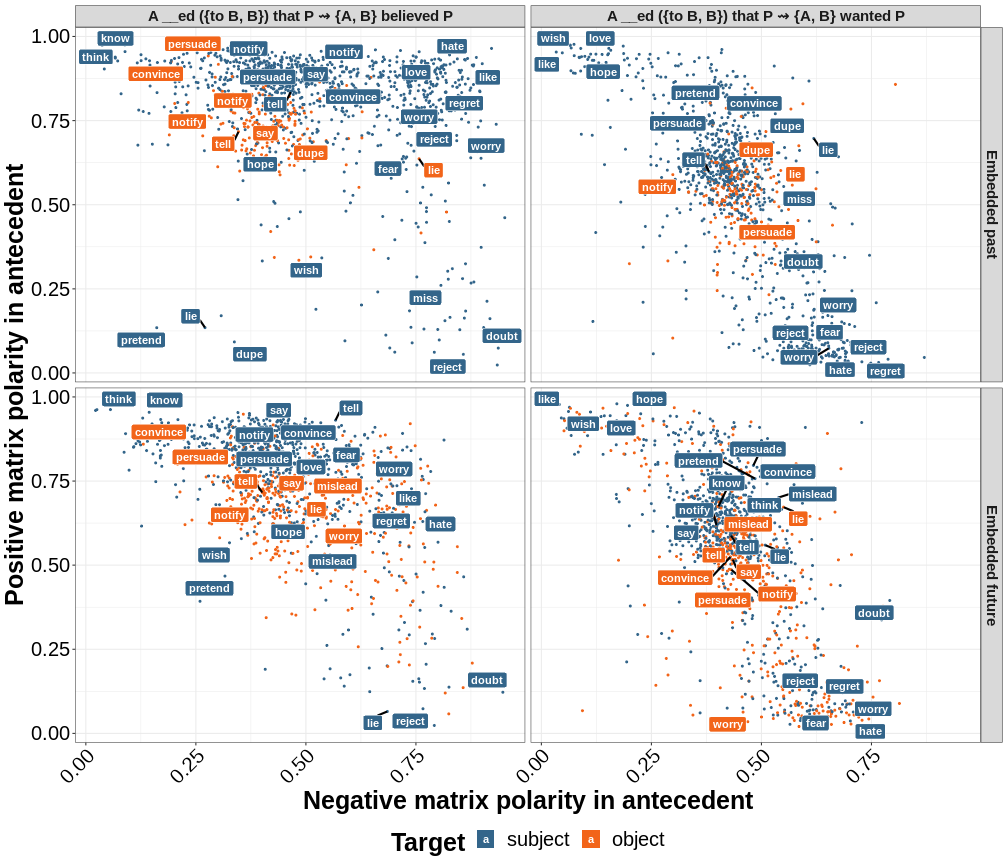

In [12]:
%%R -i mc_normalized_cast_f -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

mc_normalized_cast_f$target <- factor(mc_normalized_cast_f$target, levels=c('subject', 'object'))
mc_normalized_cast_f$consequent_embedded_tense <- factor(mc_normalized_cast_f$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_f = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'reject', 'miss')
transitive_verbs_f = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe')

intransitive_frames_f = c('NP V that S', 'NP be V that S', 
                          'NP V that S[+future]', 'NP be V that S[+future]', 
                          'NP V that S[-tense]', 'NP be V that S[-tense]')
transitive_frames_f = c('NP V to NP that S', 'NP V NP that S',
                        'NP V to NP that S[+future]', 'NP V NP that S[+future]',
                        'NP V to NP that S[-tense]', 'NP V NP that S[-tense]')

g <- ggplot(mc_normalized_cast_f, aes(x=negative, y=positive, color=target)) +
geom_point(size=0.75) +
geom_label_repel(data=filter(mc_normalized_cast_f, 
                       (antecedent_verb%in%intransitive_verbs_f & antecedent_frame %in% intransitive_frames_f) | (antecedent_verb%in%transitive_verbs_f & antecedent_frame %in% transitive_frames_f)), 
           aes(label=antecedent_verb, fill=target), 
           color="white", fontface="bold", segment.color="black", segment.size=1) +
scale_color_manual(name='Target', values=c("#33658a", "#f26419")) +
scale_fill_manual(name='Target',  values=c("#33658a", "#f26419")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) that P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', 'wanted'), 
                            ifelse(consequent_verb=='believe', 'P', 'P'))) +
xlab('Negative matrix polarity in antecedent') +
ylab('Positive matrix polarity in antecedent') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_distributions_finite.png', width=14, height=12)
ggsave('plots/verb_distributions_finite.pdf', width=14, height=12)

g

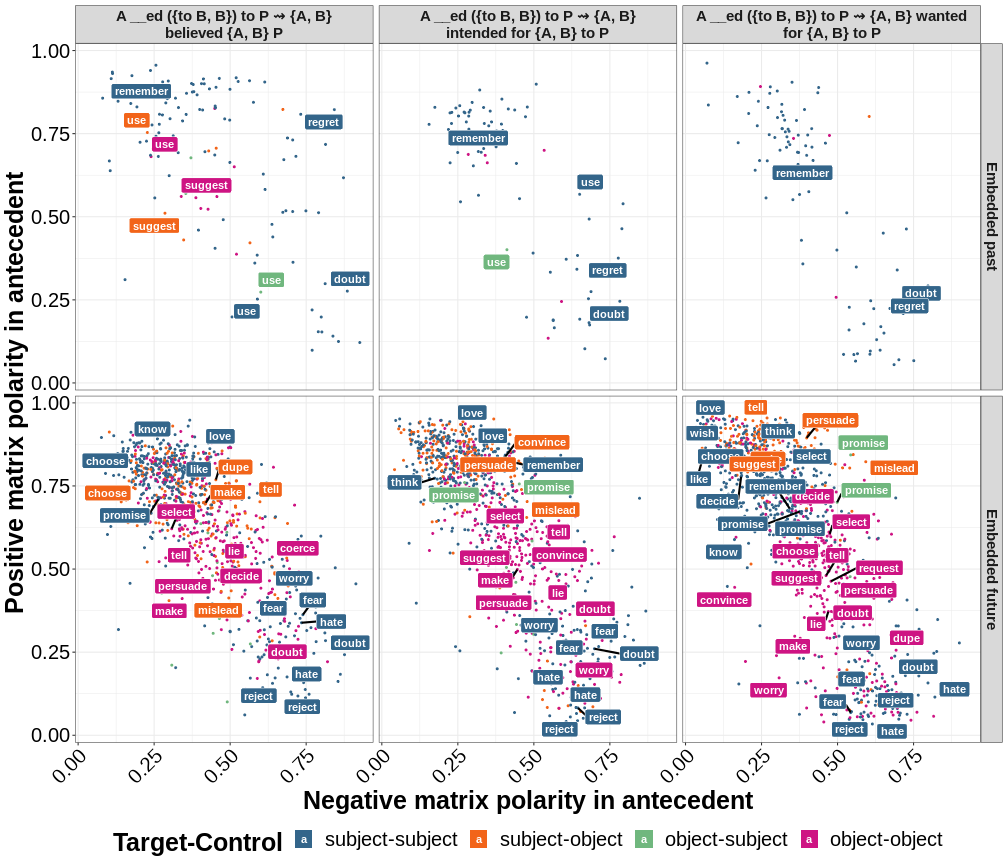

In [13]:
%%R -i mc_normalized_cast_nf -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

conditions = c('subject-subject', 'subject-object', 'object-subject', 'object-object')
mc_normalized_cast_nf$target_control <- factor(mc_normalized_cast_nf$target_control, levels=conditions)
mc_normalized_cast_nf$consequent_embedded_tense <- factor(mc_normalized_cast_nf$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_nf = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'reject', 'miss', 'decide', 'choose', 'select', 'remember')
transitive_verbs_nf = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe', 'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce')

intransitive_frames_nf = c('NP V to VP[-eventive]', 'NP be V to VP[-eventive]',
                           'NP V to VP[+eventive]', 'NP be V to VP[+eventive]',
                           'NP V VPing')
transitive_frames_nf = c('NP V to NP to VP[-eventive]', 'NP V NP to VP[-eventive]',
                         'NP V to NP to VP[+eventive]', 'NP V NP to VP[+eventive]',
                         'NP V NP VP', 'NP V for NP to VP')

sub <- filter(mc_normalized_cast_nf,
              (antecedent_verb%in%intransitive_verbs_nf & antecedent_frame %in% intransitive_frames_nf) | (antecedent_verb%in%transitive_verbs_nf & antecedent_frame %in% transitive_frames_nf))

g <- ggplot(mc_normalized_cast_nf, aes(x=negative, y=positive, color=target_control)) +
geom_point(size=0.75) +
geom_label_repel(data=sub, 
           aes(label=antecedent_verb, fill=target_control), 
           color="white", fontface="bold", segment.color="black", segment.size=1) +
scale_color_manual(name='Target-Control', values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
scale_fill_manual(name='Target-Control',  values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) to P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', ifelse(consequent_verb=='want', 'wanted', 'intended')),
                            ifelse(consequent_verb=='believe', '{A, B} P', ifelse(consequent_verb=='want', 'for {A, B} to P', 'for {A, B} to P'))),
          labeller = label_wrap_gen(width = 40, multi_line = TRUE)) +
xlab('Negative matrix polarity in antecedent') +
ylab('Positive matrix polarity in antecedent') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_distributions_nonfinite.png', width=14, height=12)
ggsave('plots/verb_distributions_nonfinite.pdf', width=14, height=12)

g

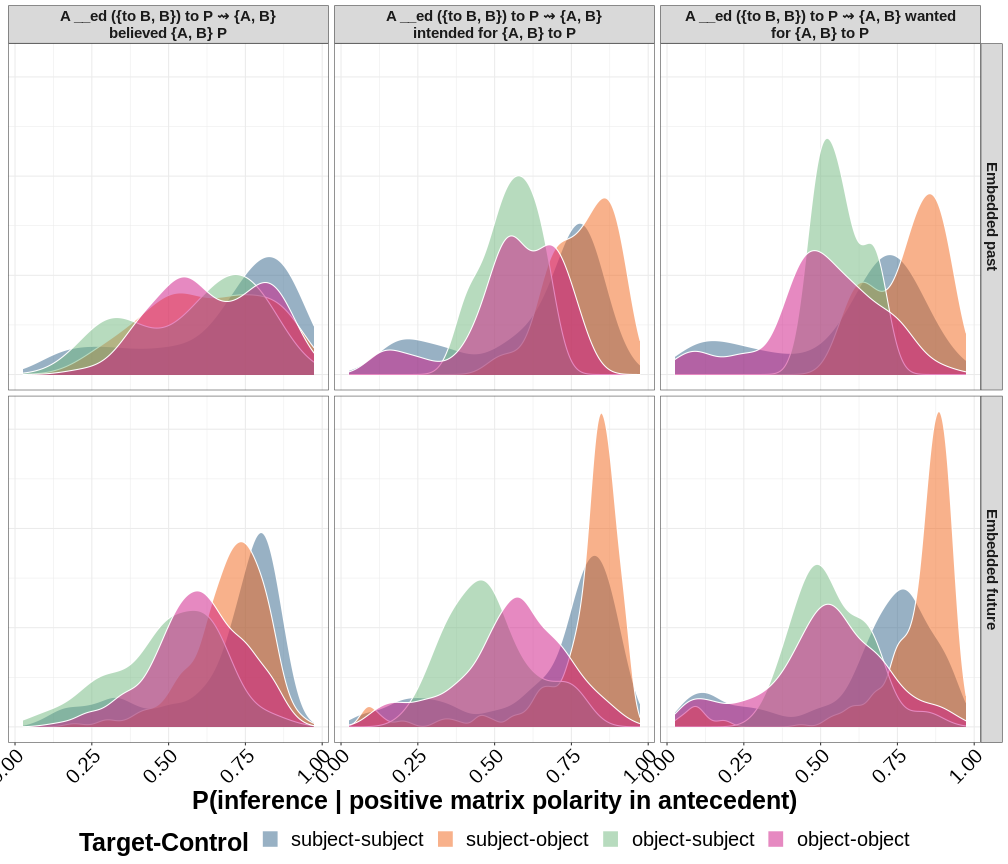

In [14]:
%%R -i mc_normalized_cast_nf -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

conditions = c('subject-subject', 'subject-object', 'object-subject', 'object-object')
mc_normalized_cast_nf$target_control <- factor(mc_normalized_cast_nf$target_control, levels=conditions)
mc_normalized_cast_nf$consequent_embedded_tense <- factor(mc_normalized_cast_nf$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_nf = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'reject', 'miss', 'decide', 'choose', 'select', 'remember')
transitive_verbs_nf = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe', 'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce')

intransitive_frames_nf = c('NP V to VP[-eventive]', 'NP be V to VP[-eventive]',
                           'NP V to VP[+eventive]', 'NP be V to VP[+eventive]',
                           'NP V VPing')
transitive_frames_nf = c('NP V to NP to VP[-eventive]', 'NP V NP to VP[-eventive]',
                         'NP V to NP to VP[+eventive]', 'NP V NP to VP[+eventive]',
                         'NP V NP VP', 'NP V for NP to VP')

sub <- filter(mc_normalized_cast_nf,
              ((antecedent_verb%in%intransitive_verbs_nf & antecedent_frame %in% intransitive_frames_nf) | (antecedent_verb%in%transitive_verbs_nf & antecedent_frame %in% transitive_frames_nf)))
sub$jit <- runif(nrow(sub), 0.25, 8)

g <- ggplot(mc_normalized_cast_nf, aes(x=positive, color=target_control)) +
geom_density(color="white", aes(fill=target_control), alpha=0.5) +
# geom_hline(yintercept=0) +
# geom_segment(data=sub, aes(x=positive, y=jit, xend=positive, yend=rep(0, length(jit)))) +
# geom_label(data=sub, aes(x=positive, y=jit, label=antecedent_verb, fill=target_control), fontface="bold", color="white") +
scale_color_manual(name='Target-Control', values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
scale_fill_manual(name='Target-Control',  values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A __ed ({to B, B}) to P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', ifelse(consequent_verb=='want', 'wanted', 'intended')),
                            ifelse(consequent_verb=='believe', '{A, B} P', ifelse(consequent_verb=='want', 'for {A, B} to P', 'for {A, B} to P'))),
          labeller = label_wrap_gen(width = 40, multi_line = TRUE)) +
xlab('P(inference | positive matrix polarity in antecedent)') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     axis.title.y = element_blank(),
     axis.text.y = element_blank(),
     axis.ticks.y = element_blank(),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_density_nonfinite_positive.png', width=14, height=12)
ggsave('plots/verb_density_nonfinite_positive.pdf', width=14, height=12)

g

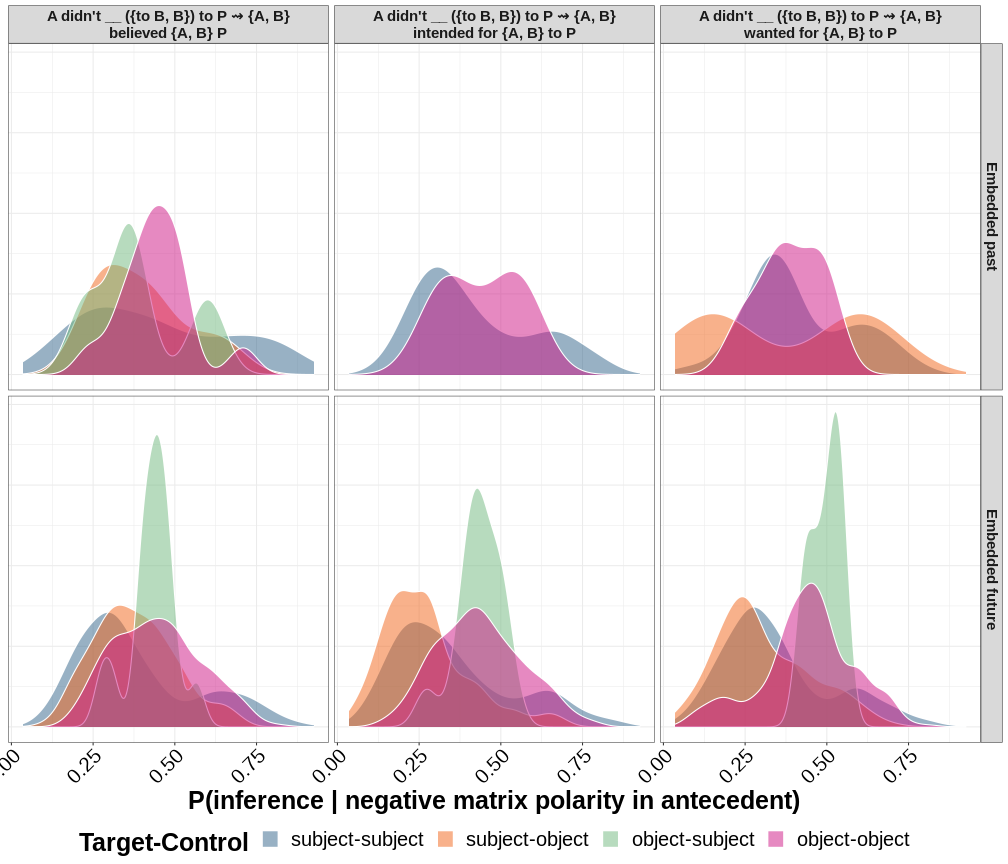

In [15]:
%%R -i mc_normalized_cast_nf -w 14 -h 12 -u in

library(tidyverse)
library(ggrepel)

conditions = c('subject-subject', 'subject-object', 'object-subject', 'object-object')
mc_normalized_cast_nf$target_control <- factor(mc_normalized_cast_nf$target_control, levels=conditions)
mc_normalized_cast_nf$consequent_embedded_tense <- factor(mc_normalized_cast_nf$consequent_embedded_tense, 
                                                       levels=c('past', 'future'))

theme_set(theme_bw())

intransitive_verbs_nf = c('think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'reject', 'miss', 'decide', 'choose', 'select', 'remember')
transitive_verbs_nf = c('say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe', 'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce')

intransitive_frames_nf = c('NP V to VP[-eventive]', 'NP be V to VP[-eventive]',
                           'NP V to VP[+eventive]', 'NP be V to VP[+eventive]',
                           'NP V VPing')
transitive_frames_nf = c('NP V to NP to VP[-eventive]', 'NP V NP to VP[-eventive]',
                         'NP V to NP to VP[+eventive]', 'NP V NP to VP[+eventive]',
                         'NP V NP VP', 'NP V for NP to VP')

sub <- filter(mc_normalized_cast_nf,
              ((antecedent_verb%in%intransitive_verbs_nf & antecedent_frame %in% intransitive_frames_nf) | (antecedent_verb%in%transitive_verbs_nf & antecedent_frame %in% transitive_frames_nf)))
sub$jit <- runif(nrow(sub), 0.25, 8)

g <- ggplot(mc_normalized_cast_nf, aes(x=negative, color=target_control)) +
geom_density(color="white", aes(fill=target_control), alpha=0.5) +
# geom_hline(yintercept=0) +
# geom_segment(data=sub, aes(x=negative, y=jit, xend=negative, yend=rep(0, length(jit)))) +
# geom_label(data=sub, aes(x=negative, y=jit, label=antecedent_verb, fill=target_control), fontface="bold", color="white") +
scale_color_manual(name='Target-Control', values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
scale_fill_manual(name='Target-Control',  values=c("#33658a", "#f26419", "#70B77E", "#CE1483")) +
facet_grid(factor(paste('Embedded', consequent_embedded_tense), levels=c('Embedded past', 'Embedded future')) ~ paste('A didn\'t __ ({to B, B}) to P', sprintf('\u21DD'), '{A, B}', 
                            ifelse(consequent_verb=='believe', 'believed', ifelse(consequent_verb=='want', 'wanted', 'intended')),
                            ifelse(consequent_verb=='believe', '{A, B} P', ifelse(consequent_verb=='want', 'for {A, B} to P', 'for {A, B} to P'))),
          labeller = label_wrap_gen(width = 40, multi_line = TRUE)) +
xlab('P(inference | negative matrix polarity in antecedent)') +
theme(strip.text=element_text(face="bold", size=15),
     axis.title=element_text(face="bold", size=25),
     axis.text=element_text(size=20, color="black"),
     axis.text.x=element_text(angle=45, hjust=1),
     axis.title.y = element_blank(),
     axis.text.y = element_blank(),
     axis.ticks.y = element_blank(),
     legend.position="bottom",
     legend.title=element_text(face="bold", size=25),
     legend.text=element_text(size=20))

ggsave('plots/verb_density_nonfinite_negative.png', width=14, height=12)
ggsave('plots/verb_density_nonfinite_negative.pdf', width=14, height=12)

g

## Discovering inference patterns

We apply a multiview mixed effects mixture model to three inference datasets and one syntactic acceptability dataset simultaneously: MegaIntensionality, MegaVeridicality, MegaNegRaising, and MegaAcceptability, respectively.

For each dataset, we define a `verb` column, which gives the verbs to be clustered, and an `item` column, which gives the dimensions of the cluster centers.

In the case of the inference datasets, we melt the antecedent frames into the `item` columns, so that each inference type is relativized to a particular frame. In the case of MegaAcceptability, the values of the `item` column are the frames. This allows us to cluster both types of datasets by verb using the same model.

For passive frames in the MegaIntensionality dataset, we again set target (and control, if any) to object

In [16]:
mc.loc[mc['antecedent_frame'].isin(passive_frames), 'target'] = 'object'
mc.loc[(mc['antecedent_frame'].isin(passive_frames) & ~mc['control'].str.match('na')), 'control'] = 'object'

mc[mc['antecedent_frame'].isin(passive_frames)]

participant antecedent_verb antecedent_polarity  target control   
2              506      traumatize            negative  object      na  \
8              506           wager            positive  object      na   
14             506      invigorate            positive  object      na   
19             506         trouble            negative  object      na   
24             506        reaffirm            negative  object      na   
...            ...             ...                 ...     ...     ...   
92616          335         suppose            positive  object  object   
92617          335        intrigue            negative  object  object   
92630          335          decree            positive  object  object   
92632          335             aim            positive  object  object   
92633          335       chronicle            negative  object  object   

               antecedent_frame consequent_verb consequent_embedded_tense   
2       NP be V that S[+future]         believe                    future  \
8       NP be V that S[+future]            want                    future   
14      NP be V that S[+future]         believe                    future   
19      NP be V that S[+future]            want                    future   
24      NP be V that S[+future]         believe                    future   
...                         ...             ...                       ...   
92616  NP be V to VP[+eventive]         believe                    future   
92617  NP be V to VP[+eventive]            want                    future   
92630  NP be V to VP[+eventive]            want                    future   
92632  NP be V to VP[+eventive]         believe                    future   
92633  NP be V to VP[+eventive]            want                      past   

                                antecedent_text   
2      A wasn't traumatized that C would happen  \
8             A was wagered that C would happen   
14        A was invigorated that C would happen   
19        A wasn't troubled that C would happen   
24      A wasn't reaffirmed that C would happen   
...                                         ...   
92616                   A was supposed to do C.   
92617               A wasn't intrigued to do C.   
92630                    A was decreed to do C.   
92632                      A was aimed to do C.   
92633              A wasn't chronicled to do C.   

                                         consequent_text  response  sanity   
2                         A believed that C would happen   0.67000       4  \
8                                   A wanted C to happen   0.71000       4   
14                        A believed that C would happen   0.83000       4   
19                                  A wanted C to happen   0.50000       4   
24                        A believed that C would happen   0.34000       4   
...                                                  ...       ...     ...   
92616  How likely is it that A believed that A would ...   0.79000       4   
92617            How likely is it that A wanted to do C?   0.99999       4   
92630            How likely is it that A wanted to do C?   0.52000       4   
92632  How likely is it that A believed that A would ...   0.93000       4   
92633     How likely is it that A wanted to have done C?   0.50000       4   

                                                    item  
2      traumatize-negative-NP be V that S[+future]-su...  
8      wager-positive-NP be V that S[+future]-subject...  
14     invigorate-positive-NP be V that S[+future]-su...  
19     trouble-negative-NP be V that S[+future]-subje...  
24     reaffirm-negative-NP be V that S[+future]-subj...  
...                                                  ...  
92616  suppose-positive-NP be V to VP[+eventive]-subj...  
92617  intrigue-negative-NP be V to VP[+eventive]-sub...  
92630  decree-positive-NP be V to VP[+eventive]-subje...  
92632  aim-positive-NP be V to VP[+eventive]-subject-

In [17]:
mc['verb'] = mc.antecedent_verb

mc['item'] = (mc.antecedent_polarity + '-' +
              mc.target + '-' +
              mc.control + '-' +
              mc.consequent_verb + '-' +
              mc.antecedent_frame)

mc

participant antecedent_verb antecedent_polarity   target  control   
0              506         fess_up            negative   object       na  \
1              506        consider            positive  subject       na   
2              506      traumatize            negative   object       na   
3              506       speculate            positive   object       na   
4              506           blare            positive  subject       na   
...            ...             ...                 ...      ...      ...   
92635          335           cause            negative  subject   object   
92636          335        perceive            positive   object   object   
92637          335           steer            negative   object   object   
92638          335         sign_on            positive  subject  subject   
92639          335         dictate            positive  subject   object   

                 antecedent_frame consequent_verb consequent_embedded_tense   
0      NP V to NP that S[+future]            want                    future  \
1                     NP V that S            want                      past   
2         NP be V that S[+future]         believe                    future   
3      NP V to NP that S[+future]         believe                    future   
4             NP V that S[-tense]            want                    future   
...                           ...             ...                       ...   
92635    NP V NP to VP[+eventive]         believe                    future   
92636    NP V NP to VP[+eventive]          intend                    future   
92637    NP V NP to VP[+eventive]          intend                    future   
92638       NP V to VP[+eventive]          intend                    future   
92639    NP V NP to VP[+eventive]          intend                      past   

                                 antecedent_text   
0      A didn't fess up to B that C would happen  \
1                   A considered that C happened   
2       A wasn't traumatized that C would happen   
3          A speculated to B that C would happen   
4                         A blared that C happen   
...                                          ...   
92635                  A didn't cause B to do C.   
92636                     A perceived B to do C.   
92637                  A didn't steer B to do C.   
92638                       A signed on to do C.   
92639                      A dictated B to do C.   

                                         consequent_text  response  sanity   
0                                   B wanted C to happen   0.38000       4  \
1                            A wanted C to have happened   0.78000       4   
2                         A believed that C would happen   0.67000       4   
3                         B believed that C would happen   0.63000       4   
4                                   A wanted C to happen   0.86000       4   
...                                                  ...       ...     ...   
92635  How likely is it that A believed that B would ...   0.29000       4   
92636          How likely is it that B intended to do C?   0.50000       4   
92637          How likely is it that B intended to do C?   0.50000       4   
92638          How likely is it that A intended to do C?   0.99999       4   
92639  How likely is it that A intended for B to have...   0.99999       4   

                                                    item        verb  
0      negative-object-na-want-NP V to NP that S[+fut...     fess_up  
1                   positive-subject-na-want-NP V that S    consider  
2      negative-object-na-believe-NP be V that S[+fut...  traumatize  
3      positive-object-na-believe-NP V to NP that S[+...   speculate  
4           positive-subject-na-want-NP V that S[-tense]       blare  
...                                                  ...         ...  
92635  negative-subject-object-believe-NP V NP to VP[...       cause  
92636  positive

In addition to MegaIntensionality, we use [MegaVeridicality](http://megaattitude.io/projects/mega-veridicality/), which captures veridicality inferences using 3-way ordinal judgments (_yes_, _maybe or maybe not_, _no_)...

In [18]:
mv = pd.read_csv('http://megaattitude.io/projects/mega-veridicality/mega-veridicality-v2/mega-veridicality-v2.csv')

mv = mv[mv.veridicality.notna()]
mv = mv[mv.nativeenglish]
mv = mv[~mv.conditional]

mv['frame'] = mv.frame + '-' + mv.voice
mv['frame'] = mv.frame.map({'that_S-active': 'NP V that S',
                            'that_S-passive': 'NP be V that S',
                            'to_VPeventive-active': 'NP V to VP[+eventive]',
                            'NP_to_VPeventive-active': 'NP V NP to VP[+eventive]',
                            'to_VPstative-active': 'NP V to VP[-eventive]',
                            'NP_to_VPstative-active': 'NP V NP to VP[-eventive]',
                            'to_VPeventive-passive': 'NP be V to VP[+eventive]',
                            'to_VPstative-passive': 'NP be V to VP[-eventive]',
                            'for_NP_to_VP-active': 'NP V for NP to VP'})

# mv['verb'] = mv.verb

mv['item'] = mv.polarity + '-' + mv.frame

mv['response'] = mv.veridicality.astype(pd.CategoricalDtype(categories=['no', 'maybe', 'yes'])).cat.codes

mv

participant  list  presentationorder       verb   
0              487     0                  1    surmise  \
1              487     0                  2     update   
2              487     0                  3  disregard   
3              487     0                  4      agree   
4              487     0                  5    surmise   
...            ...   ...                ...        ...   
50255          127    81                 53     compel   
50256          127    81                 54    decline   
50257          127    81                 55     advise   
50258          127    81                 56    approve   
50259          127    81                 57       joke   

                          frame    voice  polarity  conditional   
0                   NP V that S   active  positive        False  \
1                   NP V that S   active  positive        False   
2                   NP V that S   active  negative        False   
3                   NP V that S   active  positive        False   
4                   NP V that S   active  negative        False   
...                         ...      ...       ...          ...   
50255  NP V NP to VP[-eventive]   active  negative        False   
50256     NP V to VP[-eventive]   active  negative        False   
50257  NP V NP to VP[+eventive]   active  positive        False   
50258  NP be V to VP[-eventive]  passive  positive        False   
50259     NP V to VP[-eventive]   active  positive        False   

                                                sentence veridicality   
0      Someone surmised that a particular thing happened        maybe  \
1       Someone updated that a particular thing happened          yes   
2      Someone didn\'t disregard that a particular th...        maybe   
3        Someone agreed that a particular thing happened          yes   
4      Someone didn\'t surmise that a particular thin...        maybe   
...                                                  ...          ...   
50255  Someone didn\'t compel a particular person to ...        maybe   
50256  A particular person didn\'t decline to have a ...          yes   
50257  Someone advised a particular person to do a pa...        maybe   
50258  A particular person was approved to have a par...          yes   
50259  A particular person joked to have a particular...          yes   

       acceptability  nativeenglish  exclude   
0                  6           True    False  \
1                  2           True    False   
2                  4           True    False   
3                  4           True    False   
4                  3           True    False   
...              ...            ...      ...   
50255              5           True    False   
50256              6           True    False   
50257              7           True    False   
50258              7           True    False   
50259              6           True    False   

                                    item  response  
0                   positive-NP V that S         1  
1                   positive-NP V that S         2  
2                   negative-NP V that S         1  
3                   positive-NP V that S         2  
4                   negative-NP V that S         1  
...                                  ...       ...  
50255  negative-NP V NP to VP[-eventive]         1  
50256     negative-NP V to VP[-eventive]         2  
50257  positive-NP V NP to VP[+eventive]         1  
50258  positive-NP be V to VP[-eventive]         2  
50259     positive-NP V to VP[-eventive]         2  

[39081 rows x 15 columns]

...and [MegaNegRaising](http://megaattitude.io/projects/mega-negraising), which captures neg-raising inferences using a [0, 1] slider (like MegaIntensionality)...

In [19]:
mn = pd.read_csv('http://megaattitude.io/projects/mega-negraising/mega-negraising-v1/mega-negraising-v1.tsv', sep='\t')

mn = mn[mn.nativeenglish]

# mn['verb'] = mn.verb

mn['item'] = mn.subject + '-' + mn.tense + '-' + mn.frame

mn['response'] = mn.negraising.map(lambda x: min(x, ONE)).map(lambda x: max(x, ZERO))

mn

participant  list  presentationorder   verb                  frame   
0              229    81                  8  abhor            NP V that S  \
1              259    81                 15  abhor            NP V that S   
2              883    81                 14  abhor            NP V that S   
3              665    81                 22  abhor            NP V that S   
4              901    81                 12  abhor            NP V that S   
...            ...   ...                ...    ...                    ...   
79355          723    45                  9   yelp  NP V to VP[+eventive]   
79356          416    45                  2   yelp  NP V to VP[+eventive]   
79357          314    45                 30   yelp  NP V to VP[+eventive]   
79358          939    45                 32   yelp  NP V to VP[+eventive]   
79359          995    45                 29   yelp  NP V to VP[+eventive]   

      tense subject                                          sentence1   
0      past   first   I didn't abhor that a particular thing happened.  \
1      past   first   I didn't abhor that a particular thing happened.   
2      past   first   I didn't abhor that a particular thing happened.   
3      past   first   I didn't abhor that a particular thing happened.   
4      past   first   I didn't abhor that a particular thing happened.   
...     ...     ...                                                ...   
79355  past   third  A particular person didn't yelp to do a partic...   
79356  past   third  A particular person didn't yelp to do a partic...   
79357  past   third  A particular person didn't yelp to do a partic...   
79358  past   third  A particular person didn't yelp to do a partic...   
79359  past   third  A particular person didn't yelp to do a partic...   

                                       sentence2  negraising  acceptability   
0      I abhorred that that thing didn't happen.        0.30           0.97  \
1      I abhorred that that thing didn't happen.        0.09           0.34   
2      I abhorred that that thing didn't happen.        0.50           0.71   
3      I abhorred that that thing didn't happen.        0.00           0.87   
4      I abhorred that that thing didn't happen.        0.33           0.61   
...                                          ...         ...            ...   
79355   That person yelped not to do that thing.        0.23           0.35   
79356   That person yelped not to do that thing.        0.26           0.00   
79357   That person yelped not to do that thing.        0.25           0.41   
79358   That person yelped not to do that thing.        0.82           0.77   
79359   That person yelped not to do that thing.        0.12           0.79   

       nativeenglish                              item  response  
0               True            first-past-NP V that S   0.30000  
1               True            first-past-NP V that S   0.09000  
2               True            first-past-NP V that S   0.50000  
3               True            first-past-NP V that S   0.00001  
4               True            first-past-NP V that S   0.33000  
...              ...                               ...       ...  
79355           True  third-past-NP V to VP[+eventive]   0.23000  
79356           True  third-past-NP V to VP[+eventive]   0.26000  
79357           True  third-past-NP V to VP[+eventive]   0.25000  
79358           True  third-past-NP V to VP[+eventive]   0.82000  
79359           True  third-past-NP V to VP[+eventive]   0.12000  

[78496 rows x 14 columns]

...and [MegaAcceptability](http://megaattitude.io/projects/mega-acceptability/), which captures syntactic acceptability judgments for verbs in particular frames using 7-way ordinal judgments.

In [20]:
ma = pd.read_csv('http://megaattitude.io/projects/mega-acceptability/mega-acceptability-v2/mega-acceptability-v2.tsv', sep='\t')

ma = ma[ma.response.notna()]
ma = ma[ma.nativeenglish]

ma['frame'] = ma.frame.str.replace('Ved', 'V')
ma['frame'] = ma.frame.str.replace('was V', 'be V')

# keep_frames = list(set(list(mc.antecedent_frame.unique()) +
#                        list(mv.frame.unique()) +
#                        list(mn.frame.unique())))
# ma = ma[ma.frame.isin(keep_frames)]

# for x in keep_frames:
#     if x not in ma.frame.unique():
#         print(x)

# # ma['verb'] = ma.verb

ma['item'] = ma.tense + '-' + ma.frame

ma['response'] = ma.response.astype(int)-1

ma

participant  list  presentationorder   verb   frame    tense   
0               192   504                 13  abhor    NP V     past  \
1               638   504                 13  abhor    NP V     past   
2               200   504                 13  abhor    NP V     past   
3               336   504                 13  abhor    NP V     past   
4               339   504                 13  abhor    NP V     past   
...             ...   ...                ...    ...     ...      ...   
374995          297   821                 18   yelp  S, I V  present   
374996          248   821                 18   yelp  S, I V  present   
374997          430   821                 18   yelp  S, I V  present   
374998          557   821                 18   yelp  S, I V  present   
374999          565   821                 18   yelp  S, I V  present   

        response  nativeenglish                     sentence  version   
0              6           True            Someone abhorred.        1  \
1              2           True            Someone abhorred.        1   
2              0           True            Someone abhorred.        1   
3              2           True            Someone abhorred.        1   
4              3           True            Someone abhorred.        1   
...          ...            ...                          ...      ...   
374995         0           True  Something happened, I yelp.        1   
374996         1           True  Something happened, I yelp.        1   
374997         0           True  Something happened, I yelp.        1   
374998         6           True  Something happened, I yelp.        1   
374999         4           True  Something happened, I yelp.        1   

                  item  
0            past-NP V  
1            past-NP V  
2            past-NP V  
3            past-NP V  
4            past-NP V  
...                ...  
374995  present-S, I V  
374996  present-S, I V  
374997  present-S, I V  
374998  present-S, I V  
374999  present-S, I V  

[373440 rows x 11 columns]

### Combining the datasets

To make passing multiple datasets (with metadata) to the mixture model we define below, we use a lightweight dataclass.

In [21]:
@dataclass
class Data:
    dataframe: pd.DataFrame
    name: str
    datatype: str
        
data = [Data(mc, 'belief_desire', 'unit'), 
        Data(mv, 'veridicality', 'ordinal'),
        Data(mn, 'negraising', 'unit'),
        Data(ma, 'acceptability', 'ordinal')]

### KMeans Initialization

In the following cells we define the multiview mixture model, which is initialized using a variant of $k$-means clustering that allows for missing data.

In [22]:
class KMeansWithMissingData:
    """K-Means for data with values missing
    
    Parameters
    ----------
    n_clusters
        The number of clusters.
    init
        How to initialize the model. Must be either "random" (default) 
        or "kmeans++".
    fuzzy_impute
        Whether to use hard (default) or fuzzy imputation when imputing 
        missing values during cluster center updates.
    random_state
        The random seed.
    """
    
    def __init__(self, n_clusters: int = 2, init: str="random", 
                 fuzzy_impute: bool = False, random_state: int = 42):
        self.n_clusters = n_clusters
        self.init_method = init
        self.fuzzy_impute = fuzzy_impute
        self.random_state = random_state
    
    def _initialize_cluster_centers(self):
        self.missing_patterns_, self.pattern_assignments_ = np.unique(self.missing_, 
                                                                      return_inverse=True,
                                                                      axis=0)
        self.observed_patterns_ = ~self.missing_patterns_
        
        self.X_binned_ = [self.X_[self.pattern_assignments_ == i] 
                          for i in range(self.missing_patterns_.shape[0])]
        
        X_synthesized = np.array([np.nanmean([b[np.random.choice(b.shape[0])]
                                              for b in self.X_binned_], axis=0) 
                                  for _ in range(self.X_.shape[0])])
        
        if self.init_method == "kmeans++":
            cluster_centers = np.array([X_synthesized[0]])

            for _ in range(self.n_clusters-1):
                dist = np.square(cluster_centers[:,None,:] -
                                 X_synthesized[None,:,:]).sum(axis=2)
                mindist = dist.min(axis=0)
                prob = mindist/mindist.sum()

                center = X_synthesized[np.random.choice(prob.shape[0], p=prob)]

                cluster_centers = np.concatenate([cluster_centers, [center]], axis=0)
                
        else:
            cluster_centers = X_synthesized[:self.n_clusters]

        self.cluster_centers_ = cluster_centers
    
    def _compute_cluster_assignments(self, X=None, cluster_centers=None):
        self.sqdist_to_center_ = self._compute_distances(X=X,
                                                         cluster_centers=cluster_centers)
        self.cluster_assignments_ = np.argmin(self.sqdist_to_center_, axis=0)
    
    def _compute_distances(self, X=None, cluster_centers=None):
        if X is None:
            X = self.X_
        
        if cluster_centers is None:
            cluster_centers = self.cluster_centers_
        
        return np.nansum(np.square(cluster_centers[:,None,:] - X[None,:,:]), 
                         axis=2)
    
    def _impute(self):
        if self.fuzzy_impute:
            weight = np.exp(-self.sqdist_to_center_)/\
                     np.exp(-self.sqdist_to_center_).sum(axis=0)[None,:]
            
            return np.where(self.missing_, 
                            np.sum(weight[:,:,None]*
                                   self.cluster_centers_[:,None,:], 
                                   axis=0), 
                            self.X_)
        else:
            return np.where(self.missing_, 
                            self.cluster_centers_[self.cluster_assignments_], 
                            self.X_)    
    
    def fit(self, X: np.array, maxiter=1000):
        """Computes a modified version of Lloyd's algorithm

        The main difference between the standard version of Lloyd's algorithm 
        and the one computed here is that, when computing the distance between 
        a point and a cluster center, only the observed values for the point 
        are used; and when updating cluster centers, the missing values for 
        a point are first imputed based either on the current cluster assignment 
        (hard imputation) or as a weighted mean over a softmax on the negative 
        distances.

        Parameters
        ----------
        X
            The points to cluster
        maxiter
            The maximum number of EM iterations
        """
        self.X_ = X
        self.n_samples_, self.n_features_ = self.X_.shape
        
        # find the missing values
        self.missing_ = np.isnan(self.X_)
        self.observed_ = ~self.missing_
        
        # initialize cluster centers
        np.random.seed(self.random_state)
        self._initialize_cluster_centers()
        
        # initialize cluster assignments
        self._compute_cluster_assignments()
        
        for _ in range(maxiter):
            previous_cluster_assignments = self.cluster_assignments_

            # impute missing values based on current assignments
            Ximputed = self._impute()
            
            # update cluster centers
            for i in np.arange(self.n_clusters):
                Ximputed_i = Ximputed[self.cluster_assignments_ == i]
                self.cluster_centers_[i] = np.mean(Ximputed_i, axis=0)
                
            # update cluster assignments
            self._compute_cluster_assignments()
            
            # test change in cluster assignments
            cluster_assignment_unchanged = (previous_cluster_assignments ==
                                            self.cluster_assignments_)

            if cluster_assignment_unchanged.all():
                break
            
        else:
            warn(f'KMeansWithMissingData({self.n_clusters}) did not converge'
                 f' after {maxiter} iterations')
        
        return self
    
    def distances(self, X):
        return self._compute_distances(X=X)
    
    def sse(self, X):
        agg = 0.
        distances = self.distances(X)
        assignments = self.cluster_assignments_
        for c in range(self.n_clusters):
            dc = distances[c][np.where(assignments == c)]
            agg += np.sum(np.square(dc))
        return agg
    
    
def compute_kmeans_best_fit(X: np.array, n_clusters: int = 2,
                            init: str="random", fuzzy_impute: bool = False, random_state: int = 42,
                            maxiter=1000, num_trials=1, verbosity=20):
    """Attempts to fit K-Means `num_trials` times, returning the result with the lowest squared error."""
    min_kmeans = None
    min_sse = np.inf
    np.random.seed(random_state)
    seeds = np.random.randint(0, 10000, size=num_trials)
    for trial in range(num_trials):
        if trial % verbosity == 0:
            print(f'Computing KMeans initialization with minimum squared error; current minimum: {min_sse}')
        kmeans = KMeansWithMissingData(n_clusters=n_clusters, init=init, fuzzy_impute=fuzzy_impute, random_state=seeds[trial])
        kmeans.fit(X, maxiter=maxiter)
        sse = kmeans.sse(X)
        if min_kmeans is None or sse < min_sse:
            min_kmeans = kmeans
            min_sse = sse
    return min_kmeans

### Response Models

Each "view" of the data is modeled using either a unit mixed effects model or an ordinal mixed effects model, depending on the response type of that dataset.

TODO: add descriptions for unit and ordinal models

In [23]:
def truncated_normal_log_prob(x, mu, sigma, a, b):
    """Compute the log-likelihood of `x` from a truncated normal distribution."""
    normal = dist.Normal(mu, sigma)
    return normal.log_prob(x) - torch.log(normal.cdf(torch.tensor(b)) - normal.cdf(torch.tensor(a)))
    

class UnitMixedEffectsModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, name, n_components, n_verb, n_item, n_participant, locs_init=None,
                 large_variance=100, location_variance=1., hyperpriors=False):
        super(UnitMixedEffectsModel, self).__init__()
        
        self.name = name
        self.n_components = n_components
        self.n_verb = n_verb
        self.n_item = n_item
        self.n_participant = n_participant
        
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        self.hyperpriors = hyperpriors

        # hyperparameters
        if self.hyperpriors:
            self.locs_variance = nn.Parameter(torch.empty(1))
            self.locs_participant_variance = nn.Parameter(torch.empty(1))
        
        # parameters
        self.theta = nn.Parameter(torch.empty(3, self.n_components, self.n_item))
        self.theta_participant = nn.Parameter(torch.empty(3, self.n_participant))
        self.locs = nn.Parameter(torch.empty(self.n_components, self.n_item))
        self.locs_participant = nn.Parameter(torch.empty(self.n_participant))

        # initialization
        if self.hyperpriors:
            self._init_uniform(self.locs_variance)
            self._init_uniform(self.locs_participant_variance)
        self._init_uniform(self.theta)
        self._init_uniform(self.theta_participant)
        if locs_init is not None:
            self.locs.data = torch.tensor(locs_init).type(torch.float)
        else:
            self._init_uniform(self.locs)
        self._init_uniform(self.locs_participant)
        
        self.softmax = torch.nn.Softmax(dim=0)
        self.logsoftmax = torch.nn.LogSoftmax(dim=0)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
        
    def forward(self, verb, item, participant, response):
        return self._likelihood(verb, item, participant, response) + self._prior()
    
    def _likelihood(self, verb, item, participant, response):        
        # (3, n_components, n_response)
        theta = self.logsoftmax(self.theta[:, :, item] + self.theta_participant[:, participant].unsqueeze(1))
        
        # (n_components, n_response)
        locs = torch.sigmoid(self.locs[:, item] + self.locs_participant[participant])
        
        ones = torch.ones((self.n_components, len(response)))
        zeros = torch.zeros((self.n_components, len(response)))
        
        # (n_components, n_response)
        llike_1 = truncated_normal_log_prob(response, ones, self.location_variance, 0, 1)
        llike_0 = truncated_normal_log_prob(response, zeros, self.location_variance, 0, 1)
        llike_prior = truncated_normal_log_prob(response, locs, self.location_variance, 0, 1)
        
        # (3, n_components, n_response)
        llike_parts = torch.stack((llike_1, llike_0, llike_prior))
        
        # (n_components, n_response)
        lp = torch.logsumexp(theta + llike_parts, dim=0)
        
        return lp
    
    def _prior(self):
        if self.hyperpriors:
            lp_locs_variance = dist.LogNormal(np.log(self.location_variance), self.large_variance).log_prob(self.locs_variance.exp().clamp(max=INF))
            lp_locs_participant_variance = dist.LogNormal(0., self.large_variance).log_prob(self.locs_participant_variance.exp().clamp(max=INF))
        
            lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.locs_variance.exp().clamp(max=INF)*torch.eye(self.n_item)).log_prob(self.locs).sum()
            lp_locs_participant = dist.Normal(0., self.locs_participant_variance.exp().clamp(max=INF)).log_prob(self.locs_participant).sum()
            
        else:
            lp_locs_variance = torch.tensor(0.)
            lp_locs_participant_variance = torch.tensor(0.)
            
            lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.large_variance*torch.eye(self.n_item)).log_prob(self.locs).sum()
            lp_locs_participant = dist.Normal(0., self.large_variance).log_prob(self.locs_participant).sum()
        
        lp = lp_locs_variance + lp_locs_participant_variance + lp_locs + lp_locs_participant

        return lp
    
    def _locs(self):
        return torch.sigmoid(self.locs)
    
    def _theta(self):
        return self.softmax(self.theta)
    
    
class OrdMixedEffectsModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, name, n_components, n_verb, n_item, n_participant, n_response_types, locs_init=None,
                 large_variance=100, location_variance=1., hyperpriors=False):
        super(OrdMixedEffectsModel, self).__init__()

        self.name = name
        self.n_components = n_components
        self.n_verb = n_verb
        self.n_item = n_item
        self.n_participant = n_participant
        self.n_response_types = n_response_types
        
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        self.hyperpriors = hyperpriors
        
        # hyperparameters
        if self.hyperpriors:
            self.locs_variance = nn.Parameter(torch.empty(1))
            self.shift_variance = nn.Parameter(torch.empty(1))

        # parameters
        self.locs = nn.Parameter(torch.empty(self.n_components, self.n_item))
        self.jumps = nn.Parameter(torch.empty(self.n_response_types-1))
        self.shift_participant = nn.Parameter(torch.empty(self.n_participant))

        # initialization
        if self.hyperpriors:
            self._init_uniform(self.locs_variance)
            self._init_uniform(self.shift_variance)
        if locs_init is not None:
            self.locs.data = torch.tensor(locs_init).type(torch.float)
        else:
            self._init_uniform(self.locs)
        self._init_uniform(self.jumps)
        self._init_uniform(self.shift_participant)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
        
    def forward(self, verb, item, participant, response):
        return self._likelihood(verb, item, participant, response) + self._prior()
    
    def _likelihood(self, verb, item, participant, response):
        cuts = torch.cumsum(torch.exp(self.jumps), axis=0)
        cuts_participant = cuts + self.shift_participant.unsqueeze(-1)
        # cuts_participant = cuts_participant - torch.mean(cuts_participant)
        
        values = torch.cat((self.n_response_types - 1)*[self.locs[:,item].unsqueeze(-1)], axis=-1)
        
        cdf = torch.sigmoid(cuts_participant[participant] - values)
        cdf_pad_shape = list(cdf.shape[:-1])+[1]
        cdf_high = torch.cat([cdf, torch.ones(cdf_pad_shape)], axis=-1)
        cdf_low = torch.cat([torch.zeros(cdf_pad_shape), cdf], axis=-1)
        
        pmf = cdf_high - cdf_low
        
        # (n_components, n_response)
        lp = dist.Categorical(probs=pmf).log_prob(response)
        
        return lp
    
    def _prior(self):
        if self.hyperpriors:
            lp_locs_variance = dist.LogNormal(np.log(self.location_variance), self.large_variance).log_prob(self.locs_variance.exp().clamp(max=INF))
            lp_shift_variance = dist.LogNormal(0., self.large_variance).log_prob(self.shift_variance.exp().clamp(max=INF))
            
            lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.locs_variance.exp().clamp(max=INF)*torch.eye(self.n_item)).log_prob(self.locs).sum()
            lp_shift_participant = dist.Normal(0., self.shift_variance.exp().clamp(max=INF)).log_prob(self.shift_participant).sum()
            
        else:
            lp_locs_variance = torch.tensor(0.)
            lp_shift_variance = torch.tensor(0.)
            
            lp_locs = dist.MultivariateNormal(torch.zeros(self.n_item), self.large_variance*torch.eye(self.n_item)).log_prob(self.locs).sum()
            lp_shift_participant = dist.Normal(0., self.large_variance).log_prob(self.shift_participant).sum()

        lp_jumps = dist.MultivariateNormal(torch.zeros(self.n_response_types - 1),
                                           self.large_variance*torch.eye(self.n_response_types - 1)).log_prob(self.jumps)
        
        lp = lp_locs_variance + lp_locs + lp_jumps + lp_shift_variance + lp_shift_participant
        
        return lp
    
    def _locs(self):
        return self.locs
    
    def _jumps(self):
        return self.jumps

### Multiview LDA Model

The LDA mixture model assumes that each verb has a set of categorical weights across each component, with the weights being distributed according to a dirichlet prior. The distributional assumptions are as follows:

$$\begin{align*}
\alpha &\sim \mathrm{log}\mathcal{N}(0,100) \\
\boldsymbol\gamma &\sim \mathrm{Dirichlet}\left(\mathbf{1}_K\right) \\
\boldsymbol\theta_v &\sim \mathrm{Dirichlet}\left(\alpha \mathbf{\gamma}\right) \\
z_{i} &\sim \mathrm{Categorical}\left(\boldsymbol\theta_{\mathrm{verb}(i)}\right) \\
\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_i\right\rangle} & \sim \mathcal{N}(\mathbf{0}, 100\mathbf{I}) \\
y_i &\sim f_{\mathrm{view}(i)}\left(\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_i\right\rangle} \cdot \mathbf{x}_i, \boldsymbol\rho_{\mathrm{participant}(i)}\right) \\
\end{align*}$$

where $f_{\mathrm{view}(i)}$ is an ordinal mixed effects model for MegaVeridicality and MegaAcceptability responses, and a unit mixed effects model for MegaNegRaising and MegaIntensionality responses.

We fit the model using MAP estimation. The posterior is as follows:

$$
\begin{align}
P(\boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi \mid \mathbf{r}) \propto P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{d} \prod_{n} P(r_{n}^{(d)} \mid \boldsymbol\theta_{\mathrm{verb}(n)}, \boldsymbol\phi, \boldsymbol\psi) \\
%
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{d} \prod_{n} \sum_{c} P(z_{n} = c \mid \boldsymbol\theta_{\mathrm{verb}(n)}) P(r_{n}^{(d)} \mid z_{n} = c, \boldsymbol\phi, \boldsymbol\psi) \\
%
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{d} \prod_{n} \sum_{c} P(z_{n} = c \mid \boldsymbol\theta_{\mathrm{verb}(n)}) f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \\
%
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{d} \prod_{n} \sum_{c} \theta_{\mathrm{verb}(n),c}  f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)
\end{align}
$$

Computing the loss function for MAP:

$$
\begin{align}
\mathcal{L} &= - \log P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \\
%
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \log \prod_{d} \prod_{n} \sum_{c} \theta_{\mathrm{verb}(n),c}  f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
%
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{d} \sum_{n} \log \sum_{c} \theta_{\mathrm{verb}(n),c}  f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
%
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{d} \sum_{n} \log \sum_{c} e^{\log \left(\theta_{\mathrm{verb}(n),c} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)\right)} \right] \\
%
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{d} \sum_{n} \underset{c}{\mathrm{logsumexp}} \left[ \log \theta_{\mathrm{verb}(n),c} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
%
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{d} \sum_{n} \underset{c}{\mathrm{logsumexp}} \left[ \log \theta_{\mathrm{verb}(n),c} +  \log f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
\end{align}
$$

In [24]:
class MultiviewLDAModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, n_components, n_verb, datatypes, categories, initialization={},
                     infer_weight_component_dispersion=False, infer_weight_mean=False,
                     large_variance=100, component_dispersion=1., location_variance=1.,
                     weight_regularization=0., hyperpriors=False):
        super(MultiviewLDAModel, self).__init__()

        self.n_components = n_components
        self.n_verb = n_verb

        self.infer_weight_component_dispersion = infer_weight_component_dispersion
        self.infer_weight_mean = infer_weight_mean

        self.component_dispersion = component_dispersion
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        self.weight_regularization = weight_regularization
        
        self.hyperpriors = hyperpriors

        # hyperparameters
        if self.infer_weight_component_dispersion:
            self.weight_component_dispersion = nn.Parameter(torch.empty(1))
        if self.infer_weight_mean:
            self.weight_mean = nn.Parameter(torch.empty(self.n_components))

        # parameters
        self.weights = nn.Parameter(torch.empty(self.n_verb, self.n_components))

        # initialization
        if self.infer_weight_component_dispersion:
            self._init_uniform(self.weight_component_dispersion)
        if self.infer_weight_mean:
            self._init_uniform(self.weight_mean)
        if 'weights' in initialization:
            self.weights.data = torch.tensor(initialization['weights']).type(torch.float)
        else:
            self._init_uniform(self.weights)
                
        self.softmax = torch.nn.Softmax(dim=-1)
        self.logsoftmax = torch.nn.LogSoftmax(dim=-1)
        
        # mixed effects models
        model_dict = {}
        for name in categories:
            locs_init = initialization[f'{name}_locs'] if f'{name}_locs' in initialization else None
            
            n_item = len(categories[name]['item'])
            n_participant = len(categories[name]['participant'])
            
            if datatypes[name] == 'unit':
                model_dict[name] = UnitMixedEffectsModel(name, self.n_components, self.n_verb, n_item, n_participant, locs_init=locs_init,
                                                         location_variance=self.location_variance, hyperpriors=self.hyperpriors)
                
            elif datatypes[name] == 'ordinal':
                n_response_types = len(categories[name]['response'])
                model_dict[name] = OrdMixedEffectsModel(name, self.n_components, self.n_verb, n_item, n_participant, n_response_types, locs_init=locs_init,
                                                        location_variance=self.location_variance, hyperpriors=self.hyperpriors)
        self.model_dict = nn.ModuleDict(model_dict)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
    
    def forward(self, data):
        return -(self._likelihood(data) + self._prior())

    def _likelihood(self, data):
        lp = torch.tensor(0.)
        
        for name, d in data.items():
            # (n_components, n_response)
            lp_response = self.model_dict[name]._likelihood(d['verb'], d['item'], d['participant'], d['response'])
            
            # (n_response, n_components)
            lp_r = self.logsoftmax(self.weights[d['verb']]) + lp_response.T
            
            # (n_response,)
            lp_r = lp_r.logsumexp(dim=-1)
            
            lp.add_(lp_r.sum())
        
        return lp
    
    def _prior(self):
        lp_weight_component_dispersion = 0.
        if self.infer_weight_component_dispersion:
            weight_component_dispersion = self.weight_component_dispersion.exp().clamp(max=INF)
            lp_weight_component_dispersion = dist.LogNormal(np.log(self.component_dispersion), self.large_variance).log_prob(weight_component_dispersion)
        else:
            weight_component_dispersion = self.component_dispersion
        
        lp_weight_mean = 0.
        if self.infer_weight_mean:
            weight_mean = self.softmax(self.weight_mean)
            lp_weight_mean = dist.Dirichlet(torch.ones(self.n_components)).log_prob(weight_mean)
            theta = self.n_components * weight_mean
        else:
            theta = torch.ones(self.n_components)
        
        lp_weights_l2 = self.weight_regularization * dist.Normal(0, 1).log_prob(self.weights).sum()
        lp_weights = dist.Dirichlet(weight_component_dispersion*theta).log_prob(self.softmax(self.weights).clamp(min=1.0000e-30, max=1.0000e+00)).sum()
        
        lp = lp_weight_component_dispersion + lp_weight_mean + lp_weights + lp_weights_l2
        for model in self.model_dict.values():
            lp += model._prior().reshape(())
        
        return lp
    
    def _likelihood_per_item(self, data, views=None):
        lp = torch.zeros(self.n_verb)

        for name, d in data.items():
            if views is None or name in views:
                # (n_components, n_response)
                lp_response = self.model_dict[name]._likelihood(d['verb'], d['item'], d['participant'], d['response'])
                
                # (n_response, n_components)
                lp_r = self.logsoftmax(self.weights[d['verb']]) + lp_response.T

                # (n_response,)
                lp_r = lp_r.logsumexp(dim=-1)
            
                # (n_verb,)
                lp.index_add_(0, d['verb'], lp_r)
                
        return lp
    
    def _membership_probabilities(self, data):
        return self.softmax(self.weights)

### Multiview Mixture Model

The multiview mixture model assumes that each verb is a member of some component, i.e., $z_v = c$, with the component memberships being drawn from a single categorical distribution. The distributional assumptions are as follows:

$$\begin{align*}
\boldsymbol\theta &\sim \mathrm{Dirichlet}\left(\gamma \mathbf{1}_K\right) \\
z_{v} &\sim \mathrm{Categorical}\left(\boldsymbol\theta\right) \\
\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_{\mathrm{verb}(i)}\right\rangle} & \sim \mathcal{N}(\mathbf{0}, 100\mathbf{I}) \\
y_i &\sim f_{\mathrm{view}(i)}\left(\boldsymbol\beta_{\left\langle\mathrm{view}(i),\;z_{\mathrm{verb}(i)}\right\rangle} \cdot \mathbf{x}_i, \boldsymbol\rho_{\mathrm{participant}(i)}\right) \\
\end{align*}$$

where $f_{\mathrm{view}(i)}$ is an ordinal mixed effects model for MegaVeridicality and MegaAcceptability responses, and a unit mixed effects model for MegaNegRaising and MegaIntensionality responses.

We fit the model using MAP estimation. The posterior is as follows:

$$
\begin{align}
P(\boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi \mid \mathbf{r}) \propto P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{v} P(\mathbf{r}_{v} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{v} \sum_{c} P(z_{v} = c \mid \boldsymbol\theta) P(\mathbf{r}_{v} \mid z_{v} = c, \boldsymbol\phi, \boldsymbol\psi) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{v} \sum_{c} P(z_{v} = c \mid \boldsymbol\theta) \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \\
  &= P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \prod_{v} \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)
\end{align}
$$

Computing the loss function for MAP:

$$
\begin{align}
\mathcal{L} &= - \log P(\mathbf{r} \mid \boldsymbol\theta, \boldsymbol\phi, \boldsymbol\psi) P(\boldsymbol\theta) P(\boldsymbol\phi) P(\boldsymbol\psi) \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \log \prod_{v} \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{v} \log \sum_{c} \theta_c \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{v} \log \sum_{c} e^{\log \left(\theta_c \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right)\right)} \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{v} \underset{c}{\mathrm{logsumexp}} \left[ \log(\theta_c) + \log \prod_{d} \prod_{\{n | \mathrm{verb}(n) = v\}} f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
   &= -\left[ P(\boldsymbol\theta) + \sum_{d} \left(P(\boldsymbol\phi^{(d)}) + P(\boldsymbol\psi^{(d)}) \right) + \sum_{v} \underset{c}{\mathrm{logsumexp}} \left[ \log(\theta_c) + \sum_{d} \sum_{\{n | \mathrm{verb}(n) = v\}} \log f_{d}\left( r_{n}^{(d)} \mid \boldsymbol\phi_{c}^{(d)}, \boldsymbol\psi_{\mathrm{participant}(n)}^{(d)} \right) \right] \right] \\
\end{align}
$$

In [25]:
class MultiviewMixtureModel(torch.nn.Module):
    """TBC"""
    
    def __init__(self, n_components, n_verb, datatypes, categories, initialization={},
                 large_variance=100, component_dispersion=1., location_variance=1., hyperpriors=False):
        super(MultiviewMixtureModel, self).__init__()
        
        self.n_components = n_components
        self.n_verb = n_verb
        
        self.component_dispersion = component_dispersion
        self.location_variance = location_variance
        self.large_variance = large_variance
        
        self.hyperpriors = hyperpriors
        
        # parameters
        self.weights = nn.Parameter(torch.empty(self.n_components))
        
        # initialization
        if 'weights' in initialization:
            self.weights.data = torch.tensor(initialization['weights']).type(torch.float)
        else:
            self._init_uniform(self.weights)
        
        self.softmax = torch.nn.Softmax(dim=0)
        
        # mixed effects models
        model_dict = {}
        for name in categories:
            locs_init = initialization[f'{name}_locs'] if f'{name}_locs' in initialization else None
            
            n_item = len(categories[name]['item'])
            n_participant = len(categories[name]['participant'])
            
            if datatypes[name] == 'unit':
                model_dict[name] = UnitMixedEffectsModel(name, self.n_components, self.n_verb, n_item, n_participant, locs_init=locs_init,
                                                         location_variance=self.location_variance, hyperpriors=self.hyperpriors)
                
            elif datatypes[name] == 'ordinal':
                n_response_types = len(categories[name]['response'])
                model_dict[name] = OrdMixedEffectsModel(name, self.n_components, self.n_verb, n_item, n_participant, n_response_types, locs_init=locs_init,
                                                        location_variance=self.location_variance, hyperpriors=self.hyperpriors)
        self.model_dict = nn.ModuleDict(model_dict)
        
    def _init_uniform(self, param, radius=1e-3):
        nn.init.uniform_(param, -radius, radius)
    
    def forward(self, data):
        return -(self._likelihood(data) + self._prior())
    
    def _likelihood(self, data):
        # (n_components, n_verb)
        lp_vf = torch.zeros((self.n_components, self.n_verb))
        
        for name, d in data.items():
            # (n_components, n_response)
            lp_response = self.model_dict[name]._likelihood(d['verb'], d['item'], d['participant'], d['response'])
            
            # (n_components, n_verb)
            lp_vf.index_add_(1, d['verb'], lp_response)
            
        # (n_components,)
        lp_c = dist.Categorical(self.softmax(self.weights)).log_prob(torch.arange(self.n_components))
        
        # (n_components, n_verb)
        lp = lp_c.unsqueeze(1) + lp_vf
        
        # (n_verb,)
        lp = lp.logsumexp(dim=0)
        
        return lp.sum()
    
    def _prior(self):
        lp = dist.Dirichlet(self.component_dispersion*torch.ones(self.n_components)).log_prob(self.softmax(self.weights))
        for model in self.model_dict.values():
            lp += model._prior().reshape(())
        
        return lp
    
    def _likelihood_per_item(self, data, views=None):
        # (n_components, n_verb)
        lp_vf = torch.zeros((self.n_components, self.n_verb))
        
        for name, d in data.items():
            if views is None or name in views:
                # (n_components, n_response)
                lp_response = self.model_dict[name]._likelihood(d['verb'], d['item'], d['participant'], d['response'])

                # (n_components, n_verb)
                lp_vf.index_add_(1, d['verb'], lp_response)
            
        # (n_components,)
        lp_c = dist.Categorical(self.softmax(self.weights)).log_prob(torch.arange(self.n_components))
        
        # (n_components, n_verb)
        lp = lp_c.unsqueeze(1) + lp_vf
        
        # (n_verb,)
        lp = lp.logsumexp(dim=0)
        
        return lp
    
    def _membership_probabilities(self, data):
        lp_vf = torch.zeros((self.n_components, self.n_verb))
        for name, d in data.items():
            lp_vf += self.model_dict[name]._likelihood(d['verb'], d['item'], d['participant'], d['response'])
        
        lp_c = dist.Categorical(self.softmax(self.weights)).log_prob(torch.arange(self.n_components))
        
        lp = lp_c.unsqueeze(1) + lp_vf
        
        norm = lp.logsumexp(dim=0)
        
        # (n_verb, n_components)
        return torch.exp(lp - norm).T

In [26]:
def hash_column(col: pd.Series, categories: Optional[List]=None) -> np.array:
    if categories is None:
        return torch.tensor(col.astype('category').cat.codes.values).type(torch.long)
    else:
        return torch.tensor(col.astype(pd.CategoricalDtype(categories=categories)).cat.codes.values).type(torch.long)

In [27]:
class MultiviewMixedEffectsMixture:
    """TBC"""
    required_columns = ['verb', 'item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, data: List[Data], n_components: int, use_lda: bool = True,
                 use_kmeans_initialization: bool = True, num_kmeans_trials: int = 1,
                 infer_weight_component_dispersion: bool = False, infer_weight_mean: bool = False,
                 component_dispersion: float = 1., location_precision: float = 1., weight_regularization: float = 0.,
                 use_hyperpriors: bool = False, seed: int = 42):
        self._n_components = n_components
        self._use_lda = use_lda
        self._location_variance = 1/location_precision
        self._component_dispersion = component_dispersion
        
        self._seed = seed
        
        self._infer_weight_component_dispersion = infer_weight_component_dispersion
        self._infer_weight_mean = infer_weight_mean
        self._weight_regularization = weight_regularization
        self._use_hyperpriors = use_hyperpriors
        
        self._data = {'train': {}, 'test': {}}
        
        for d in data:
            self._validate_data(d)
        
        self._get_datatypes(data)
        self._get_categories(data)
        
        self._initialization = {}
        if use_kmeans_initialization:
            self._construct_initialization(data, num_kmeans_trials)
        
        if self._use_lda:
            self.model = MultiviewLDAModel(self._n_components, self._n_verb, self._datatypes, self._categories,
                                           initialization=self._initialization,
                                           infer_weight_component_dispersion=self._infer_weight_component_dispersion,
                                           infer_weight_mean=self._infer_weight_mean, 
                                           component_dispersion=self._component_dispersion,
                                           location_variance=self._location_variance,
                                           weight_regularization=self._weight_regularization,
                                           hyperpriors=self._use_hyperpriors)
        else:
            self.model = MultiviewMixtureModel(self._n_components, self._n_verb, self._datatypes, self._categories,
                                               initialization=self._initialization, component_dispersion=self._component_dispersion,
                                               location_variance=self._location_variance, hyperpriors=self._use_hyperpriors)
        
    def _validate_data(self, data: Data) -> None:
        for col in self.required_columns:
            if col not in data.dataframe.columns:
                raise ValueError(f'"{col}" column is required in {data.name}_data')
              
    def _get_verb(self, data: List[Data]) -> None:
        self._verb = set()
        
        for d in data:
            self._verb |= set(d.dataframe.verb.unique())
        
        self._verb = sorted(self._verb)
        self._n_verb = len(self._verb)
        
    def _get_categories(self, data):
        self._get_verb(data)
        
        self._categories = {d.name: {col: sorted(d.dataframe[col].unique()) 
                                     for col in self.required_columns 
                                     if col != 'response' or d.datatype in ['nominal', 'ordinal']} 
                            for d in data}
        
    def _get_datatypes(self, data):
        self._datatypes = {}
        for d in data:
            self._datatypes[d.name] = d.datatype
        
    def _prepare_data(self, data: List[Data], split: str='train') -> None:
        self._raw_data = data
        
        for d in data:
            self._validate_data(d)            
        
        for d in data:
            columns = self._data[split][d.name] = {}
            
            for col in self.required_columns:
                if col == 'response':
                    columns[col] = torch.tensor(d.dataframe[col].values).type(torch.float)
                    
                elif col == 'verb':
                    columns[col] = hash_column(d.dataframe[col], self._verb)
                    
                else:
                    columns[col] = hash_column(d.dataframe[col], self._categories[d.name][col])
                   
    def _construct_initialization(self, data, num_kmeans_trials=1):
        colcounts = {}
        
        for i, d in enumerate(data):
            if d.datatype == 'ordinal':
                mid = np.median(self._categories[d.name]['response'])
            elif d.datatype == 'unit':
                mid = 0.5
            
            dm = d.dataframe.pivot_table(index='verb',
                                         columns='item',
                                         values='response')
            
            if d.datatype == 'ordinal':
                # center values
                dm = dm - mid
            elif d.datatype == 'unit':
                dm = np.log(dm.clip(ZERO, ONE)) - np.log(1-dm.clip(ZERO, ONE))
            
            colcounts[d.name] = len(dm.columns)
            
            if i:
                data_means = pd.merge(data_means, dm, 
                                      left_index=True, right_index=True, 
                                      how='outer')

            else:
                data_means = dm
        
        kmeans = compute_kmeans_best_fit(data_means.loc[self._verb].values, self._n_components,
                                         init='kmeans++', random_state=self._seed,
                                         num_trials=num_kmeans_trials)
        
        if self._use_lda:
            self._initialization['weights'] = (np.exp(-kmeans.sqdist_to_center_)/
                                               np.exp(-kmeans.sqdist_to_center_).sum(axis=0)[None,:]).T
            self._initialization['weights'] = (self._initialization['weights'] + ZERO)/\
                                              (self._initialization['weights'] + ZERO).sum(axis=1)[:,None]
            self._initialization['weights'] = np.log(self._initialization['weights'])
        else:
            self._initialization['weights'] = np.exp(-kmeans.sqdist_to_center_).sum(axis=1)
            self._initialization['weights'] = (self._initialization['weights'] + ZERO)/\
                                              (self._initialization['weights'] + ZERO).sum()
            self._initialization['weights'] = np.log(self._initialization['weights'])
        
        left_col_idx = 0
        
        for d in data:
            right_col_idx = left_col_idx + colcounts[d.name]
            self._initialization[f'{d.name}_locs'] = kmeans.cluster_centers_[:, left_col_idx:right_col_idx]
            left_col_idx = right_col_idx
            
    def _batch_data(self, data, batch_size, shuffle=True):
        # data_batched is of the form {dataset1: {column1: [batch1, batch2, ...], ...}, ...}
        data_batched = {}
        min_batch_size = np.inf
        for name, dataset in data.items():
            dataset_size = len(list(dataset.values())[0])
            n = round(batch_size * dataset_size)
            dataset_batched = {}
            for c, d in dataset.items():
                dataset_batched[c] = torch.split(d, n)
            min_batch_size = min(min_batch_size, len(dataset_batched[c]))
            data_batched[name] = dataset_batched
        
        # batch is of the form [{dataset1: {column1: batch1, ...}, ...}, {dataset1: {column1: batch2, ...}, ...}, ...]
        # we obtain this by "inverting" data_batched.
        batch = []
        for idx in range(min_batch_size):
            batch_data = {}
            for name, dataset in data.items():
                batch_dataset = {}
                for c in dataset.keys():
                    batch_dataset[c] = data_batched[name][c][idx]
                batch_data[name] = batch_dataset
            batch.append(batch_data)
            
        return batch
            
    def fit(self, data: List[Data], lr: float = 0.05, tolerance: float = 0.0005, window_size: int = 100,
            n_epochs: int = 10000, batch_size: float = 0.1, patience: int = 1000, verbosity: int = 100,
            clip_gradients: bool = False, clip_value: float = 1.):
        torch.manual_seed(self._seed)
        
        self._prepare_data(data, split='train')
                
        train = self._data['train']
        train_batched = self._batch_data(train, batch_size=batch_size)
        
        optimizer = optim.Adam(self.model.parameters(), lr=lr)
    
        losses = []
        loss_hist = []
        prev_loss = -np.inf
        
        for epoch in range(n_epochs):
            
            loss_val = self.model(train).detach().numpy()
            losses.append(loss_val)
            
            # batch_losses = []
            for idx, batch in enumerate(train_batched):
                optimizer.zero_grad()
            
                loss = self.model(batch)
                # loss_val = loss.detach().numpy()
                # batch_losses.append(loss_val)
            
                loss.backward()

                if clip_gradients:
                    torch.nn.utils.clip_grad_value_(self.model.parameters(), clip_value)
            
                optimizer.step()
                
            # losses.append(sum(batch_losses))
            
            # loss_val = losses[-1]
            loss_hist = loss_hist[1:] if len(loss_hist) > window_size else loss_hist
            
            if epoch:
                loss_hist.append((loss_val - prev_loss)/abs(loss_val))
                
                if np.mean(loss_hist) < -tolerance:
                    prev_loss = loss_val
                elif epoch > patience:
                    # print('stopping early:')
                    print(f'epoch {epoch}: {loss_val}')
                    # print(np.mean(loss_hist))
                    break
                
            if not epoch % verbosity:
                print(f'epoch {epoch}: {loss_val}')
                print()
                
            prev_loss = loss_val
                
        return self, epoch, losses
    
    def get_model(self, model_name=None):
        if model_name is not None:
            return self.model.model_dict[model_name]
        else:
            return self.model
    
    def param(self, param_name, model_name=None):
        if model_name is not None:
            return getattr(self.model.model_dict[model_name], param_name)
        else:
            return getattr(self.model, param_name)
        
    def likelihood_per_item(self, data, views=None):
        self._prepare_data(data, split='test')  
        test = self._data['test']
        with torch.no_grad():
            return self.model._likelihood_per_item(test, views=views)
        
    def membership_probabilities(self, data):
        self._prepare_data(data, split='test')  
        test = self._data['test']
        with torch.no_grad():
            return self.model._membership_probabilities(test)

In [28]:
class MultiviewMixedEffectsMixtureKFold(MultiviewMixedEffectsMixture):
    """TBC"""
    required_columns = ['verb', 'item', 'participant', 'response']
    large_variance = 100.
    
    def __init__(self, data: List[Data], n_components: int, use_lda: bool = True,
                 use_kmeans_initialization: bool = True, num_kmeans_trials: int = 1,
                 infer_weight_component_dispersion: bool = False, infer_weight_mean: bool = False,
                 component_dispersion: float = 1., location_precision: float = 1., weight_regularization: float = 0.,
                 use_hyperpriors: bool = False, kfold: int = 5, seed: int = 42):
        self._n_components = n_components
        self._use_lda = use_lda
        self._location_variance = 1/location_precision
        self._component_dispersion = component_dispersion
        
        self._seed = seed
        
        self._infer_weight_component_dispersion = infer_weight_component_dispersion
        self._infer_weight_mean = infer_weight_mean
        self._weight_regularization = weight_regularization
        self._use_hyperpriors = use_hyperpriors
        self._kfold = kfold
        
        self._data = {k:{'train': {}, 'test': {}} for k in range(self._kfold)}
        
        for d in data:
            self._validate_data(d)
        
        self._get_datatypes(data)
        self._get_categories(data)
        
        self._initialization = {}
        if use_kmeans_initialization:
            self._construct_initialization(data, num_kmeans_trials)
        
        self.model = {}
        for k in range(self._kfold):
            if self._use_lda:
                self.model[k] = MultiviewLDAModel(self._n_components, self._n_verb, self._datatypes, self._categories,
                                                  initialization=self._initialization,
                                                  infer_weight_component_dispersion=self._infer_weight_component_dispersion,
                                                  infer_weight_mean=self._infer_weight_mean, 
                                                  component_dispersion=self._component_dispersion,
                                                  location_variance=self._location_variance,
                                                  weight_regularization=self._weight_regularization,
                                                  hyperpriors=self._use_hyperpriors)
            else:
                self.model[k] = MultiviewMixtureModel(self._n_components, self._n_verb, self._datatypes, self._categories,
                                                      initialization=self._initialization, component_dispersion=self._component_dispersion,
                                                      location_variance=self._location_variance, hyperpriors=self._use_hyperpriors)
        
    def _prepare_data(self, data: List[Data]) -> None:
        self._raw_data = data
        
        for d in data:
            self._validate_data(d)
        
        for d in data:
            kf = KFold(n_splits=self._kfold, shuffle=True, random_state=self._seed)
            folds = kf.split(d.dataframe)
            
            for k, fold in enumerate(folds):
                for split, split_idx in zip(['train', 'test'], fold):
                    split_data = d.dataframe.iloc[split_idx]
                    columns = self._data[k][split][d.name] = {}
                    
                    for col in self.required_columns:
                        if col == 'response':
                            columns[col] = torch.tensor(split_data[col].values).type(torch.float)

                        elif col == 'verb':
                            columns[col] = hash_column(split_data[col], self._verb)

                        else:
                            columns[col] = hash_column(split_data[col], self._categories[d.name][col])
            
    def fit(self, data: List[Data], lr: float = 0.05, tolerance: float = 0.0005, window_size: int = 100,
            n_epochs: int = 10000, batch_size: float = 0.1, patience: int = 1000, verbosity: int = 100,
            clip_gradients: bool = False, clip_value: float = 1.):
        torch.manual_seed(self._seed)
        
        self._prepare_data(data)
        
        epoch_fold = {}
        losses_fold = {}
        test_losses_fold = {}
        
        for k in range(self._kfold):
            print(f'fold {k}')
                
            train = self._data[k]['train']
            test = self._data[k]['test']
            train_batched = self._batch_data(train, batch_size=batch_size)

            optimizer = optim.Adam(self.model[k].parameters(), lr=lr)

            losses = []
            test_losses = []
            loss_hist = []
            prev_loss = -np.inf

            for epoch in range(n_epochs):

                loss_val = self.model[k](train).detach().numpy()
                losses.append(loss_val)
                
                test_loss_val = self.model[k](test).detach().numpy()
                test_losses.append(test_loss_val)

                # batch_losses = []
                for idx, batch in enumerate(train_batched):
                    optimizer.zero_grad()

                    loss = self.model[k](batch)
                    # loss_val = loss.detach().numpy()
                    # batch_losses.append(loss_val)

                    loss.backward()

                    if clip_gradients:
                        torch.nn.utils.clip_grad_value_(self.model[k].parameters(), clip_value)

                    optimizer.step()

                # losses.append(sum(batch_losses))

                # loss_val = losses[-1]
                loss_hist = loss_hist[1:] if len(loss_hist) > window_size else loss_hist

                if epoch:
                    loss_hist.append((loss_val - prev_loss)/abs(loss_val))

                    if np.mean(loss_hist) < -tolerance:
                        prev_loss = loss_val
                    elif epoch > patience:
                        # print('stopping early:')
                        print(f'epoch {epoch}: {loss_val}')
                        # print(np.mean(loss_hist))
                        break

                if not epoch % verbosity:
                    print(f'epoch {epoch}: {loss_val}')
                    print()

                prev_loss = loss_val
                
            epoch_fold[k] = epoch
            losses_fold[k] = losses
            test_losses_fold[k] = test_losses
                
        return self, epoch_fold, losses_fold, test_losses_fold
    
    def get_model(self, model_name=None):
        if model_name is not None:
            return {k:self.model[k].model_dict[model_name] for k in range(self._kfold)}
        else:
            return self.model
    
    def param(self, param_name, model_name=None):
        if model_name is not None:
            return {k:getattr(self.model[k].model_dict[model_name], param_name) for k in range(self._kfold)}
        else:
            return {k:getattr(self.model[k], param_name) for k in range(self._kfold)}
        
    def likelihood_per_item(self, data=None, views=None):
        if data is None:
            test_folds = {k:self._data[k]['test'] for k in range(self._kfold)}
        else:
            test_folds = {k:data for k in range(self._kfold)}
        lp = {}
        for k in range(self._kfold):
            with torch.no_grad():
                lp[k] = self.model[k]._likelihood_per_item(test_folds[k], views=views)
        return lp
        
    def membership_probabilities(self, data=None):
        if data is None:
            test_folds = {k:self._data[k]['test'] for k in range(self._kfold)}
        else:
            test_folds = {k:data for k in range(self._kfold)}
        mp = {}
        for k in range(self._kfold):
            with torch.no_grad():
                mp[k] = self.model[k]._membership_probabilities(test_folds[k])
        return mp

In [29]:
def test_likelihood_for_datasets(kfoldmodel, views=['belief_desire', 'veridicality', 'negraising', 'acceptability']):
    lp_folds = kfoldmodel.likelihood_per_item(views=views)
    lp_folds = [lp.detach().numpy() for fold,lp in lp_folds.items()]
    return lp_folds

Use 5-fold cross validation for selection of number of clusters

In [30]:
losses_kfold = {}
test_losses_kfold = {}
test_likelihoods_kfold = {}
test_likelihoods_inference_kfold = {}
test_likelihoods_syntax_kfold = {}

KFOLD_CHECKPOINT_DIR = CHECKPOINT_DIR+'_kfold'

if USE_CHECKPOINTS and not os.path.exists(KFOLD_CHECKPOINT_DIR):
    os.makedirs(KFOLD_CHECKPOINT_DIR)

for n_components in range(2, 31):
    print()
    pickle_name = f'{KFOLD_CHECKPOINT_DIR}/{n_components}.pickle'
    losses_pickle_name = f'{KFOLD_CHECKPOINT_DIR}/{n_components}_losses.pickle'
    test_losses_pickle_name = f'{KFOLD_CHECKPOINT_DIR}/{n_components}_test_losses.pickle'
    print()
    
    if USE_CHECKPOINTS and os.path.isfile(pickle_name):
        print(f'Loading model with {n_components} components from checkpoint...')
        with open(pickle_name, 'rb') as f:
            # models_kfold[n_components] = pickle.load(f)
            model_kfold = pickle.load(f)
    if USE_CHECKPOINTS and os.path.isfile(losses_pickle_name):
        with open(losses_pickle_name, 'rb') as f:
            losses_kfold[n_components] = pickle.load(f)
    if USE_CHECKPOINTS and os.path.isfile(test_losses_pickle_name):
        with open(test_losses_pickle_name, 'rb') as f:
            test_losses_kfold[n_components] = pickle.load(f)
    
    else:
        print(f'Fitting KFold model with {n_components} components...')
        # models_kfold[n_components] = MultiviewMixedEffectsMixtureKFold(data, n_components, num_kmeans_trials=1, seed=403921, weight_regularization=.2)
        # _, _, losses_kfold[n_components], test_losses_kfold[n_components] = models_kfold[n_components].fit(data, lr=0.01, tolerance=1e-7, n_epochs=10000, batch_size=0.05, patience=1000, verbosity=100)
        # model_kfold = MultiviewMixedEffectsMixtureKFold(data, n_components, num_kmeans_trials=1, seed=403921, weight_regularization=.2)
        model_kfold = MultiviewMixedEffectsMixtureKFold(data, n_components, num_kmeans_trials=1, seed=403921)
        _, _, losses_kfold[n_components], test_losses_kfold[n_components] = model_kfold.fit(data, lr=0.02, tolerance=1e-7, n_epochs=10000, batch_size=0.05, patience=1000, verbosity=100)
        
        if USE_CHECKPOINTS:
            with open(pickle_name, 'wb') as f:
                # pickle.dump(models_kfold[n_components], f)
                pickle.dump(model_kfold, f)
            with open(losses_pickle_name, 'wb') as f:
                pickle.dump(losses_kfold[n_components], f)
            with open(test_losses_pickle_name, 'wb') as f:
                pickle.dump(test_losses_kfold[n_components], f)
                
    test_likelihoods_kfold[n_components] = test_likelihood_for_datasets(model_kfold)
    test_likelihoods_inference_kfold[n_components] = test_likelihood_for_datasets(model_kfold, views=['belief_desire', 'veridicality', 'negraising'])
    test_likelihoods_syntax_kfold[n_components] = test_likelihood_for_datasets(model_kfold, views=['acceptability'])

    print()
    print('=====================================================================================')



Loading model with 2 components from checkpoint...



Loading model with 3 components from checkpoint...



Loading model with 4 components from checkpoint...



Loading model with 5 components from checkpoint...



Loading model with 6 components from checkpoint...



Loading model with 7 components from checkpoint...



Loading model with 8 components from checkpoint...



Loading model with 9 components from checkpoint...



Loading model with 10 components from checkpoint...



Loading model with 11 components from checkpoint...



Loading model with 12 components from checkpoint...



Loading model with 13 components from checkpoint...



Loading model with 14 components from checkpoint...



Loading model with 15 components from checkpoint...



Loading model with 16 components from checkpoint...



Loading model with 17 components from checkpoint...



Loading model with 18 components from checkpoint...



Loading model with 19 components from checkpoint...



Loading model wi

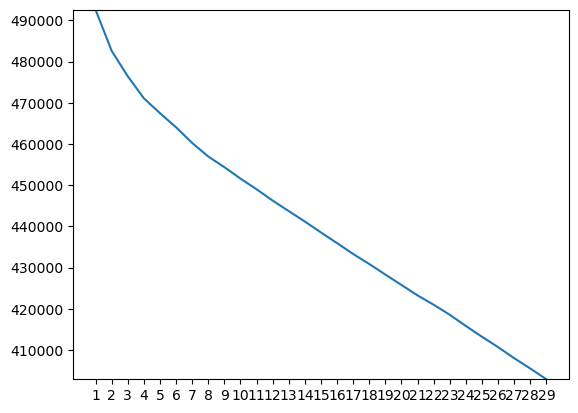

In [31]:
mean_final_losses = {n:np.mean([l[-1] for l in losses.values()]) for n,losses in losses_kfold.items()}
plt.ylim((min(mean_final_losses.values()),max(mean_final_losses.values())))
plt.plot(range(1,len(mean_final_losses)+1), mean_final_losses.values())
plt.xticks(range(1, len(mean_final_losses)+1))
plt.show()

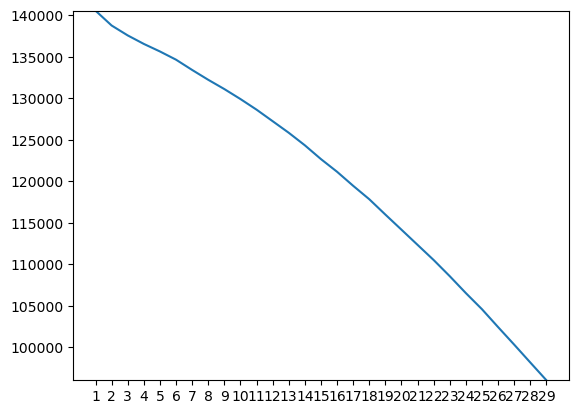

In [32]:
mean_final_test_losses = {n:np.mean([l[-1] for l in losses.values()]) for n,losses in test_losses_kfold.items()}
plt.ylim((min(mean_final_test_losses.values()),max(mean_final_test_losses.values())))
plt.plot(range(1,len(mean_final_test_losses)+1), mean_final_test_losses.values())
plt.xticks(range(1, len(mean_final_test_losses)+1))
plt.show()

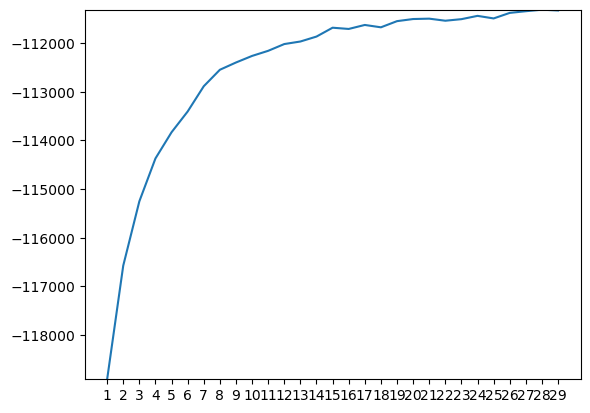

In [33]:
def kfold_mean_likelihood(likelihoods):
    return np.mean([l.sum() for l in likelihoods])

mean_test_likelihoods = {n: kfold_mean_likelihood(likelihoods) for n,likelihoods in test_likelihoods_kfold.items()}
plt.ylim((min(mean_test_likelihoods.values()),max(mean_test_likelihoods.values())))
plt.plot(range(1,len(mean_test_likelihoods)+1), mean_test_likelihoods.values())
plt.xticks(range(1, len(mean_test_likelihoods)+1))
plt.show()

In [34]:
test_likelihoods_kfold[2]

[array([ -70.8457 ,  -76.0022 , -134.25989, ..., -121.57744, -145.23726,
        -111.59736], dtype=float32),
 array([-111.78093 ,  -77.38535 , -128.62473 , ...,  -91.600685,
        -142.11464 ,  -99.02509 ], dtype=float32),
 array([-128.14417 ,  -74.43881 , -163.27505 , ...,  -92.106606,
        -143.74739 , -133.03387 ], dtype=float32),
 array([ -92.10377,  -82.85481, -124.23952, ..., -124.30951, -122.05047,
        -142.72931], dtype=float32),
 array([ -90.80029,  -87.83422, -134.68143, ...,  -79.40175, -130.49632,
        -118.76483], dtype=float32)]

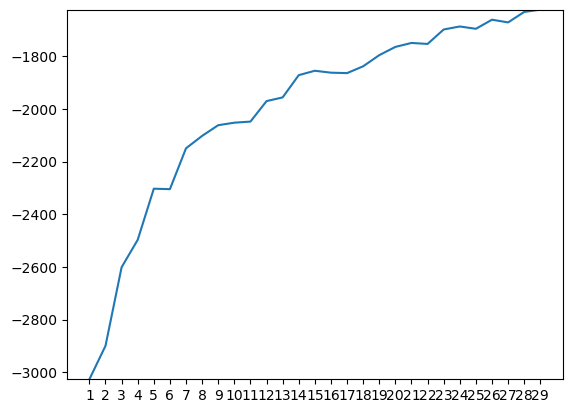

In [35]:
mean_test_likelihoods_inference = {n: kfold_mean_likelihood(likelihoods) for n,likelihoods in test_likelihoods_inference_kfold.items()}
plt.ylim((min(mean_test_likelihoods_inference.values()),max(mean_test_likelihoods_inference.values())))
plt.plot(range(1,len(mean_test_likelihoods_inference)+1), mean_test_likelihoods_inference.values())
plt.xticks(range(1, len(mean_test_likelihoods_inference)+1))
plt.show()

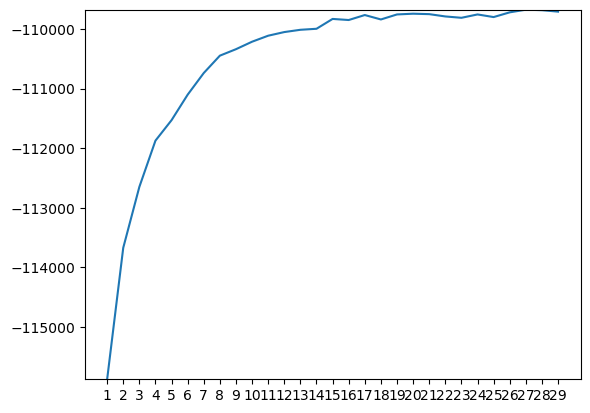

In [36]:
mean_test_likelihoods_syntax = {n: kfold_mean_likelihood(likelihoods) for n,likelihoods in test_likelihoods_syntax_kfold.items()}
plt.ylim((min(mean_test_likelihoods_syntax.values()),max(mean_test_likelihoods_syntax.values())))
plt.plot(range(1,len(mean_test_likelihoods_syntax)+1), mean_test_likelihoods_syntax.values())
plt.xticks(range(1, len(mean_test_likelihoods_syntax)+1))
plt.show()

We use a bootstrapped likelihood ratio test with bonferroni corrections to choose the optimal number of clusters. We choose the minimum number of clusters such that no model with a greater number of clusters performs reliably better on both the inference and syntactic judgments.

In [37]:
def kfold_mean_likelihood_per_item(likelihoods):
    return np.array(likelihoods).mean(0)

kfold_mean_likelihood_per_item(test_likelihoods_inference_kfold[2]).shape

(1007,)

In [38]:
curr_n_components = min(test_likelihoods_kfold)
curr_best = True
n_tests = 0

np.random.seed(42)

while True:
    for n_components in range(curr_n_components+1, max(test_likelihoods_kfold)+1):
        # loss_inf = -kfold_mean_likelihood_per_item(test_likelihoods_inference_kfold[n_components])
        # loss_inf_curr = -kfold_mean_likelihood_per_item(test_likelihoods_inference_kfold[curr_n_components])
        # loss_syn = -kfold_mean_likelihood_per_item(test_likelihoods_syntax_kfold[n_components])
        # loss_syn_curr = -kfold_mean_likelihood_per_item(test_likelihoods_syntax_kfold[curr_n_components])
        loss = -kfold_mean_likelihood_per_item(test_likelihoods_kfold[n_components])
        loss_curr = -kfold_mean_likelihood_per_item(test_likelihoods_kfold[curr_n_components])

        # lr_inf = loss_inf - loss_inf_curr
        # lr_syn = loss_syn - loss_syn_curr
        lr = loss - loss_curr

        alpha = 0.025/(n_tests+1)
        
        # ci_inf = np.quantile([np.sum(np.random.choice(lr_inf.flatten(), 
        #                                               size=len(lr_inf.flatten()),
        #                                               replace=True))
        #                                for _ in range(999)], [alpha, 0.5, 1.-alpha])
        # ci_syn = np.quantile([np.sum(np.random.choice(lr_syn.flatten(), 
        #                                               size=len(lr_syn.flatten()),
        #                                               replace=True))
        #                                for _ in range(999)], [alpha, 0.5, 1.-alpha])
        ci = np.quantile([np.sum(np.random.choice(lr.flatten(), 
                                                      size=len(lr.flatten()),
                                                      replace=True))
                                       for _ in range(999)], [alpha, 0.5, 1.-alpha])

        n_tests += 1

        # if ci_inf[2] < 0 and ci_syn[2] < 0:
        #     ci_inf = np.round(ci_inf, 3)
        #     ci_syn = np.round(ci_syn, 3)
        #     print(f'Model with {n_components} components outperforms '
        #           f'model with {curr_n_components} components')
        #     print(f'Difference in inference log-likelihood: {ci_inf[1]}, 95%CI=[{ci_inf[0]}, {ci_inf[2]}], alpha={np.round(alpha, 5)}')
        #     print(f'Difference in syntax log-likelihood: {ci_syn[1]}, 95%CI=[{ci_syn[0]}, {ci_syn[2]}], alpha={np.round(alpha, 5)}')
        #     print()
        #     curr_n_components += 1
        #     break
        if ci[2] < 0:
            ci = np.round(ci, 3)
            print(f'Model with {n_components} components outperforms '
                  f'model with {curr_n_components} components')
            print(f'Difference in log-likelihood: {ci[1]}, 95%CI=[{ci[0]}, {ci[2]}], alpha={np.round(alpha, 5)}')
            print()
            curr_n_components += 1
            break

    else:
        print()
        print(f'The model with {curr_n_components} components is the optimal model.')
        
        best_n_components = curr_n_components
        break      

Model with 3 components outperforms model with 2 components
Difference in log-likelihood: -2335.163, 95%CI=[-2535.281, -2160.536], alpha=0.025

Model with 4 components outperforms model with 3 components
Difference in log-likelihood: -1315.031, 95%CI=[-1452.306, -1194.149], alpha=0.0125

Model with 5 components outperforms model with 4 components
Difference in log-likelihood: -877.751, 95%CI=[-1015.697, -742.551], alpha=0.00833

Model with 6 components outperforms model with 5 components
Difference in log-likelihood: -539.642, 95%CI=[-677.045, -406.154], alpha=0.00625

Model with 7 components outperforms model with 6 components
Difference in log-likelihood: -425.234, 95%CI=[-559.901, -302.041], alpha=0.005

Model with 8 components outperforms model with 7 components
Difference in log-likelihood: -519.913, 95%CI=[-633.271, -404.874], alpha=0.00417

Model with 9 components outperforms model with 8 components
Difference in log-likelihood: -339.4, 95%CI=[-460.939, -217.755], alpha=0.00357


We now fit the full model with the optimal number of clusters.

In [39]:
models = {}
losses = {}
parameters = {}

# CHECKPOINT_DIR = 'ckpt-sem-syn'

# for n_components in range(22, 23):
for n_components in range(best_n_components, best_n_components+1):
    print()
    pickle_name = f'{CHECKPOINT_DIR}/{n_components}.pickle'
    losses_pickle_name = f'{CHECKPOINT_DIR}/{n_components}_losses.pickle'
    print()
    
    if USE_CHECKPOINTS and os.path.isfile(pickle_name):
        print(f'Loading model with {n_components} components from checkpoint...')
        with open(pickle_name, 'rb') as f:
            models[n_components] = pickle.load(f)
    if USE_CHECKPOINTS and os.path.isfile(losses_pickle_name):
        with open(losses_pickle_name, 'rb') as f:
            losses[n_components] = pickle.load(f)
    
    else:
        print(f'Fitting model with {n_components} components...')
        models[n_components] = MultiviewMixedEffectsMixture(data, n_components, num_kmeans_trials=1, seed=403921)
        # models[n_components] = MultiviewMixedEffectsMixture(data, n_components, num_kmeans_trials=1, seed=403921, component_dispersion=.9375)
        _, _, losses[n_components] = models[n_components].fit(data, lr=0.02, tolerance=1e-7, n_epochs=10000, batch_size=0.05, patience=1000, verbosity=100)
        
        if USE_CHECKPOINTS:
            with open(pickle_name, 'wb') as f:
                pickle.dump(models[n_components], f)
            with open(losses_pickle_name, 'wb') as f:
                pickle.dump(losses[n_components], f)
    
    
    parameters[n_components] = {'weights': models[n_components].param('weights').data.numpy(),
                                'membership_probs': pd.DataFrame(models[n_components].membership_probabilities(data).data.numpy(), 
                                                        index=models[n_components]._verb),
                                'belief_desire_locs': pd.DataFrame(models[n_components].get_model('belief_desire')._locs().data.numpy(),
                                                                   columns=mc.item.astype('category').cat.categories).T,
                                'veridicality_locs': pd.DataFrame(models[n_components].get_model('veridicality')._locs().data.numpy(),
                                                                  columns=mv.item.astype('category').cat.categories).T,
                                'negraising_locs': pd.DataFrame(models[n_components].get_model('negraising')._locs().data.numpy(),
                                                                  columns=mn.item.astype('category').cat.categories).T,
                                'acceptability_locs': pd.DataFrame(models[n_components].get_model('acceptability')._locs().data.numpy(),
                                                                  columns=ma.item.astype('category').cat.categories).T,
                                'belief_desire_theta_1': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[0].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'belief_desire_theta_0': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[1].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'belief_desire_theta_prior': pd.DataFrame(models[n_components].get_model('belief_desire')._theta()[2].data.numpy(),
                                                                      columns=mc.item.astype('category').cat.categories).T,
                                'veridicality_jumps': models[n_components].get_model('veridicality')._jumps().data.numpy(),
                                'negraising_theta_1': pd.DataFrame(models[n_components].get_model('negraising')._theta()[0].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T,
                                'negraising_theta_0': pd.DataFrame(models[n_components].get_model('negraising')._theta()[1].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T,
                                'negraising_theta_prior': pd.DataFrame(models[n_components].get_model('negraising')._theta()[2].data.numpy(),
                                                                   columns=mn.item.astype('category').cat.categories).T,
                                'acceptability_jumps': models[n_components].get_model('acceptability')._jumps().data.numpy(),
                               }
    
    print()
    print('=====================================================================================')



Loading model with 25 components from checkpoint...



In [40]:
# best_n_components = 22
best_model = parameters[best_n_components]

In [41]:
# testprobs = parameters[best_n_components]['membership_probs'].round(decimals=3)
# testprobs.head(50)
# # testprobs.hist()
# for ntest in range(best_n_components):
#     # testslice = testprobs[(testprobs[ntest] > 0.3) & (testprobs[ntest] < 0.7)]
#     testslice = testprobs[(testprobs[ntest] > 0.9)]
#     if not testslice.empty:
#         print(ntest, testslice)
# # testprobs.loc['afford']

In [42]:
# import matplotlib.pyplot as plt

# if losses and all([i in losses for i in [2,4,16,20]]):
#     test1 = losses[2][:5000]
#     test2 = losses[4][:5000]
#     test3 = losses[16][:5000]
#     test4 = losses[20][:5000]
#     ylim_min = min([l for t in [test1, test2, test3, test4] for l in t])
#     ylim_max = max([l for t in [test1, test2, test3, test4] for l in t])
#     plt.ylim((ylim_min, ylim_max))
#     plt.plot(test1, label='2 components')
#     plt.plot(test2, label='4 components')
#     plt.plot(test3, label='16 components')
#     plt.plot(test4, label='20 components')
#     plt.legend()

In [43]:
# def model_likelihood(model):
#     return np.sum(model.likelihood_per_item(data).detach().numpy())

# final_likelihoods = {k: model_likelihood(m) for k,m in models.items()}
# plt.ylim((min(final_likelihoods.values()),max(final_likelihoods.values())))
# plt.plot(range(1,len(final_likelihoods)+1), final_likelihoods.values())
# plt.xticks(range(1, len(final_likelihoods)+1))
# plt.show()

In [44]:
# def count_parameters(model):
#     return sum(p.numel() for p in model.model.parameters() if p.requires_grad)

# count_parameters(models[2])

# def AIC(name, model):
#     k = count_parameters(model)
#     lp = -final_likelihoods[name]
#     return 2*k - 2*lp

# def BIC(name, model, data):
#     k = count_parameters(model)
#     n = sum([len(d.dataframe) for d in data])
#     lp = -final_likelihoods[name]
#     return k*np.log(n) - 2*lp

In [45]:
# AICs = {name:AIC(name,model) for name,model in models.items()}
# plt.ylim((min(AICs.values()),max(AICs.values())))
# plt.plot(range(1,len(AICs)+1), AICs.values())
# plt.xticks(range(1, len(AICs)+1))
# plt.show()

In [46]:
# BICs = {name:BIC(name,model,data) for name,model in models.items()}
# plt.ylim((min(BICs.values()),max(BICs.values())))
# plt.plot(range(1,len(BICs)+1), BICs.values())
# plt.xticks(range(1, len(BICs)+1))
# plt.show()

The membership probabilities indicate the probability that each verb falls within each cluster; more polysemous verbs should have more entropic distributions.

In [47]:
if os.path.exists('loadings_dumped'):
    best_model['membership_probs'].to_csv('loadings_dumped/membership_probs.csv')
best_model['membership_probs'].round(decimals=3)

0      1      2      3      4      5      6      7      8    
abhor     0.006  0.000  0.302  0.000  0.141  0.037  0.000  0.000  0.056  \
absolve   0.000  0.000  0.202  0.000  0.000  0.082  0.000  0.216  0.000   
accept    0.000  0.381  0.000  0.048  0.000  0.101  0.031  0.000  0.000   
acclaim   0.132  0.014  0.028  0.037  0.000  0.010  0.000  0.075  0.000   
accredit  0.077  0.000  0.000  0.000  0.000  0.000  0.000  0.053  0.000   
...         ...    ...    ...    ...    ...    ...    ...    ...    ...   
write     0.021  0.008  0.000  0.414  0.000  0.000  0.121  0.000  0.000   
yawn      0.000  0.018  0.000  0.000  0.000  0.151  0.000  0.010  0.000   
yearn     0.011  0.000  0.000  0.000  0.000  0.522  0.099  0.000  0.000   
yell      0.000  0.000  0.000  0.389  0.000  0.018  0.299  0.000  0.000   
yelp      0.000  0.000  0.000  0.210  0.000  0.134  0.104  0.000  0.000   

             9   ...     15     16     17     18     19     20     21     22   
abhor     0.095  ...  0.000  0.000  0.000  0.031  0.000  0.000  0.000  0.151  \
absolve   0.000  ...  0.000  0.000  0.024  0.000  0.094  0.077  0.016  0.000   
accept    0.000  ...  0.000  0.007  0.077  0.095  0.000  0.000  0.043  0.000   
acclaim   0.012  ...  0.000  0.000  0.289  0.000  0.082  0.054  0.000  0.000   
accredit  0.000  ...  0.000  0.000  0.177  0.000  0.000  0.000  0.060  0.032   
...         ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
write     0.000  ...  0.000  0.134  0.000  0.245  0.000  0.000  0.003  0.000   
yawn      0.000  ...  0.214  0.000  0.000  0.000  0.000  0.000  0.000  0.000   
yearn     0.042  ...  0.002  0.000  0.000  0.000  0.000  0.068  0.011  0.014   
yell      0.031  ...  0.061  0.064  0.000  0.058  0.010  0.000  0.000  0.000   
yelp      0.013  ...  0.177  0.000  0.000  0.000  0.106  0.141  0.000  0.000   

             23     24  
abhor     0.034  0.000  
absolve   0.026  0.000  
accept    0.105  0.000  
acclaim   0.009  0.036  
accredit  0.000  0.147  
...         ...    ...  
write     0.000  0.000  
yawn      0.000  0.014  
yearn     0.122  0.000  
yell      0.042  0.000  
yelp      0.066  0.000  

[1007 rows x 25 columns]

We compute the loadings for each cluster.

For the unit models, we use the linear sum $\mathbf{v} = 1*\boldsymbol\theta_1 + 0*\boldsymbol\theta_0 + \boldsymbol\mu * \boldsymbol\theta_{\mu}$, where $\boldsymbol\mu$ is the location parameter for the response prior distribution, and $\boldsymbol\theta_i$ are the mixing weights for each response distribution.

For the ordinal models, TODO

In [48]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

In [49]:
best_model['belief_desire_value'] = (1 * best_model['belief_desire_theta_1']
                                     + 0 * best_model['belief_desire_theta_0']
                                     + best_model['belief_desire_locs'] * best_model['belief_desire_theta_prior'])

if os.path.exists('loadings_dumped'):
    best_model['belief_desire_value'].to_csv('loadings_dumped/belief_desire.csv')
best_model['belief_desire_value']

0    
negative-object-na-believe-NP V NP that S           1.203852e-07  \
negative-object-na-believe-NP V NP that S[+future]  4.475707e-16   
negative-object-na-believe-NP V NP that S[-tense]   3.443536e-21   
negative-object-na-believe-NP V to NP that S        1.727431e-38   
negative-object-na-believe-NP V to NP that S[+f...  1.125075e-37   
...                                                          ...   
positive-subject-subject-want-NP V VPing            1.000000e+00   
positive-subject-subject-want-NP V to NP to VP[...  9.749572e-01   
positive-subject-subject-want-NP V to NP to VP[...  3.079637e-01   
positive-subject-subject-want-NP V to VP[+event...  1.000000e+00   
positive-subject-subject-want-NP V to VP[-event...  1.000000e+00   

                                                              1    
negative-object-na-believe-NP V NP that S           9.999999e-01  \
negative-object-na-believe-NP V NP that S[+future]  1.000000e+00   
negative-object-na-believe-NP V NP that S[-tense]   6.075349e-21   
negative-object-na-believe-NP V to NP that S        4.752842e-01   
negative-object-na-believe-NP V to NP that S[+f...  1.459975e-25   
...                                                          ...   
positive-subject-subject-want-NP V VPing            1.000000e+00   
positive-subject-subject-want-NP V to NP to VP[...  1.112772e-03   
positive-subject-subject-want-NP V to NP to VP[...  6.677278e-01   
positive-subject-subject-want-NP V to VP[+event...  1.000000e+00   
positive-subject-subject-want-NP V to VP[-event...  1.000000e+00   

                                                              2    
negative-object-na-believe-NP V NP that S           3.521284e-01  \
negative-object-na-believe-NP V NP that S[+future]  6.265430e-18   
negative-object-na-believe-NP V NP that S[-tense]   9.973420e-02   
negative-object-na-believe-NP V to NP that S        8.808259e-01   
negative-object-na-believe-NP V to NP that S[+f...  9.999717e-01   
...                                                          ...   
positive-subject-subject-want-NP V VPing            2.362536e-01   
positive-subject-subject-want-NP V to NP to VP[...  3.543779e-02   
positive-subject-subject-want-NP V to NP to VP[...  3.115645e-01   
positive-subject-subject-want-NP V to VP[+event...  2.902491e-08   
positive-subject-subject-want-NP V to VP[-event...  9.139812e-12   

                                                              3    
negative-object-na-believe-NP V NP that S           5.114229e-01  \
negative-object-na-believe-NP V NP that S[+future]  1.386170e-34   
negative-object-na-believe-NP V NP that S[-tense]   9.372302e-22   
negative-object-na-believe-NP V to NP that S        4.890521e-01   
negative-object-na-believe-NP V to NP that S[+f...  2.354013e-01   
...                                                          ...   
positive-subject-subject-want-NP V VPing            1.000000e+00   
positive-subject-subject-want-NP V to NP to VP[...  1.000000e+00   
positive-subject-subject-want-NP V to NP to VP[...  6.677504e-01   
positive-subject-subject-want-NP V to VP[+event...  1.000000e+00   
positive-subject-subject-want-NP V to VP[-event...  1.000000e+00   

                                                              4    
negative-object-na-believe-NP V NP that S           5.018746e-01  \
negative-object-na-believe-NP V NP that S[+future]  3.340585e-18   
negative-object-na-believe-NP V NP that S[-tense]   4.139380e-03   
negative-object-na-believe-NP V to NP that S        5.047414e-01   
negative-object-na-believe-NP V to NP that S[+f...  3.940844e-15   
...                                                          ...   
positive-subject-subject-want-NP V VPing            4.828687e-01   
positive-subject-subject-want-NP V to NP to VP[...  9.999832e-01   
positive-subject-subject-want-NP V to NP to VP[...  6.672117e-01   
positive-subject-subject-want-NP V to VP[+event...  5.330590e-09   
positive-subject-subject-want-NP V to VP[-even

In [50]:
best_model['negraising_value'] = (1 * best_model['negraising_theta_1']
                                  + 0 * best_model['negraising_theta_0']
                                  + best_model['negraising_locs'] * best_model['negraising_theta_prior'])

if os.path.exists('loadings_dumped'):
    best_model['negraising_value'].to_csv('loadings_dumped/negraising.csv')
best_model['negraising_value']

0             1    
first-past-NP V that S                  8.666409e-08  1.314246e-08  \
first-past-NP V to VP[+eventive]        7.583328e-01  8.674124e-01   
first-past-NP V to VP[-eventive]        9.999993e-01  9.999927e-01   
first-past-NP be V that S               3.690169e-09  4.323084e-09   
first-past-NP be V to VP[+eventive]     1.786571e-20  9.929911e-01   
first-past-NP be V to VP[-eventive]     5.180380e-01  9.998962e-01   
first-present-NP V that S               2.326558e-04  9.999999e-01   
first-present-NP V to VP[+eventive]     9.999726e-01  5.435590e-01   
first-present-NP V to VP[-eventive]     9.994574e-01  9.942751e-01   
first-present-NP be V that S            1.122498e-10  4.756252e-01   
first-present-NP be V to VP[+eventive]  9.337704e-03  9.999993e-01   
first-present-NP be V to VP[-eventive]  5.012006e-01  1.000000e+00   
third-past-NP V that S                  6.360806e-06  9.806359e-06   
third-past-NP V to VP[+eventive]        3.919871e-02  9.984956e-01   
third-past-NP V to VP[-eventive]        9.999664e-01  9.999680e-01   
third-past-NP be V that S               2.951250e-03  1.664610e-14   
third-past-NP be V to VP[+eventive]     4.848767e-01  9.991832e-01   
third-past-NP be V to VP[-eventive]     5.264897e-01  1.000000e+00   
third-present-NP V that S               2.208772e-01  8.610442e-01   
third-present-NP V to VP[+eventive]     1.000000e+00  1.000000e+00   
third-present-NP V to VP[-eventive]     9.446210e-01  1.000000e+00   
third-present-NP be V that S            1.249080e-12  4.498578e-01   
third-present-NP be V to VP[+eventive]  1.628030e-01  9.999993e-01   
third-present-NP be V to VP[-eventive]  9.475484e-03  1.000000e+00   

                                                  2             3    
first-past-NP V that S                  1.749823e-08  4.593288e-07  \
first-past-NP V to VP[+eventive]        2.816273e-10  6.783091e-10   
first-past-NP V to VP[-eventive]        4.974435e-10  4.682397e-01   
first-past-NP be V that S               1.418405e-03  5.114990e-01   
first-past-NP be V to VP[+eventive]     6.163440e-28  3.941067e-01   
first-past-NP be V to VP[-eventive]     4.719216e-01  8.079063e-01   
first-present-NP V that S               3.253480e-04  3.449425e-06   
first-present-NP V to VP[+eventive]     8.997321e-14  6.499316e-01   
first-present-NP V to VP[-eventive]     4.212730e-09  3.019951e-01   
first-present-NP be V that S            7.576343e-09  6.461996e-04   
first-present-NP be V to VP[+eventive]  7.804871e-04  1.489788e-03   
first-present-NP be V to VP[-eventive]  4.850227e-01  4.730639e-01   
third-past-NP V that S                  4.500518e-04  3.745645e-06   
third-past-NP V to VP[+eventive]        1.535426e-03  8.439844e-10   
third-past-NP V to VP[-eventive]        6.334583e-15  2.040411e-06   
third-past-NP be V that S               1.333667e-14  3.655540e-01   
third-past-NP be V to VP[+eventive]     1.156044e-01  5.719896e-10   
third-past-NP be V to VP[-eventive]     4.220235e-06  1.000000e+00   
third-present-NP V that S               1.594113e-02  1.617041e-04   
third-present-NP V to VP[+eventive]     1.234634e-09  1.619078e-08   
third-present-NP V to VP[-eventive]     5.345818e-01  4.718681e-01   
third-present-NP be V that S            2.046169e-10  1.148623e-07   
third-present-NP be V to VP[+eventive]  6.304252e-02  4.471535e-12   
third-present-NP be V to VP[-eventive]  1.153485e-08  9.999994e-01   

                                                  4             5    
first-past-NP V that S                  2.046077e-16  3.253335e-08  \
first-past-NP V to VP[+eventive]        3.840842e-07  6.696925e-01   
first-past-NP V to VP[-eventive]        9.072862e-11  1.584808e-10   
first-past-NP be V that S               9.106965e-12  1.795347e-01   
first-past-NP be V to VP[+eventive]     3.248762e-11  1.820447e-03   
first-past-NP be V to VP[-eventive]     3.786690e-03  6.000824e-04   
first-present-NP V that S               1.097064e-05  5.59

In [51]:
veridicality_jumps = best_model['veridicality_jumps']
veridicality_cuts = np.exp(veridicality_jumps).cumsum(axis=0)
veridicality_cuts = veridicality_cuts - np.mean(veridicality_cuts)

veridicality_locs = best_model['veridicality_locs'].to_numpy()
veridicality_locs = np.concatenate(veridicality_cuts.shape[-1]*[veridicality_locs[:,:,None]], axis=-1)

veridicality_cdf = sigmoid(veridicality_cuts - veridicality_locs)
veridicality_cdf_pad_shape = list(veridicality_cdf.shape[:-1])+[1]
veridicality_cdf_high = np.concatenate([veridicality_cdf, np.ones(veridicality_cdf_pad_shape)], axis=-1)
veridicality_cdf_low = np.concatenate([np.zeros(veridicality_cdf_pad_shape), veridicality_cdf], axis=-1)

veridicality_pmf = veridicality_cdf_high - veridicality_cdf_low

veridicality_levels = np.expand_dims(np.linspace(0., 1., veridicality_pmf.shape[-1]), axis=(0,1))

veridicality_value = best_model['veridicality_locs'].copy()
veridicality_value[list(range(best_n_components))] = np.sum(veridicality_pmf*veridicality_levels, axis=2)
best_model['veridicality_value'] = veridicality_value

if os.path.exists('loadings_dumped'):
    best_model['veridicality_value'].to_csv('loadings_dumped/veridicality.csv')
best_model['veridicality_value']

0         1         2         3    
negative-NP V NP to VP[+eventive]  0.337051  0.166958  0.480052  0.275602  \
negative-NP V NP to VP[-eventive]  0.426950  0.534022  0.485424  0.420717   
negative-NP V for NP to VP         0.985277  0.988644  0.472535  0.383942   
negative-NP V that S               0.400155  0.991462  0.513407  0.446109   
negative-NP V to VP[+eventive]     0.975738  0.077586  0.481698  0.393848   
negative-NP V to VP[-eventive]     0.523636  0.137819  0.476986  0.418173   
negative-NP be V that S            0.681260  0.501030  0.729022  0.828082   
negative-NP be V to VP[+eventive]  0.394755  0.186471  0.481472  0.427153   
negative-NP be V to VP[-eventive]  0.308146  0.000963  0.487837  0.439688   
positive-NP V NP to VP[+eventive]  0.491157  0.484525  0.338159  0.482796   
positive-NP V NP to VP[-eventive]  0.487821  0.982119  0.002986  0.465685   
positive-NP V for NP to VP         0.475999  0.483143  0.435206  0.467262   
positive-NP V that S               0.471131  0.975491  0.920710  0.651918   
positive-NP V to VP[+eventive]     0.490720  0.498867  0.488303  0.472054   
positive-NP V to VP[-eventive]     0.463912  0.992591  0.504757  0.490654   
positive-NP be V that S            0.914313  0.359708  0.902729  0.504740   
positive-NP be V to VP[+eventive]  0.478894  0.989782  0.422038  0.479367   
positive-NP be V to VP[-eventive]  0.487529  0.994663  0.005676  0.444434   

                                         4         5         6         7    
negative-NP V NP to VP[+eventive]  0.465354  0.460462  0.451428  0.247977  \
negative-NP V NP to VP[-eventive]  0.499117  0.484860  0.455764  0.440453   
negative-NP V for NP to VP         0.511316  0.449315  0.460163  0.388810   
negative-NP V that S               0.840468  0.515013  0.389719  0.251272   
negative-NP V to VP[+eventive]     0.955346  0.302507  0.334979  0.267276   
negative-NP V to VP[-eventive]     0.332591  0.462759  0.369936  0.313990   
negative-NP be V that S            0.958851  0.538771  0.365238  0.966183   
negative-NP be V to VP[+eventive]  0.480819  0.309534  0.460314  0.486186   
negative-NP be V to VP[-eventive]  0.975408  0.490860  0.447696  0.985270   
positive-NP V NP to VP[+eventive]  0.710163  0.459593  0.479646  0.989525   
positive-NP V NP to VP[-eventive]  0.481586  0.478028  0.471643  0.972838   
positive-NP V for NP to VP         0.976434  0.461850  0.475974  0.475603   
positive-NP V that S               0.877939  0.961112  0.358976  0.568736   
positive-NP V to VP[+eventive]     0.976609  0.477791  0.465603  0.482689   
positive-NP V to VP[-eventive]     0.464183  0.162759  0.451059  0.489227   
positive-NP be V that S            0.978087  0.522908  0.401625  0.951854   
positive-NP be V to VP[+eventive]  0.486667  0.483603  0.473444  0.984543   
positive-NP be V to VP[-eventive]  0.982226  0.465005  0.477699  0.989815   

                                         8         9   ...        15   
negative-NP V NP to VP[+eventive]  0.450999  0.967077  ...  0.196837  \
negative-NP V NP to VP[-eventive]  0.558628  0.993118  ...  0.402028   
negative-NP V for NP to VP         0.472170  0.490932  ...  0.446406   
negative-NP V that S               0.498562  0.938646  ...  0.534554   
negative-NP V to VP[+eventive]     0.477131  0.983446  ...  0.470398   
negative-NP V to VP[-eventive]     0.493749  0.989898  ...  0.406072   
negative-NP be V that S            0.479311  0.761284  ...  0.676595   
negative-NP be V to VP[+eventive]  0.469022  0.978332  ...  0.432594   
negative-NP be V to VP[-eventive]  0.501412  0.561490  ...  0.418275   
positive-NP V NP to VP[+eventive]  0.471775  0.005047  ...  0.499360   
positive-NP V NP to VP[-eventive]  0.432335  0.229194  ...  0.252220   
positive-NP V for NP to VP         0.465768  0.083271  ...  0.477366   
positive-NP V that S               0.385687  0.947056  ...  0.989027   
positive-NP V to VP[+eventive]     0.182014  0.001404  ...  0.479024   
positive-NP V to VP[-eventive]   

In [52]:
acceptability_jumps = best_model['acceptability_jumps']
acceptability_cuts = np.exp(acceptability_jumps).cumsum(axis=0)
acceptability_cuts = acceptability_cuts - np.mean(acceptability_cuts)

acceptability_locs = best_model['acceptability_locs'].to_numpy()
acceptability_locs = np.concatenate(acceptability_cuts.shape[-1]*[acceptability_locs[:,:,None]], axis=-1)

acceptability_cdf = sigmoid(acceptability_cuts - acceptability_locs)
acceptability_cdf_pad_shape = list(acceptability_cdf.shape[:-1])+[1]
acceptability_cdf_high = np.concatenate([acceptability_cdf, np.ones(acceptability_cdf_pad_shape)], axis=-1)
acceptability_cdf_low = np.concatenate([np.zeros(acceptability_cdf_pad_shape), acceptability_cdf], axis=-1)

acceptability_pmf = acceptability_cdf_high - acceptability_cdf_low

acceptability_levels = np.expand_dims(np.linspace(0., 1., acceptability_pmf.shape[-1]), axis=(0,1))

acceptability_value = best_model['acceptability_locs'].copy()
acceptability_value[list(range(best_n_components))] = np.sum(acceptability_pmf*acceptability_levels, axis=2)
best_model['acceptability_value'] = acceptability_value

if os.path.exists('loadings_dumped'):
    best_model['acceptability_value'].to_csv('loadings_dumped/acceptability.csv')
best_model['acceptability_value']

0         1         2         3    
past-NP V                           0.101364  0.991884  0.413490  0.999832  \
past-NP V NP                        0.478653  0.999735  0.998155  0.999710   
past-NP V NP VP                     0.223305  0.201613  0.228404  0.342905   
past-NP V NP VPing                  0.199529  0.999749  0.846645  0.277896   
past-NP V NP that S                 0.176727  0.175184  0.258417  0.275476   
...                                      ...       ...       ...       ...   
present-NP be V whether S[+future]  0.458102  0.135968  0.002620  0.489576   
present-NP be V whether to VP       0.667803  0.044159  0.339894  0.427139   
present-NP be V whichNP S           0.484636  0.358555  0.753383  0.069845   
present-NP be V whichNP to VP       0.030989  0.448240  0.196854  0.427996   
present-S, I V                      0.000145  0.786018  0.183407  0.564966   

                                          4         5         6         7    
past-NP V                           0.603933  0.999767  0.999967  0.287944  \
past-NP V NP                        0.765190  0.284471  0.933865  0.409610   
past-NP V NP VP                     0.185854  0.169831  0.795583  0.273192   
past-NP V NP VPing                  0.210839  0.163355  0.258472  0.246037   
past-NP V NP that S                 0.316368  0.134761  0.237563  0.239937   
...                                      ...       ...       ...       ...   
present-NP be V whether S[+future]  0.821494  0.461307  0.529949  0.724738   
present-NP be V whether to VP       0.863084  0.164243  0.002883  0.404941   
present-NP be V whichNP S           0.039044  0.314619  0.352532  0.275551   
present-NP be V whichNP to VP       0.530936  0.518685  0.247316  0.364128   
present-S, I V                      0.145383  0.244454  0.998367  0.303860   

                                          8         9   ...        15   
past-NP V                           0.998015  0.819700  ...  0.949246  \
past-NP V NP                        0.998446  0.998883  ...  0.790731   
past-NP V NP VP                     0.335568  0.277621  ...  0.182743   
past-NP V NP VPing                  0.897444  0.999319  ...  0.147807   
past-NP V NP that S                 0.656906  0.168020  ...  0.165844   
...                                      ...       ...  ...       ...   
present-NP be V whether S[+future]  0.786246  0.338337  ...  0.279644   
present-NP be V whether to VP       0.565800  0.392995  ...  0.452642   
present-NP be V whichNP S           0.711638  0.518560  ...  0.439462   
present-NP be V whichNP to VP       0.472685  0.467182  ...  0.456938   
present-S, I V                      0.793092  0.421829  ...  0.817336   

                                          16        17        18        19   
past-NP V                           0.997778  0.791143  0.834523  0.938834  \
past-NP V NP                        0.248794  0.818954  0.999041  0.928098   
past-NP V NP VP                     0.998253  0.296691  0.628320  0.610665   
past-NP V NP VPing                  0.490188  0.561269  0.879957  0.945893   
past-NP V NP that S                 0.997301  0.286144  0.712675  0.281031   
...                                      ...       ...       ...       ...   
present-NP be V whether S[+future]  0.843885  0.368413  0.594540  0.355133   
present-NP be V whether to VP       0.904623  0.282274  0.621229  0.371068   
present-NP be V whichNP S           0.881841  0.532428  0.551135  0.184261   
present-NP be V whichNP to VP       0.870152  0.388861  0.427045  0.451865   
present-S, I V                      0.581506  0.773620  0.922624  0.229125   

                                          20        21        22        23   
past-NP V                           0.998637  0.731057  0.209158  0.375215  \
past-NP V NP                        0.367709  0.782209  0.184324  0.999526   
past-NP V NP VP                     0.242634  0.814692  0.216638  0.944494   
past-NP V NP VPing                  0.2321

We use hierarchical clustering on the cluster inference loadings and use the resulting dendrogram for sorting and labelling the clusters.

In [53]:
best_belief_desire_means = best_model['belief_desire_value'].copy()
factors = np.array([np.array(x) for x 
                    in best_belief_desire_means.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_belief_desire_means[['polarity', 'target', 'control', 'consequent_verb', 'frame']] = factors
best_belief_desire_means['frame'] = best_belief_desire_means.frame.str.replace('0', '-')
best_belief_desire_means['tense'] = 'past'

best_belief_desire_means = best_belief_desire_means.pivot_table(values=range(0, best_n_components), index=['polarity', 'target', 'control', 'consequent_verb']).reset_index()

In [54]:
best_negraising_means = best_model['negraising_value'].copy()
factors = np.array([np.array(x) for x 
                    in best_negraising_means.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_negraising_means[['person', 'tense', 'frame']] = factors
best_negraising_means['frame'] = best_negraising_means.frame.str.replace('0', '-')

best_negraising_means = best_negraising_means.pivot_table(values=range(0, best_n_components), index=['person', 'tense']).reset_index()

In [55]:
best_veridicality_means = best_model['veridicality_value'].copy()

factors = np.array([np.array(x) for x 
                    in best_veridicality_means.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_veridicality_means[['polarity', 'frame']] = factors
best_veridicality_means['frame'] = best_veridicality_means.frame.str.replace('0', '-')
best_veridicality_means['tense'] = 'past'

best_veridicality_means = best_veridicality_means.pivot_table(values=range(0, best_n_components), index=['polarity']).reset_index()

In [56]:
inference_locs = pd.concat([
    best_belief_desire_means.drop(columns=['polarity', 'target', 'control', 'consequent_verb']),
    best_negraising_means.drop(columns=['person', 'tense']),
    best_veridicality_means]).drop(columns=['polarity'])

inference_locs.T.shape

(25, 38)

In [57]:
# inference_linkage = linkage(inference_locs.T, method='ward')
inference_linkage = linkage(inference_locs.T, method='complete', metric='correlation')

inference_linkage

array([[16.        , 19.        ,  0.08783111,  2.        ],
       [ 3.        , 18.        ,  0.09234881,  2.        ],
       [ 7.        , 10.        ,  0.09682345,  2.        ],
       [ 0.        , 12.        ,  0.10758424,  2.        ],
       [14.        , 24.        ,  0.11834901,  2.        ],
       [26.        , 27.        ,  0.12581387,  4.        ],
       [ 5.        , 23.        ,  0.1264596 ,  2.        ],
       [ 4.        , 20.        ,  0.14671457,  2.        ],
       [13.        , 25.        ,  0.15434603,  3.        ],
       [ 1.        , 17.        ,  0.15513919,  2.        ],
       [29.        , 30.        ,  0.15725726,  6.        ],
       [ 2.        ,  8.        ,  0.15775469,  2.        ],
       [ 6.        , 34.        ,  0.18531157,  3.        ],
       [21.        , 33.        ,  0.18729123,  4.        ],
       [28.        , 35.        ,  0.20436579,  8.        ],
       [31.        , 37.        ,  0.20760436,  5.        ],
       [22.        , 32.

In [58]:
# def cluster_elbow(Z):
#     last = Z[-10:, 2]
#     last_rev = last[::-1]
#     idxs = np.arange(1, len(last) + 1)
#     plt.plot(idxs, last_rev)

#     acceleration = np.diff(last, 2)
#     acceleration_rev = acceleration[::-1]
#     plt.plot(idxs[:-2] + 1, acceleration_rev)
#     plt.show()
#     k = acceleration_rev.argmax() + 2
#     return k

# cluster_elbow(inference_linkage)

In [59]:
n_cluster_groups = 5

inference_group_cutoff = inference_linkage[-(n_cluster_groups-1),2]

inference_groups = fcluster(inference_linkage, n_cluster_groups, 'maxclust')

cluster_order = leaves_list(inference_linkage)

# inference_group_labels = {
#     1: 'Desire/Intention Communicatives',  # Root modality? Generally relational but not quite due to aspectual cluster
#     2: 'Cognitive Communicatives',
#     3: 'Pure Cognitives',
#     4: 'Negative External Emotives',
#     5: 'Negative Internal Emotives',
# }

inference_group_labels = {
    1: 'Group 3',
    2: 'Group 2',
    3: 'Group 1',
    4: 'Group 5',
    5: 'Group 4',
}

cluster_groups = {idx:inference_group_labels[group] for idx,group in enumerate(inference_groups)}
group_clusters = {label:[] for label in inference_group_labels.values()}

for idx,label in inference_group_labels.items():
    for c in cluster_order:
        if cluster_groups[c] == label:
            group_clusters[label].append(c)

cluster_order

array([11, 21, 13, 16, 19,  0, 12, 14, 24,  3, 18,  7, 10,  5, 23,  6,  1,
       17, 15, 22,  4, 20,  9,  2,  8], dtype=int32)

In [60]:
# cluster_labels = {
#     0: '(Misc1)',  # Misc Emotives? Elsewhere class? Purpose is to weaken means slightly for particular verb
#     1: 'Cognitive (Semi)factives',  # *
#     2: 'Antipermissives',  # Negative social relationals? Prohibitives?
#     3: 'Weak Doxastic Communicatives',  # *
#     4: 'Negative Uncertainty',  # Uncertainty
#     5: 'Preferentials',  # Prospective Preferentials?
#     6: 'Internal Representationals',  # Representationals
#     7: 'Positive Internal Emotives',  # *
#     8: 'Negative Antidoxastics', # Antidoxastics
#     9: 'Negative Internal Emotives',  # Negative attitudes?
#     10: 'Speculatives',  # Evaluatives?
#     11: 'Bouletic Communicatives',  # Gestural Communicatives/Emotives?
#     12: 'Justification Communicatives',  # Directed Representationals/Depictives/Portraitives?
#     13: '(Misc2)',  # Mix of Circumstantials + Aspectuals? Generally non-contentful items
#     14: 'Transactional',  # Aspectuals + (Physical) Change of State? Generally non-contentful items
#     15: 'Negative External Emotives',  
#     16: 'Intentional Communicatives',  # Advisatives/Informatives?
#     17: 'Commitment',  # Reasoning (+ judgment)?
#     18: 'Strong Doxastic Communicatives',  # *
#     19: 'Judgmentals',  # Reactives/reactionals?
#     20: 'Argumentatives',  # *
#     21: 'Persuasives', # *
#     22: 'Negative Miratives',  # Miratives
#     23: 'External Representationals',  # Authoritatives?
#     24: 'Coercives'  # *
# }

cluster_labels = {
    0: 'Misc Emotives',
    1: 'Cognitive (Semi)factives',
    2: 'Prohibitives',
    3: 'Weak Doxastic Communicatives',
    4: 'Uncertainty',
    5: 'Prospective Preferentials',
    6: 'Representationals',
    7: 'Positive Internal Emotives',
    8: 'Antidoxastics',
    9: 'Negative Attitudes',
    10: 'Evaluatives',
    11: 'Gestural Communicatives',
    12: 'Portraitives',
    13: 'Circumstantials + Aspectuals',
    14: 'Change of State + Aspectuals',
    15: 'Negative External Emotives',  
    16: 'Informatives',
    17: 'Reasoning + Judgment',
    18: 'Strong Doxastic Communicatives',
    19: 'Reactives',
    20: 'Argumentatives',
    21: 'Persuasives',
    22: 'Miratives',
    23: 'Authoritatives',
    24: 'Coercives'
}

cluster_labels = {i: str(i) if not cluster_labels[i] else cluster_labels[i] for i in range(best_n_components)}

# Don't find coherent aspectuals class - no way of capturing inferences about temporal structure of aspectuals in a good way, so spread across macro clusters
# Ones in "Preferentials" tend to be Insipiatives(?) Things that are about the start of something/pre-action, future oriented.
# The ones in Misc2 are more backwards-looking, e.g. cease, end, remain, result, turn_out, happen. Maybe coming about due to manipulation of embedded tense?

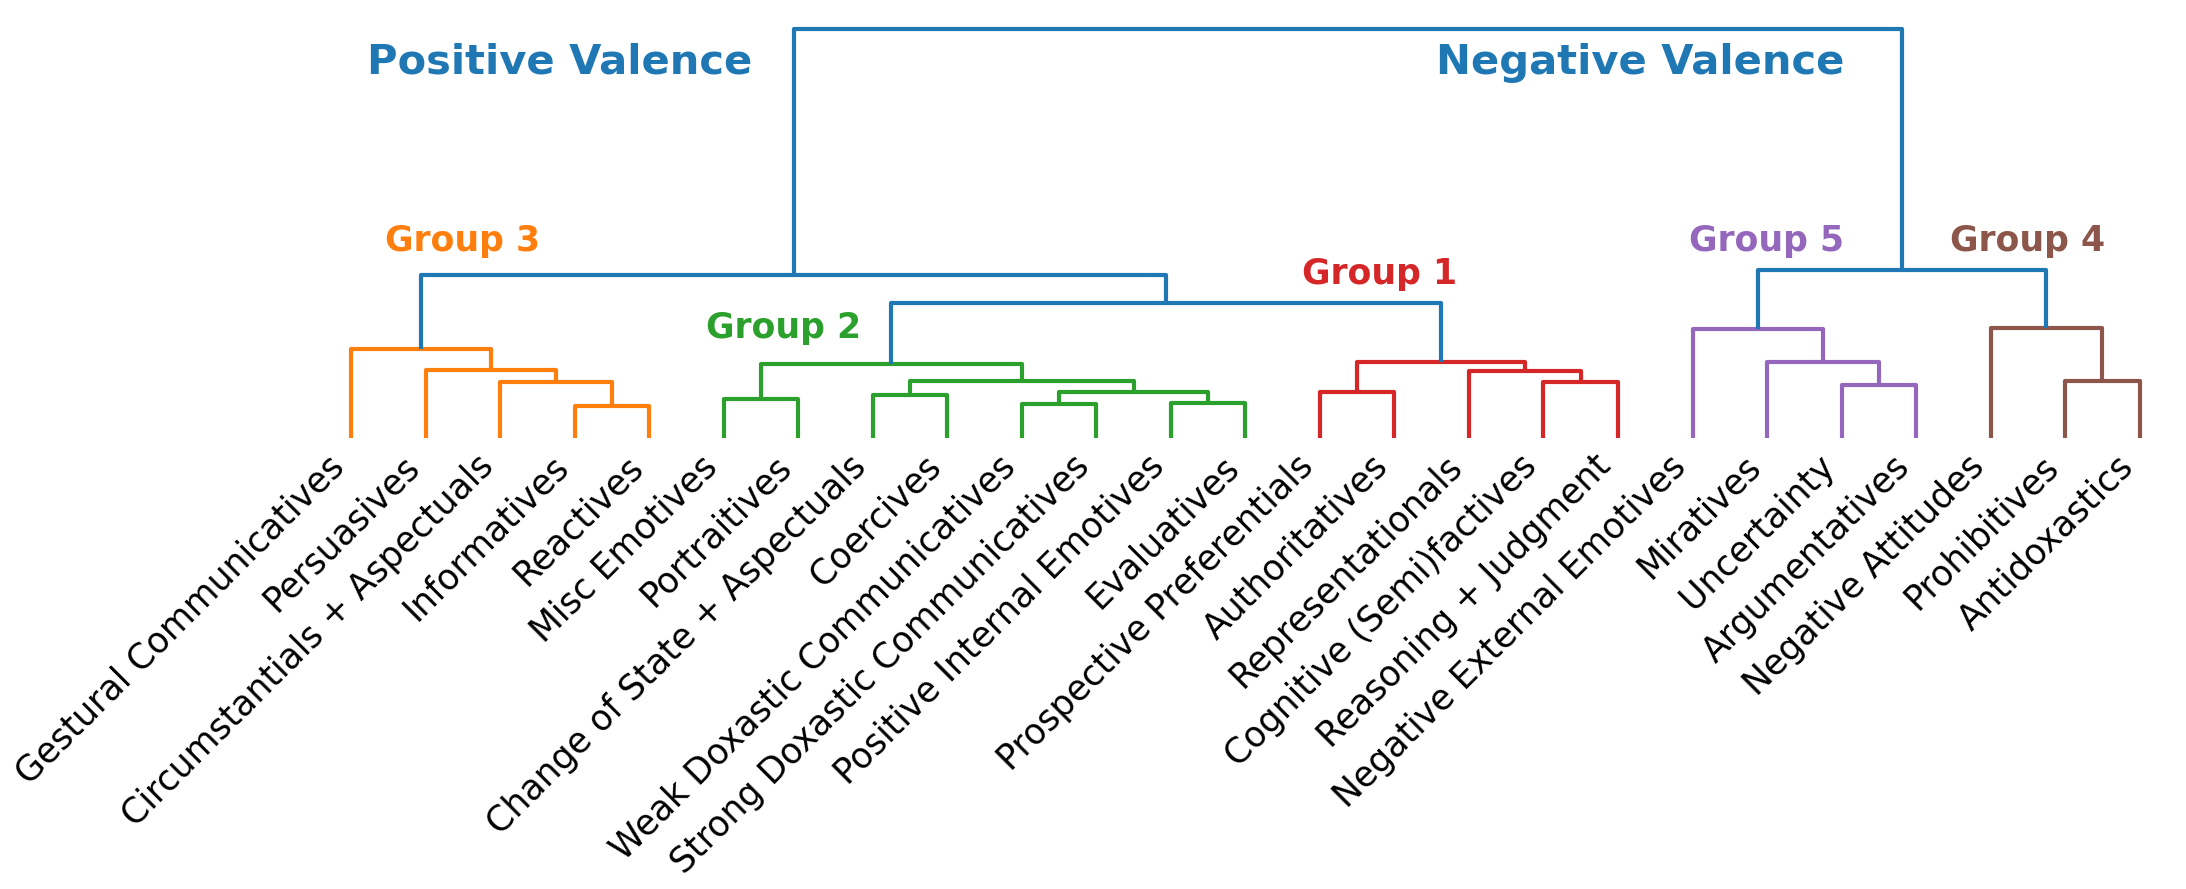

In [61]:
INCLUDE_ANNOTATIONS = True

plt.figure(figsize=(22, 9))
# plt.xlabel('cluster')
# plt.ylabel('distance')
with plt.rc_context({'lines.linewidth': 3}):
    dendrogram(inference_linkage, leaf_rotation=90., leaf_font_size=8.,
               labels=list(cluster_labels.values()),
               # labels=[inference_group_labels[x] for x in inference_groups],
               color_threshold=inference_group_cutoff)
plt.tick_params(axis='x', which='major', labelsize=25)
plt.tick_params(axis='y', which='major', labelsize=15)
plt.xticks(rotation=45, ha='right')

if INCLUDE_ANNOTATIONS:
    annotation_colors = list(mcolors.TABLEAU_COLORS.values())
    annotation_points = {
        1: (20,0.59),
        2: (63,0.35),
        3: (143,0.50),
        4: (195,0.59),
        5: (230,0.59)
    }
    for i in range(1,n_cluster_groups+1):
        plt.annotate(inference_group_labels[i], annotation_points[i], va='top', ha='center', size=25, color=annotation_colors[i], weight='bold')
    plt.annotate('Positive Valence', (33,1), ha='center', size=30, color=annotation_colors[0], weight='bold')
    plt.annotate('Negative Valence', (178,1), ha='center', size=30, color=annotation_colors[0], weight='bold')
    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_yaxis().set_visible(False)

plt.tight_layout()
plt.savefig(f'plots/cluster-dendrogram-{best_n_components}.png', format='png')
plt.savefig(f'plots/cluster-dendrogram-{best_n_components}.pdf', format='pdf')
plt.show()

We label the clusters and groups based on the verbs that fall into them and the inference patterns associated with them.

In [62]:
for group,clusters in group_clusters.items():
    print(f'========== Clusters in group {group} ==========')
    for c in cluster_order:
        if c in clusters:
            print(f'----- Verbs with highest weight for cluster {cluster_labels[c]} -----')
            print('p>0.5', list(best_model['membership_probs'][best_model['membership_probs'][c]>=0.5].head(50).index))
            print('p>0.4', list(best_model['membership_probs'][(best_model['membership_probs'][c]>=0.4) & (best_model['membership_probs'][c]<0.5)].head(50).index))
            print('p>0.3', list(best_model['membership_probs'][(best_model['membership_probs'][c]>=0.3) & (best_model['membership_probs'][c]<0.4)].head(50).index))
            # print('p>0.2', list(best_model['membership_probs'][(best_model['membership_probs'][c]>=0.2) & (best_model['membership_probs'][c]<0.3)].head(50).index))
            print()
    print('\n\n')

========== Clusters in group Group 3 ==========
----- Verbs with highest weight for cluster Gestural Communicatives -----
p>0.5 ['glare', 'grin', 'strut', 'talk']
p>0.4 ['beam', 'feud', 'frown', 'repent', 'scowl', 'smirk', 'snivel', 'sulk', 'wallow', 'wheeze']
p>0.3 ['chime', 'cough', 'cringe', 'listen', 'meditate', 'mope', 'pout', 'rankle', 'sigh']

----- Verbs with highest weight for cluster Persuasives -----
p>0.5 ['hound', 'pester']
p>0.4 ['educate', 'interview']
p>0.3 ['badger', 'brief', 'bug', 'challenge', 'consult', 'correct', 'counsel', 'deceive', 'frighten', 'harass', 'interest', 'misinform', 'mislead', 'pressure', 'probe', 'scare', 'taunt', 'torment']

----- Verbs with highest weight for cluster Circumstantials + Aspectuals -----
p>0.5 ['bury', 'carp', 'come', 'function', 'happen', 'invite', 'punt', 'result', 'skirmish', 'turn_out']
p>0.4 ['bleat', 'bore', 'cloud', 'evidence', 'forgo', 'hire', 'seem', 'shoot', 'sober', 'store', 'taste', 'wound']
p>0.3 ['accredit', 'cease', 'c

We check particular predicates from each cluster identified by Kane et al. (2020), as well as some other predicates that were not included in that work due to being acceptable only in nonfinite frames.

The number of stars indicates the degree of inclusion of each predicate in a particular cluster; 3, 2, and 1 stars correspond to thresholds of 0.4, 0.3, and 0.2, respectively.

In [63]:
# verbs_to_check = {'think', 'know', 'hope', 'wish', 'worry', 'fear', 'like', 'love', 'hate', 'regret', 'pretend', 'doubt', 'reject', 'miss',
#                   'decide', 'choose', 'select', 'remember',
#                   'say', 'tell', 'lie', 'mislead', 'notify', 'convince', 'persuade', 'dupe',
#                   'promise', 'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce'}

verbs_to_check = {
    'representationals':               ['think', 'believe', 'suspect'],
    'speculatives':                    ['venture', 'guess', 'gossip'],
    'future commitment':               ['promise', 'ensure', 'attest'],
    'discourse commitment':            ['maintain', 'remark', 'swear', 'know'],
    'weak communicatives':             ['report', 'remark', 'yelp'],
    'strong communicatives':           ['confess', 'admit', 'acknowledge', 'say', 'tell', 'notify'],
    'deceptives':                      ['lie', 'mislead', 'fake', 'fabricate', 'pretend', 'dupe'],
    'miratives/antidoxastics':         ['surprise', 'stun', 'startle', 'doubt', 'reject', 'miss'],
    'preferentials':                   ['hope', 'wish', 'demand', 'recommend'],
    'negative internal emotives':      ['frighten', 'fear', 'disgust', 'infuriate', 'hate', 'regret'],
    'negative emotive communicatives': ['scream', 'rant', 'growl'],
    'negative external emotives':      ['whine', 'whimper', 'pout', 'worry'],
    'positive external emotives':      ['congratulate', 'praise', 'fascinate'],
    'positive internal emotives':      ['please', 'thrill', 'enthuse', 'like', 'love'],
    'negative emotive miratives':      ['daze', 'fluster', 'alarm'],
    'other (not specified)':           ['decide', 'choose', 'select', 'remember', 'convince', 'persuade',
                                        'use', 'decide', 'choose', 'select', 'make', 'request', 'suggest', 'coerce']
}

for label,verbs in verbs_to_check.items():
    print(f'-- Checking specific examples from Kane et al. 2020: "{label}"')
    for v in verbs:
        print(f'Clusters containing "{v}"')
        for c in cluster_order:
            cluster = cluster_labels[c]
            matches3 = best_model['membership_probs'][(best_model['membership_probs'][c]>=0.4) & (best_model['membership_probs'].index.str.match(v))]
            matches2 = best_model['membership_probs'][(best_model['membership_probs'][c]>=0.3) & (best_model['membership_probs'].index.str.match(v))]
            matches1 = best_model['membership_probs'][(best_model['membership_probs'][c]>=0.2) & (best_model['membership_probs'].index.str.match(v))]
            if len(matches3) > 0:
                print('***', cluster)
            elif len(matches2) > 0:
                print('**', cluster)
            elif len(matches1) > 0:
                print('*', cluster)
        print()
    print('\n\n')

-- Checking specific examples from Kane et al. 2020: "representationals"
Clusters containing "think"
*** Representationals

Clusters containing "believe"
* Authoritatives
* Representationals

Clusters containing "suspect"
* Authoritatives
* Representationals




-- Checking specific examples from Kane et al. 2020: "speculatives"
Clusters containing "venture"
** Reasoning + Judgment

Clusters containing "guess"
** Representationals

Clusters containing "gossip"
** Weak Doxastic Communicatives
* Argumentatives




-- Checking specific examples from Kane et al. 2020: "future commitment"
Clusters containing "promise"
* Informatives
* Strong Doxastic Communicatives
* Representationals

Clusters containing "ensure"
** Strong Doxastic Communicatives
* Reasoning + Judgment

Clusters containing "attest"
* Weak Doxastic Communicatives
** Reasoning + Judgment




-- Checking specific examples from Kane et al. 2020: "discourse commitment"
Clusters containing "maintain"
* Representationals
* Reason

We first plot the means for each cluster averaged across frames, for each inference dataset, as well as the acceptability means for each cluster.

In [64]:
def form_belief_desire_antecedent(row, frame=False, polarity=False):
    positive = not polarity or row.polarity == 'positive'
    if frame:
        antecedent = row.frame.replace(' V ', ' __ ') if positive else row.frame.replace(' V ', ' not __ ')
        antecedent = antecedent.replace('NP', 'A', 1)
        antecedent = antecedent.replace('NP', 'B')
    else:
        # return "____"
        return ""
        # if row.control == 'na':
        #     antecedent = "A __ ((to) B) that S" if positive else "A not __ ((to) B) that S"
        # else:
        #     antecedent = "A __ ((to) B) to VP" if positive else "A not __ ((to) B) to VP"
    return antecedent

In [65]:
def form_negraising_antecedent(row, frame=False, tense=False):
    if frame:
        antecedent = row.frame.replace(' V ', ' not __[past] ') if row.tense == 'past' else row.frame.replace(' V ', ' not __[pres] ')
    else:
        antecedent = 'NP not __[past] NP' if row.tense == 'past' else 'NP not __[pres] NP'
    antecedent = antecedent.replace('NP', 'A[1s]', 1) if row.person == 'first' else antecedent.replace('NP', 'A[3s]', 1)
    antecedent = antecedent.replace('NP', 'B')
    if not tense:
        antecedent = antecedent.replace('[pres]', '').replace('[past]', '')
    return antecedent

In [66]:
def form_veridicality_antecedent(row, frame=False, polarity=False):
    positive = not polarity or row.polarity == 'positive'
    if frame:
        antecedent = row.frame.replace(' V ', ' __ ') if positive else row.frame.replace(' V ', ' not __ ')
        antecedent = antecedent.replace('NP', 'A', 1)
        antecedent = antecedent.replace('NP', 'B')
    else:
        antecedent = 'A __ that/to S/VP' if positive else 'A not __ that/to S/VP'
    return antecedent

In [67]:
def form_acceptability_antecedent(row):
    antecedent = row.frame.replace(' V ', ' __ ')
    antecedent = re.sub(r'V$', '__', antecedent)
    # if row.tense == 'past':
    #     antecedent = antecedent.replace('__', '__[past]')
    # elif row.tense == 'past_progressive':
    #     antecedent = antecedent.replace('__', '__[past-prog]')
    # else:
    #     antecedent = antecedent.replace('__', '__[pres]')
    # antecedent = antecedent.replace('NP', 'A', 1)
    # antecedent = antecedent.replace('NP', 'B')
    return antecedent

In [68]:
CLUSTER_ORDER_L = [cluster_labels[c] for c in cluster_order]

In [69]:
best_belief_desire_means['template'] = best_belief_desire_means.apply(form_belief_desire_antecedent, axis=1) +\
                                       ' ~> ' +\
                                       best_belief_desire_means.target.map({'subject': 'A',
                                                                            'object': 'B'}) + ' ' +\
                                       best_belief_desire_means.consequent_verb + 's ' +\
                                       best_belief_desire_means.control.map({'subject': 'A ',
                                                                             'object': 'B ',
                                                                             'na':''}) +\
                                       best_belief_desire_means.control.map({'subject': 'VP', 'object': 'VP',
                                                                             'na': 'S'})

best_belief_desire_means_melt = pd.melt(best_belief_desire_means.drop(columns=['target', 'control', 'consequent_verb']), 
                                        id_vars=['polarity', 'template'])

best_belief_desire_means_melt['label'] = best_belief_desire_means_melt.variable.map(cluster_labels)
best_belief_desire_means_melt['inferencetype'] = best_belief_desire_means_melt.template.map(lambda x: 'doxastic' if 'believe' in x else 'bouletic' if 'want' in x else 'intention')

best_belief_desire_means_melt

polarity             template variable     value          label   
0    negative      ~> B believes S        0  0.125030  Misc Emotives  \
1    negative         ~> B wants S        0  0.269654  Misc Emotives   
2    negative   ~> B believes B VP        0  0.332409  Misc Emotives   
3    negative    ~> B intends B VP        0  0.250591  Misc Emotives   
4    negative      ~> B wants B VP        0  0.330887  Misc Emotives   
..        ...                  ...      ...       ...            ...   
795  positive    ~> A intends B VP       24  1.000000      Coercives   
796  positive      ~> A wants B VP       24  1.000000      Coercives   
797  positive   ~> A believes A VP       24  0.589975      Coercives   
798  positive    ~> A intends A VP       24  0.916323      Coercives   
799  positive      ~> A wants A VP       24  0.774247      Coercives   

    inferencetype  
0        doxastic  
1        bouletic  
2        doxastic  
3       intention  
4        bouletic  
..            ...  
795     intention  
796      bouletic  
797      doxastic  
798     intention  
799      bouletic  

[800 rows x 6 columns]

In [70]:
best_negraising_means['template'] = best_negraising_means.apply(form_negraising_antecedent, tense=True, axis=1) +\
                                    '~> ' +\
                                    best_negraising_means.person.map({'first': 'A[1s]', 'third': 'A[3s]'}) + ' ' +\
                                    best_negraising_means.tense.map({'past': '__', 'present': '__'}) + ' ' +\
                                    'not S'

best_negraising_means_melt = pd.melt(best_negraising_means.drop(columns=['person']), 
                                       id_vars=['template', 'tense'])

best_negraising_means_melt['label'] = best_negraising_means_melt.variable.map(cluster_labels)

best_negraising_means_melt['inferencetype'] = 'negraising'

best_negraising_means_melt

template    tense variable     value   
0   A[1s] not __[past] B~> A[1s] __ not S     past        0  0.379395  \
1   A[1s] not __[pres] B~> A[1s] __ not S  present        0  0.418367   
2   A[3s] not __[past] B~> A[3s] __ not S     past        0  0.342248   
3   A[3s] not __[pres] B~> A[3s] __ not S  present        0  0.389629   
4   A[1s] not __[past] B~> A[1s] __ not S     past        1  0.643382   
..                                    ...      ...      ...       ...   
95  A[3s] not __[pres] B~> A[3s] __ not S  present       23  0.759959   
96  A[1s] not __[past] B~> A[1s] __ not S     past       24  0.245974   
97  A[1s] not __[pres] B~> A[1s] __ not S  present       24  0.503153   
98  A[3s] not __[past] B~> A[3s] __ not S     past       24  0.162145   
99  A[3s] not __[pres] B~> A[3s] __ not S  present       24  0.630454   

                       label inferencetype  
0              Misc Emotives    negraising  
1              Misc Emotives    negraising  
2              Misc Emotives    negraising  
3              Misc Emotives    negraising  
4   Cognitive (Semi)factives    negraising  
..                       ...           ...  
95            Authoritatives    negraising  
96                 Coercives    negraising  
97                 Coercives    negraising  
98                 Coercives    negraising  
99                 Coercives    negraising  

[100 rows x 6 columns]

In [71]:
best_veridicality_means['template'] = best_veridicality_means.apply(form_veridicality_antecedent, polarity=True, axis=1) +\
                                     ' ~> S/VP'

best_veridicality_means_melt = pd.melt(best_veridicality_means,
                                      id_vars=['polarity', 'template'])

best_veridicality_means_melt['label'] = best_veridicality_means_melt.variable.map(cluster_labels)
best_veridicality_means_melt['inferencetype'] = 'veridicality'

best_veridicality_means_melt.head(5)

polarity                       template variable     value   
0  negative  A not __ that/to S/VP ~> S/VP        0  0.559219  \
1  positive      A __ that/to S/VP ~> S/VP        0  0.529053   
2  negative  A not __ that/to S/VP ~> S/VP        1  0.398328   
3  positive      A __ that/to S/VP ~> S/VP        1  0.751210   
4  negative  A not __ that/to S/VP ~> S/VP        2  0.512048   

                      label inferencetype  
0             Misc Emotives  veridicality  
1             Misc Emotives  veridicality  
2  Cognitive (Semi)factives  veridicality  
3  Cognitive (Semi)factives  veridicality  
4              Prohibitives  veridicality

In [72]:
best_acceptability_locs = best_model['acceptability_value'].copy()

factors = np.array([np.array(x) for x 
                    in best_acceptability_locs.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_acceptability_locs[['tense', 'frame']] = factors
best_acceptability_locs['frame'] = best_acceptability_locs.frame.str.replace('0', '-')

best_acceptability_locs['template'] = best_acceptability_locs.apply(form_acceptability_antecedent, axis=1)

best_acceptability_locs_melt = pd.melt(best_acceptability_locs,
                                       id_vars=['template', 'frame', 'tense'])

best_acceptability_locs_melt['label'] = best_acceptability_locs_melt.variable.map(cluster_labels)
best_acceptability_locs_melt['inferencetype'] = 'acceptability'

best_acceptability_locs_melt

template                       frame    tense   
0                           NP __                        NP V     past  \
1                        NP __ NP                     NP V NP     past   
2                     NP __ NP VP                  NP V NP VP     past   
3                  NP __ NP VPing               NP V NP VPing     past   
4                 NP __ NP that S              NP V NP that S     past   
...                           ...                         ...      ...   
3720  NP be __ whether S[+future]  NP be V whether S[+future]  present   
3721       NP be __ whether to VP       NP be V whether to VP  present   
3722           NP be __ whichNP S           NP be V whichNP S  present   
3723       NP be __ whichNP to VP       NP be V whichNP to VP  present   
3724                      S, I __                      S, I V  present   

     variable     value          label  inferencetype  
0           0  0.101364  Misc Emotives  acceptability  
1           0  0.478653  Misc Emotives  acceptability  
2           0  0.223305  Misc Emotives  acceptability  
3           0  0.199529  Misc Emotives  acceptability  
4           0  0.176727  Misc Emotives  acceptability  
...       ...       ...            ...            ...  
3720       24  0.196312      Coercives  acceptability  
3721       24  0.818471      Coercives  acceptability  
3722       24  0.825244      Coercives  acceptability  
3723       24  0.684862      Coercives  acceptability  
3724       24  0.153521      Coercives  acceptability  

[3725 rows x 7 columns]

In [73]:
# %%R -i best_belief_desire_means_melt -i CLUSTER_ORDER_L -i best_n_components -w 20 -h 9 -u in

# library(tidyverse)

# theme_set(theme_bw())

# # best_belief_desire_means_melt <- filter(best_belief_desire_means_melt, inferencetype=='doxastic')
# best_belief_desire_means_melt$template <- ordered(best_belief_desire_means_melt$template,
#                                                  levels=rev(c(" ~> A believes S", " ~> B believes S", " ~> A believes A VP", " ~> A believes B VP", " ~> B believes A VP", " ~> B believes B VP",
#                                                           " ~> A wants S",    " ~> B wants S",    " ~> A wants A VP",    " ~> A wants B VP",    " ~> B wants A VP",    " ~> B wants B VP",
#                                                           " ~> A intends A VP", " ~> A intends B VP", " ~> B intends A VP", " ~> B intends B VP")))

# best_belief_desire_means_melt$label <- ordered(best_belief_desire_means_melt$label,
#                                                 levels=CLUSTER_ORDER_L)

# best_belief_desire_means_melt$polarity <- factor(best_belief_desire_means_melt$polarity, levels=c("positive", "negative"))

# g = ggplot(best_belief_desire_means_melt, aes(y=template, x=label, fill=value-0.5)) +
# geom_tile(color="white") +
# scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
#                      breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
#                      labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5,
#                      na.value = "transparent") +
# facet_wrap(best_belief_desire_means_melt$polarity,
#            labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#            scales = "free") +
# theme(axis.text=element_text(size=10, color="black"),
#       axis.text.x=element_text(size=12, angle=45, hjust=1),
#       axis.title=element_blank(),
#       legend.title=element_text(size=15, face="bold"),
#       legend.text=element_text(size=10),
#       panel.background=element_blank(),
#       panel.spacing.x = unit(2, "lines"),
#       panel.spacing.y = unit(1, "lines"),
#       plot.background=element_blank(),
#       strip.background=element_rect(fill="white", color="white"),
#       strip.text=element_text(size=15, face="bold"),
#       strip.clip = "off",
#       plot.margin=unit(c(0,0,0,2),"cm")
# )


# ggsave(sprintf('plots/intensional-loadings-means-%s.pdf', best_n_components), width=20, height=9, limitsize=FALSE)
# ggsave(sprintf('plots/intensional-loadings-means-%s.png', best_n_components), width=20, height=9, limitsize=FALSE)

# g

In [74]:
# %%R -i best_negraising_means_melt -i CLUSTER_ORDER_L -i best_n_components -w 20 -h 3.5 -u in

# library(tidyverse)

# theme_set(theme_bw())

# best_negraising_means_melt$label <- ordered(best_negraising_means_melt$label,
#                                            levels=CLUSTER_ORDER_L)

# best_negraising_means_melt$template <- factor(best_negraising_means_melt$template)
# best_negraising_means_melt$tense <- factor(best_negraising_means_melt$tense, levels=c("past", "present"))

# g = ggplot(best_negraising_means_melt, aes(y=template, x=label, fill=value-0.5)) +
# geom_tile(color="white") +
# scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
#                      breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
#                      labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5,
#                      na.value = "transparent") +
# theme(axis.text=element_text(size=10, color="black"),
#       axis.text.x=element_text(size=12, angle=45, hjust=1),
#       axis.title=element_blank(),
#       legend.title=element_text(size=15, face="bold"),
#       legend.text=element_text(size=10),
#       panel.background=element_blank(),
#       panel.spacing.x = unit(2, "lines"),
#       panel.spacing.y = unit(1, "lines"),
#       plot.background=element_blank(),
#       strip.background=element_rect(fill="white", color="white"),
#       strip.text=element_text(size=15, face="bold"),
#       strip.clip = "off",
#       plot.margin=unit(c(0,0,0,2),"cm")
# )

# ggsave(sprintf('plots/negraising-loadings-means-%s.pdf', best_n_components), width=20, height=3.5, limitsize=FALSE)
# ggsave(sprintf('plots/negraising-loadings-means-%s.png', best_n_components), width=20, height=3.5, limitsize=FALSE)

# g

In [75]:
# %%R -i best_veridicality_means_melt -i CLUSTER_ORDER_L -i best_n_components -w 20 -h 3 -u in

# library(tidyverse)

# theme_set(theme_bw())

# best_veridicality_means_melt$label <- ordered(best_veridicality_means_melt$label,
#                                              levels=CLUSTER_ORDER_L)

# best_veridicality_means_melt$polarity <- factor(best_veridicality_means_melt$polarity, levels=c("positive", "negative"))

# g = ggplot(best_veridicality_means_melt, aes(y=template, x=label, fill=value-0.5)) +
# geom_tile(color="white") +
# scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
#                      breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
#                      labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
#                      na.value = "transparent") +
# theme(axis.text=element_text(size=10, color="black"),
#       axis.text.x=element_text(size=12, angle=45, hjust=1),
#       axis.title=element_blank(),
#       legend.title=element_text(size=15, face="bold"),
#       legend.text=element_text(size=10),
#       panel.background=element_blank(),
#       panel.spacing.x = unit(2, "lines"),
#       panel.spacing.y = unit(1, "lines"),
#       plot.background=element_blank(),
#       strip.background=element_rect(fill="white", color="white"),
#       strip.text=element_text(size=15, face="bold"),
#       strip.clip = "off",
#       plot.margin=unit(c(0,0,0,2),"cm")
# )

# ggsave(sprintf('plots/veridicality-loadings-means-%s.pdf', best_n_components), width=20, height=3, limitsize=FALSE)
# ggsave(sprintf('plots/veridicality-loadings-means-%s.png', best_n_components), width=20, height=3, limitsize=FALSE)

# g

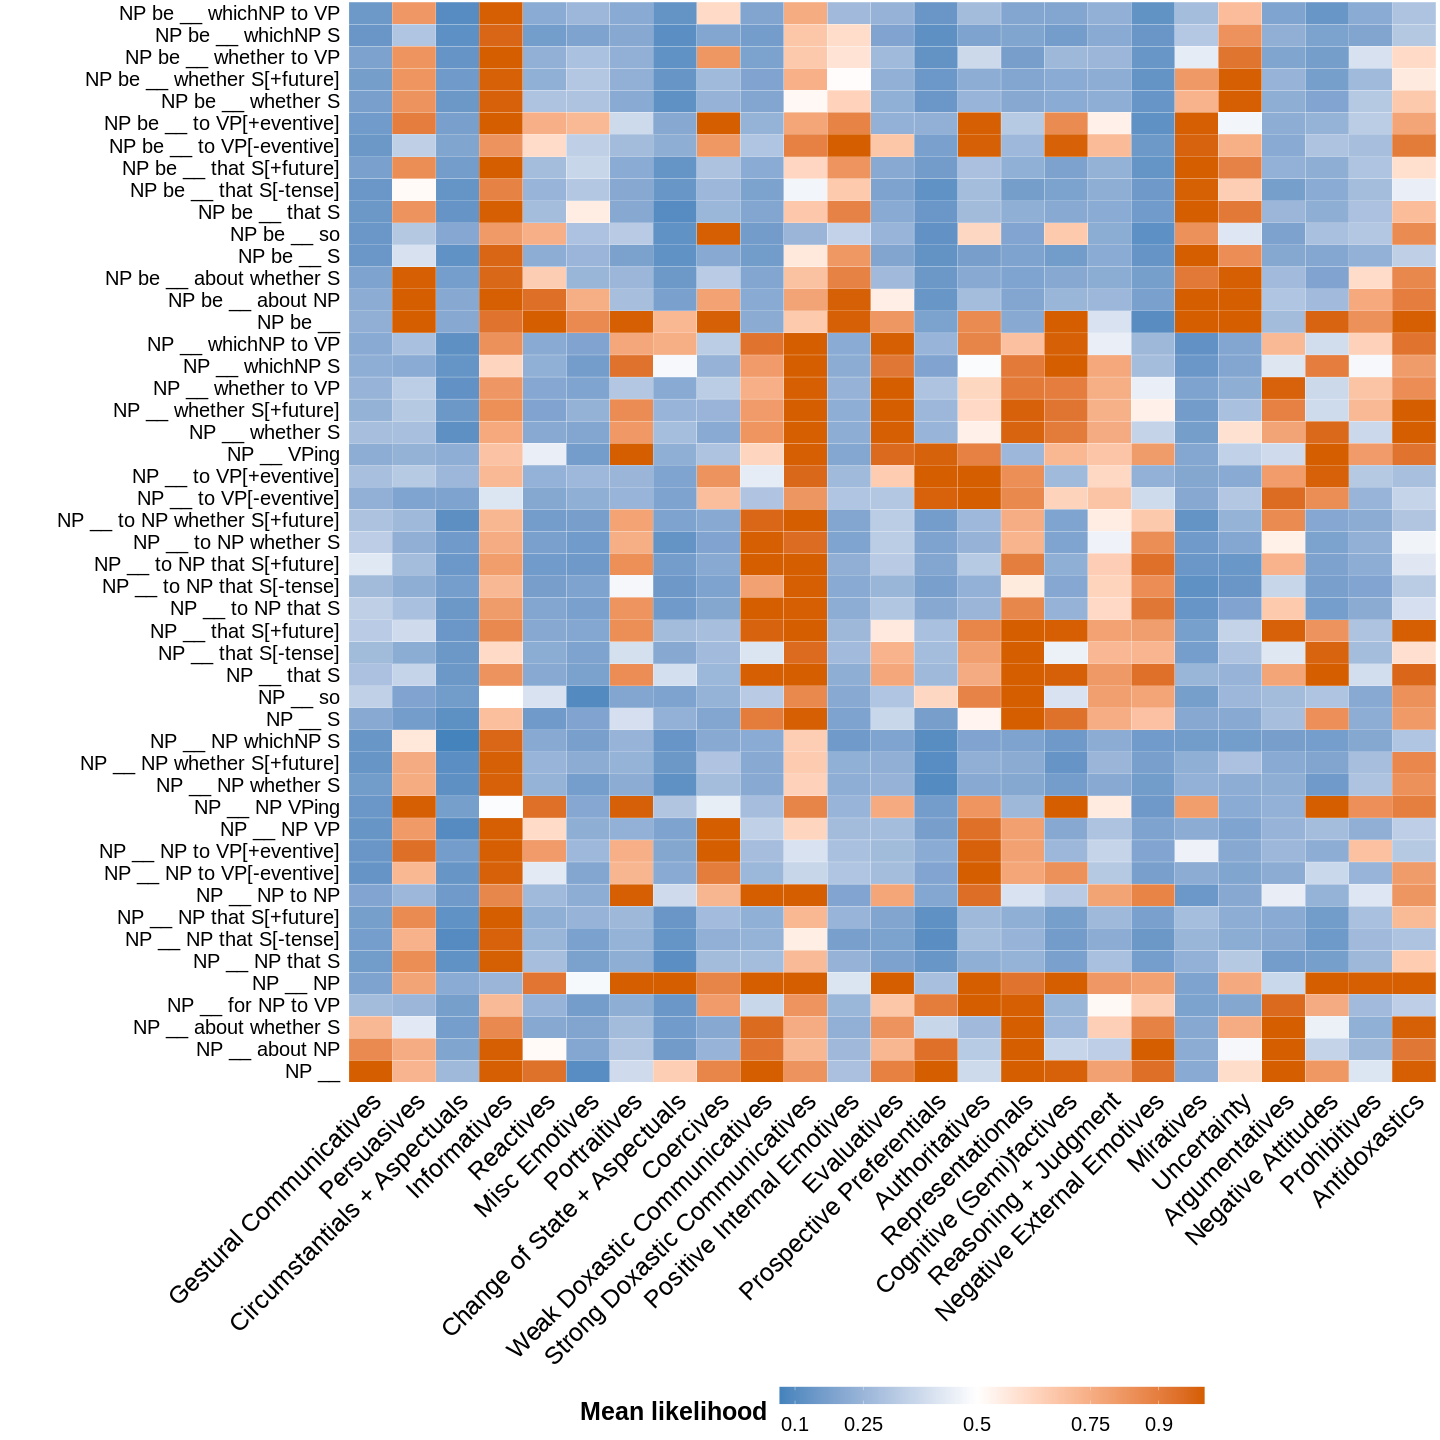

In [76]:
%%R -i best_acceptability_locs_melt -i CLUSTER_ORDER_L -i best_n_components -w 20 -h 20 -u in

library(tidyverse)

theme_set(theme_bw())

best_acceptability_locs_melt <- filter(best_acceptability_locs_melt, tense=='past')

best_acceptability_locs_melt$label <- ordered(best_acceptability_locs_melt$label,
                                              levels=CLUSTER_ORDER_L)

g = ggplot(best_acceptability_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                     na.value = "transparent") +
theme(axis.text=element_text(size=20, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave(sprintf('plots/acceptability-loadings-past-%s.pdf', best_n_components), width=20, height=20)
ggsave(sprintf('plots/acceptability-loadings-past-%s.png', best_n_components), width=20, height=20)

g

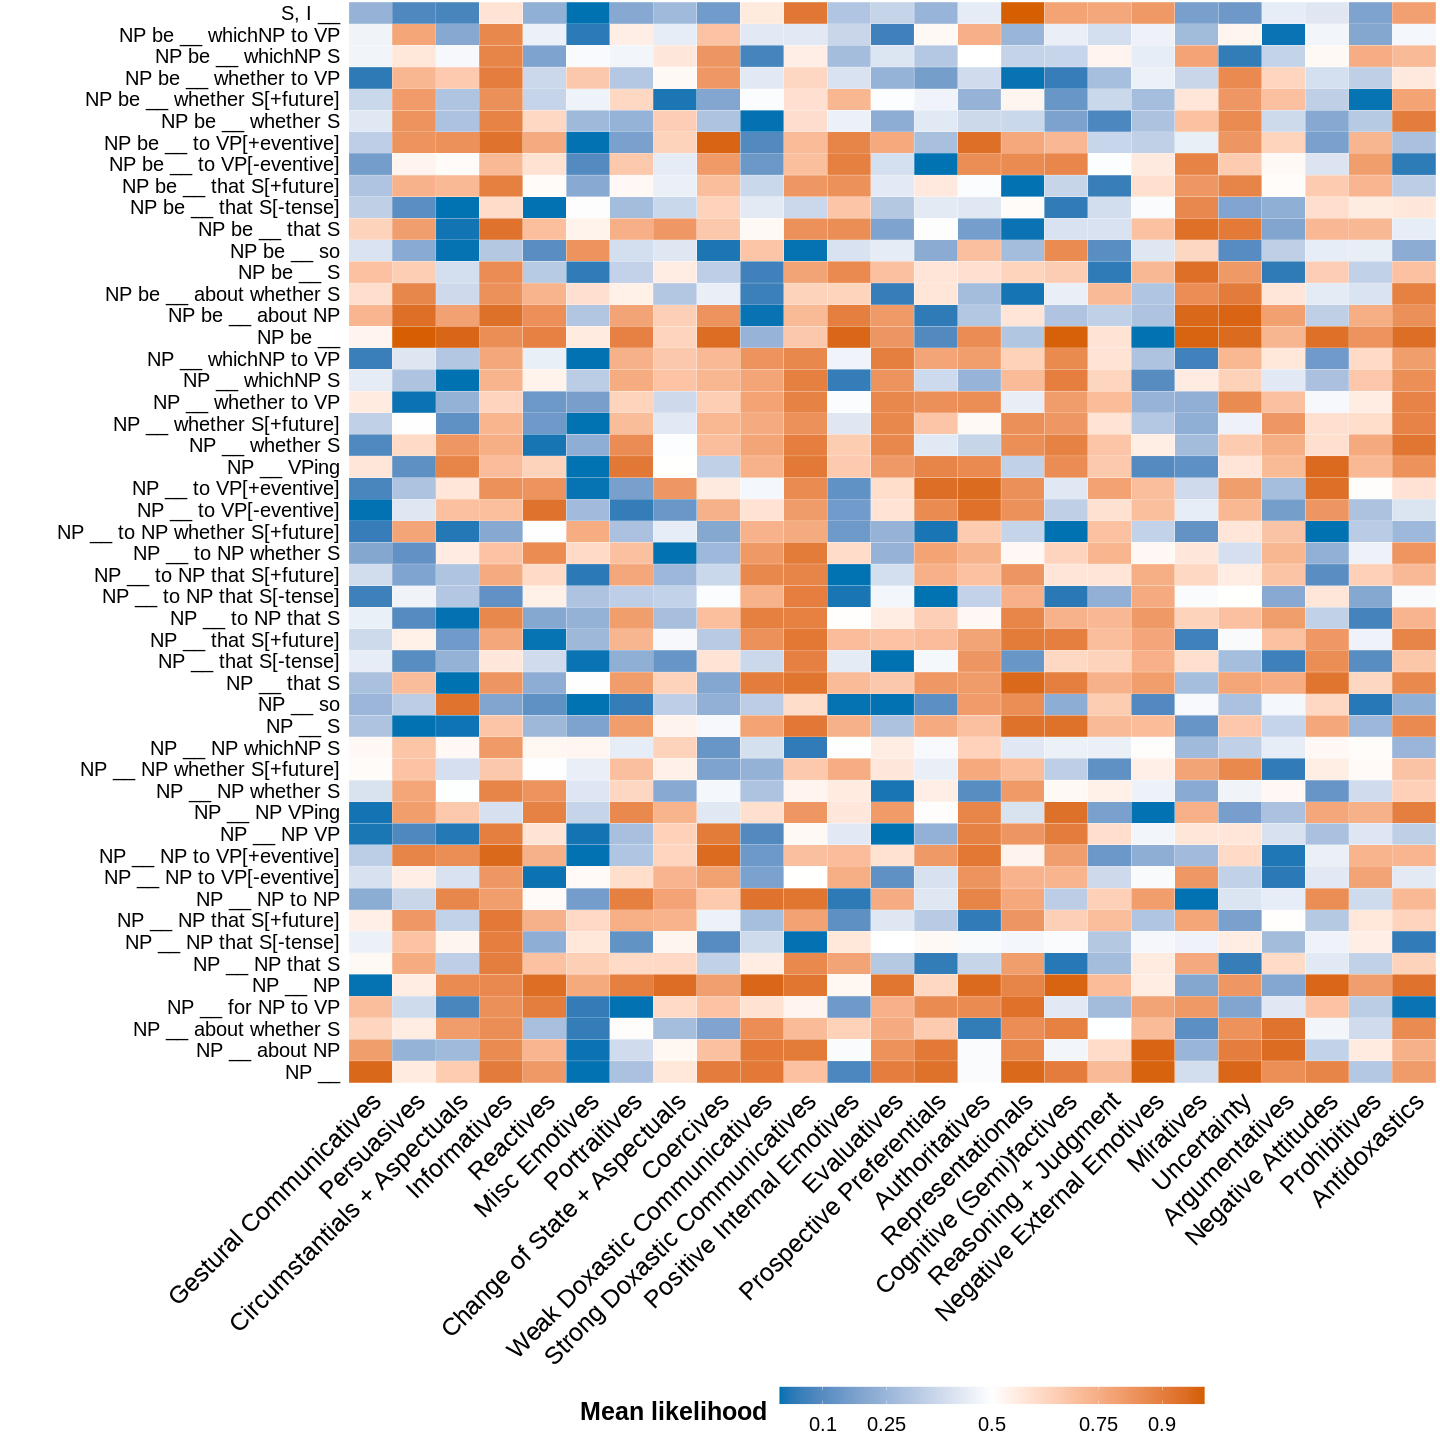

In [77]:
%%R -i best_acceptability_locs_melt -i CLUSTER_ORDER_L -i best_n_components -w 20 -h 20 -u in

library(tidyverse)

theme_set(theme_bw())

best_acceptability_locs_melt <- filter(best_acceptability_locs_melt, tense=='present')

best_acceptability_locs_melt$label <- ordered(best_acceptability_locs_melt$label,
                                              levels=CLUSTER_ORDER_L)

g = ggplot(best_acceptability_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                     na.value = "transparent") +
theme(axis.text=element_text(size=20, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave(sprintf('plots/acceptability-loadings-present-%s.pdf', best_n_components), width=20, height=20)
ggsave(sprintf('plots/acceptability-loadings-present-%s.png', best_n_components), width=20, height=20)

g

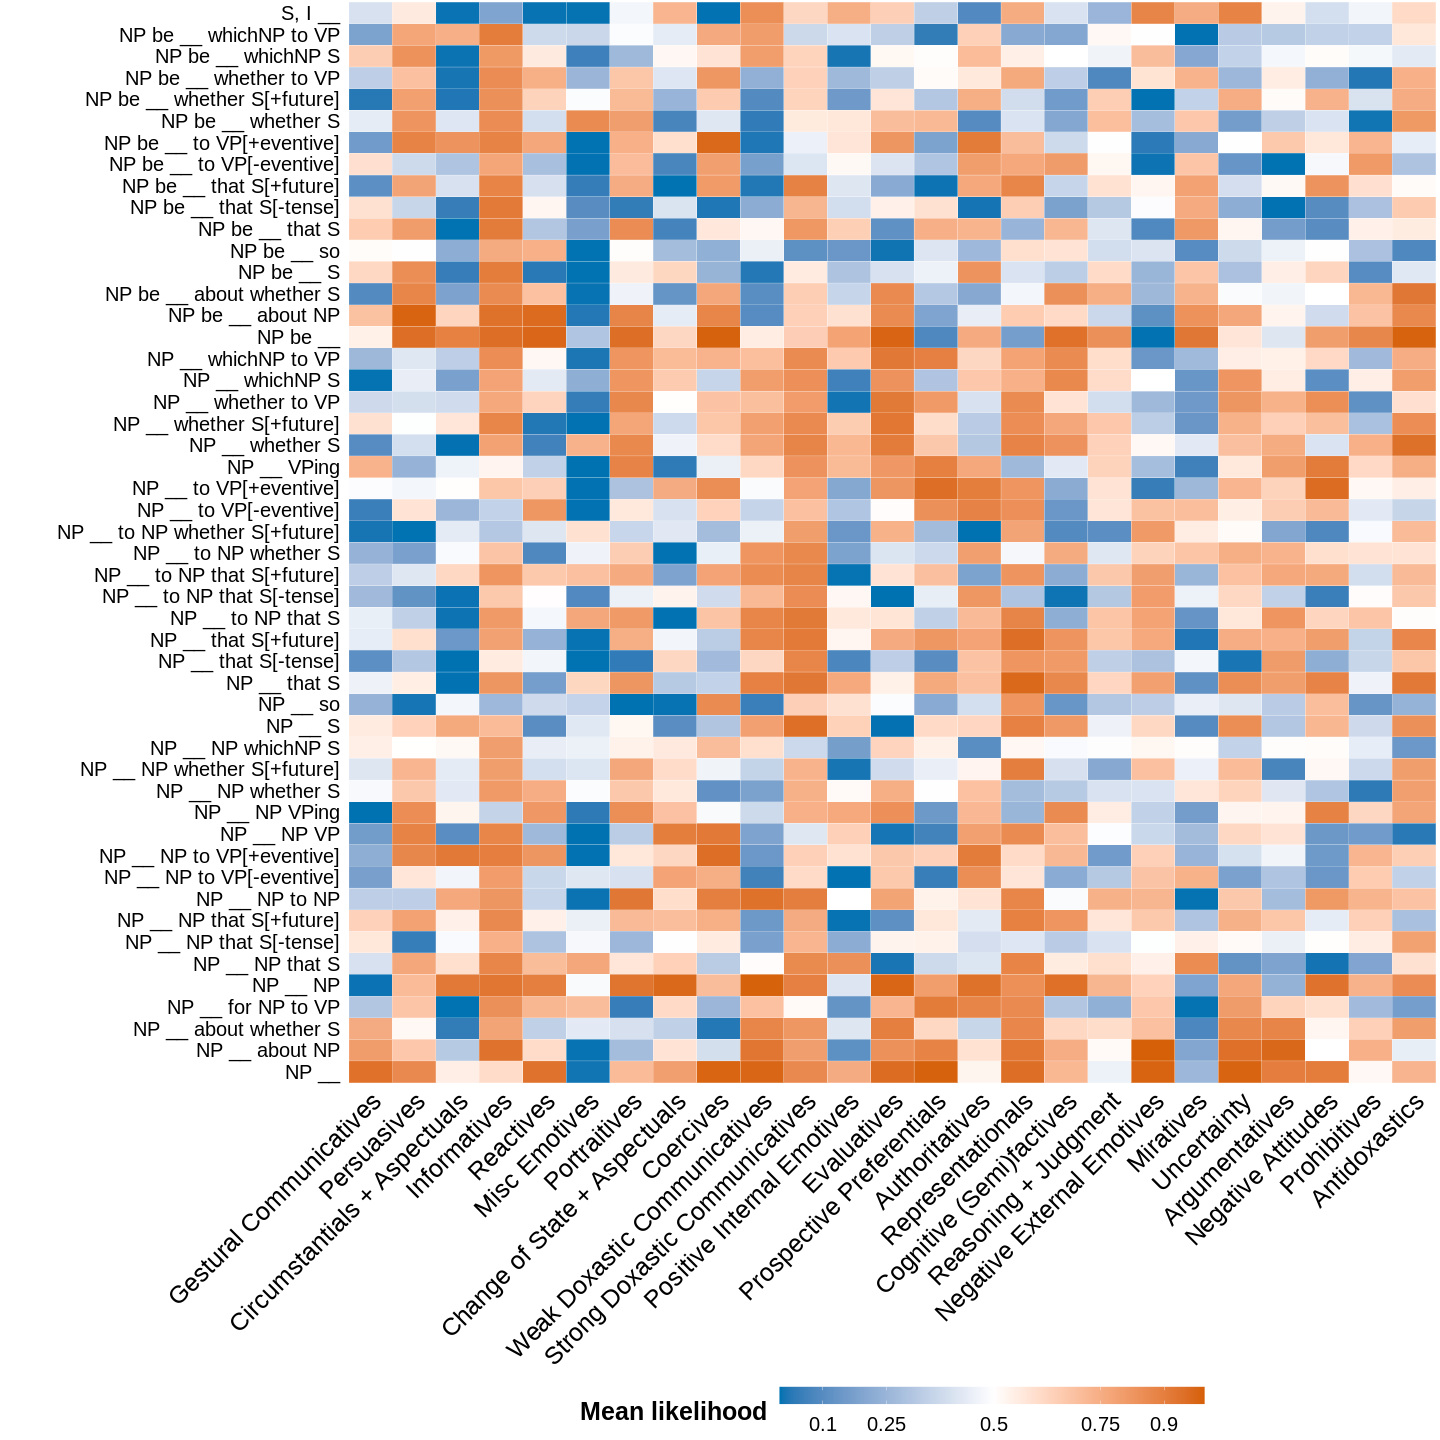

In [78]:
%%R -i best_acceptability_locs_melt -i CLUSTER_ORDER_L -i best_n_components -w 20 -h 20 -u in

library(tidyverse)

theme_set(theme_bw())

best_acceptability_locs_melt <- filter(best_acceptability_locs_melt, tense=='past_progressive')

best_acceptability_locs_melt$label <- ordered(best_acceptability_locs_melt$label,
                                              levels=CLUSTER_ORDER_L)

g = ggplot(best_acceptability_locs_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                     na.value = "transparent") +
theme(axis.text=element_text(size=20, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave(sprintf('plots/acceptability-loadings-past-progressive-%s.pdf', best_n_components), width=20, height=20)
ggsave(sprintf('plots/acceptability-loadings-past-progressive-%s.png', best_n_components), width=20, height=20)

g

We then plot the means for each cluster, both disaggregated by frame and aggregated across frames, for each inference dataset. However, to reduce noise, we filter out judgments for frames with a low acceptability for each cluster in the former case, and take a weighted average in the latter case.

In [79]:
best_belief_desire_locs = best_model['belief_desire_value'].copy()

factors = np.array([np.array(x) for x 
                    in best_belief_desire_locs.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_belief_desire_locs[['polarity', 'target', 'control', 'consequent_verb', 'frame']] = factors
best_belief_desire_locs['frame'] = best_belief_desire_locs.frame.str.replace('0', '-')
best_belief_desire_locs['tense'] = 'past'

# best_belief_desire_locs = best_belief_desire_locs.pivot_table(values=range(0, best_n_components), index=['polarity', 'target', 'control', 'consequent_verb']).reset_index()

best_belief_desire_locs['template'] = best_belief_desire_locs.apply(form_belief_desire_antecedent, axis=1) +\
                                      ' ~> ' +\
                                      best_belief_desire_locs.target.map({'subject': 'A',
                                                                          'object': 'B'}) + ' ' +\
                                      best_belief_desire_locs.consequent_verb + 's ' +\
                                      best_belief_desire_locs.control.map({'subject': 'A ',
                                                                          'object': 'B ',
                                                                          'na':''}) +\
                                      best_belief_desire_locs.control.map({'subject': 'VP', 'object': 'VP',
                                                                           'na': 'S'})

# best_belief_desire_locs_melt = pd.melt(best_belief_desire_locs.drop(columns=['target', 'control', 'consequent_verb', 'frame']), 
#                                        id_vars=['polarity', 'template'])
# best_belief_desire_locs_melt = pd.melt(best_belief_desire_locs.drop(columns=['target', 'control', 'consequent_verb']), 
#                                        id_vars=['polarity', 'template'])
best_belief_desire_locs_melt = pd.melt(best_belief_desire_locs.drop(columns=['target', 'control', 'consequent_verb']), 
                                       id_vars=['polarity', 'template', 'frame', 'tense'])

# best_belief_desire_locs_melt = best_belief_desire_locs_melt.drop(columns='polarity')

best_belief_desire_locs_melt['label'] = best_belief_desire_locs_melt.variable.map(cluster_labels)
best_belief_desire_locs_melt['inferencetype'] = best_belief_desire_locs_melt.template.map(lambda x: 'doxastic' if 'believe' in x else 'bouletic' if 'want' in x else 'intention')

best_belief_desire_locs_melt

polarity          template                        frame tense variable   
0     negative   ~> B believes S               NP V NP that S  past        0  \
1     negative   ~> B believes S      NP V NP that S[+future]  past        0   
2     negative   ~> B believes S       NP V NP that S[-tense]  past        0   
3     negative   ~> B believes S            NP V to NP that S  past        0   
4     negative   ~> B believes S   NP V to NP that S[+future]  past        0   
...        ...               ...                          ...   ...      ...   
4795  positive   ~> A wants A VP                   NP V VPing  past       24   
4796  positive   ~> A wants A VP  NP V to NP to VP[+eventive]  past       24   
4797  positive   ~> A wants A VP  NP V to NP to VP[-eventive]  past       24   
4798  positive   ~> A wants A VP        NP V to VP[+eventive]  past       24   
4799  positive   ~> A wants A VP        NP V to VP[-eventive]  past       24   

             value          label inferencetype  
0     1.203852e-07  Misc Emotives      doxastic  
1     4.475707e-16  Misc Emotives      doxastic  
2     3.443536e-21  Misc Emotives      doxastic  
3     1.727431e-38  Misc Emotives      doxastic  
4     1.125075e-37  Misc Emotives      doxastic  
...            ...            ...           ...  
4795  1.000000e+00      Coercives      bouletic  
4796  9.778080e-01      Coercives      bouletic  
4797  6.676690e-01      Coercives      bouletic  
4798  1.000000e+00      Coercives      bouletic  
4799  1.000000e+00      Coercives      bouletic  

[4800 rows x 8 columns]

In [80]:
best_negraising_locs = best_model['negraising_value'].copy()

factors = np.array([np.array(x) for x 
                    in best_negraising_locs.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_negraising_locs[['person', 'tense', 'frame']] = factors
best_negraising_locs['frame'] = best_negraising_locs.frame.str.replace('0', '-')

# best_negraising_locs = best_negraising_locs.pivot_table(values=range(0, best_n_components), index=['person', 'tense']).reset_index()

best_negraising_locs['template'] = best_negraising_locs.apply(form_negraising_antecedent, axis=1) +\
                                   '~> ' +\
                                   best_negraising_locs.person.map({'first': 'A[1s]', 'third': 'A[3s]'}) + ' ' +\
                                   best_negraising_locs.tense.map({'past': '__', 'present': '__'}) + ' ' +\
                                   'not S'

# best_negraising_locs_melt = pd.melt(best_negraising_locs.drop(columns=['person', 'tense', 'frame']), 
#                                        id_vars='template')
# best_negraising_locs_melt = pd.melt(best_negraising_locs.drop(columns=['person', 'tense']), 
#                                        id_vars='template')
best_negraising_locs_melt = pd.melt(best_negraising_locs.drop(columns=['person']), 
                                       id_vars=['template', 'frame', 'tense'])

best_negraising_locs_melt['label'] = best_negraising_locs_melt.variable.map(cluster_labels)

best_negraising_locs_melt['inferencetype'] = 'negraising'

best_negraising_locs_melt

template                     frame    tense   
0    A[1s] not __ B~> A[1s] __ not S               NP V that S     past  \
1    A[1s] not __ B~> A[1s] __ not S     NP V to VP[+eventive]     past   
2    A[1s] not __ B~> A[1s] __ not S     NP V to VP[-eventive]     past   
3    A[1s] not __ B~> A[1s] __ not S            NP be V that S     past   
4    A[1s] not __ B~> A[1s] __ not S  NP be V to VP[+eventive]     past   
..                               ...                       ...      ...   
595  A[3s] not __ B~> A[3s] __ not S     NP V to VP[+eventive]  present   
596  A[3s] not __ B~> A[3s] __ not S     NP V to VP[-eventive]  present   
597  A[3s] not __ B~> A[3s] __ not S            NP be V that S  present   
598  A[3s] not __ B~> A[3s] __ not S  NP be V to VP[+eventive]  present   
599  A[3s] not __ B~> A[3s] __ not S  NP be V to VP[-eventive]  present   

    variable         value          label inferencetype  
0          0  8.666409e-08  Misc Emotives    negraising  
1          0  7.583328e-01  Misc Emotives    negraising  
2          0  9.999993e-01  Misc Emotives    negraising  
3          0  3.690169e-09  Misc Emotives    negraising  
4          0  1.786571e-20  Misc Emotives    negraising  
..       ...           ...            ...           ...  
595       24  1.000000e+00      Coercives    negraising  
596       24  8.031680e-01      Coercives    negraising  
597       24  3.809858e-14      Coercives    negraising  
598       24  6.489601e-11      Coercives    negraising  
599       24  9.997603e-01      Coercives    negraising  

[600 rows x 7 columns]

In [81]:
best_veridicality_locs = best_model['veridicality_value'].copy()

factors = np.array([np.array(x) for x 
                    in best_veridicality_locs.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

best_veridicality_locs[['polarity', 'frame']] = factors
best_veridicality_locs['frame'] = best_veridicality_locs.frame.str.replace('0', '-')
best_veridicality_locs['tense'] = 'past'

# best_veridicality_locs = best_veridicality_locs.pivot_table(values=range(0, best_n_components), index=['polarity']).reset_index()

best_veridicality_locs['template'] = best_veridicality_locs.apply(form_veridicality_antecedent, axis=1) +\
                                     ' ~> S/VP'

# best_veridicality_locs_melt = pd.melt(best_veridicality_locs.drop(columns=['frame']), 
#                                        id_vars=['polarity', 'template'])
# best_veridicality_locs_melt = pd.melt(best_veridicality_locs, id_vars=['polarity', 'template'])
best_veridicality_locs_melt = pd.melt(best_veridicality_locs,
                                      id_vars=['polarity', 'template', 'frame', 'tense'])

# best_veridicality_locs_melt = best_veridicality_locs_melt.drop(columns='polarity')

best_veridicality_locs_melt['label'] = best_veridicality_locs_melt.variable.map(cluster_labels)
best_veridicality_locs_melt['inferencetype'] = 'veridicality'

best_veridicality_locs_melt

polarity                   template                     frame tense   
0    negative  A __ that/to S/VP ~> S/VP  NP V NP to VP[+eventive]  past  \
1    negative  A __ that/to S/VP ~> S/VP  NP V NP to VP[-eventive]  past   
2    negative  A __ that/to S/VP ~> S/VP         NP V for NP to VP  past   
3    negative  A __ that/to S/VP ~> S/VP               NP V that S  past   
4    negative  A __ that/to S/VP ~> S/VP     NP V to VP[+eventive]  past   
..        ...                        ...                       ...   ...   
445  positive  A __ that/to S/VP ~> S/VP     NP V to VP[+eventive]  past   
446  positive  A __ that/to S/VP ~> S/VP     NP V to VP[-eventive]  past   
447  positive  A __ that/to S/VP ~> S/VP            NP be V that S  past   
448  positive  A __ that/to S/VP ~> S/VP  NP be V to VP[+eventive]  past   
449  positive  A __ that/to S/VP ~> S/VP  NP be V to VP[-eventive]  past   

    variable     value          label inferencetype  
0          0  0.337051  Misc Emotives  veridicality  
1          0  0.426950  Misc Emotives  veridicality  
2          0  0.985277  Misc Emotives  veridicality  
3          0  0.400155  Misc Emotives  veridicality  
4          0  0.975738  Misc Emotives  veridicality  
..       ...       ...            ...           ...  
445       24  0.994680      Coercives  veridicality  
446       24  0.988178      Coercives  veridicality  
447       24  0.098884      Coercives  veridicality  
448       24  0.997223      Coercives  veridicality  
449       24  0.991240      Coercives  veridicality  

[450 rows x 8 columns]

In order to make the inference plots more interpretable, we mask out inferences for frames in clusters which contain predicates that are not acceptable in that frame. We do this by weighting each response by the normalized rank of the acceptability of that frame (e.g., an inference in a cluster+frame where that frame has a median acceptability would get weighted by 0.5).

(NOTE: since `NP V to NP to VP` frames are missing in MegaAcceptability, we impute those as the minimum of `NP V to NP that S` and `NP V to VP`).

In [82]:
best_acceptability_locs_melt['rank'] = best_acceptability_locs_melt.value.rank(method='dense', pct=True)

best_acceptability_locs_melt

template                       frame    tense   
0                           NP __                        NP V     past  \
1                        NP __ NP                     NP V NP     past   
2                     NP __ NP VP                  NP V NP VP     past   
3                  NP __ NP VPing               NP V NP VPing     past   
4                 NP __ NP that S              NP V NP that S     past   
...                           ...                         ...      ...   
3720  NP be __ whether S[+future]  NP be V whether S[+future]  present   
3721       NP be __ whether to VP       NP be V whether to VP  present   
3722           NP be __ whichNP S           NP be V whichNP S  present   
3723       NP be __ whichNP to VP       NP be V whichNP to VP  present   
3724                      S, I __                      S, I V  present   

     variable     value          label  inferencetype      rank  
0           0  0.101364  Misc Emotives  acceptability  0.069530  
1           0  0.478653  Misc Emotives  acceptability  0.490470  
2           0  0.223305  Misc Emotives  acceptability  0.231946  
3           0  0.199529  Misc Emotives  acceptability  0.190067  
4           0  0.176727  Misc Emotives  acceptability  0.151141  
...       ...       ...            ...            ...       ...  
3720       24  0.196312      Coercives  acceptability  0.184161  
3721       24  0.818471      Coercives  acceptability  0.811275  
3722       24  0.825244      Coercives  acceptability  0.821208  
3723       24  0.684862      Coercives  acceptability  0.666309  
3724       24  0.153521      Coercives  acceptability  0.121074  

[3725 rows x 8 columns]

In [83]:
def impute_missing_rank(df, row):
    if not pd.isna(row['rank']):
        return row['rank']
    else:
        eventivity = '[+eventive]' if '[+eventive]' in row['frame'] else '[-eventive]'
        np_v_to_np_that_s = df[(df['frame'] == 'NP V to NP that S') &
                               (df['tense'] == row['tense']) &
                               (df['variable'] == row['variable'])]['rank'].iloc[0]
        np_v_to_vp = df[(df['frame'] == 'NP V to VP'+eventivity) &
                        (df['tense'] == row['tense']) &
                        (df['variable'] == row['variable'])]['rank'].iloc[0]
        return min(np_v_to_np_that_s, np_v_to_vp)

In [84]:
RANK_THRESHOLD = 0.25

In [85]:
best_belief_desire_locs_w_melt = best_belief_desire_locs_melt.merge(best_acceptability_locs_melt,
                                                                    how='left', on=['frame', 'tense', 'variable', 'label'],
                                                                    suffixes=(None, '_dup')) \
                                                             .drop(columns=['template_dup', 'inferencetype_dup', 'value_dup']).reset_index()

best_belief_desire_locs_w_melt['rank'] = best_belief_desire_locs_w_melt.apply(lambda row: impute_missing_rank(best_acceptability_locs_melt, row), axis=1)

# best_belief_desire_locs_w_melt['value_w'] = best_belief_desire_locs_w_melt['value'] * best_belief_desire_locs_w_melt['rank']
best_belief_desire_locs_w_melt['value_w'] = np.where(best_belief_desire_locs_w_melt['rank']>=RANK_THRESHOLD, best_belief_desire_locs_w_melt['value'], np.nan)
# best_belief_desire_locs_w_melt = best_belief_desire_locs_w_melt.query("rank >= 0.75")

best_belief_desire_locs_w_melt

index  polarity          template                        frame tense   
0         0  negative   ~> B believes S               NP V NP that S  past  \
1         1  negative   ~> B believes S      NP V NP that S[+future]  past   
2         2  negative   ~> B believes S       NP V NP that S[-tense]  past   
3         3  negative   ~> B believes S            NP V to NP that S  past   
4         4  negative   ~> B believes S   NP V to NP that S[+future]  past   
...     ...       ...               ...                          ...   ...   
4795   4795  positive   ~> A wants A VP                   NP V VPing  past   
4796   4796  positive   ~> A wants A VP  NP V to NP to VP[+eventive]  past   
4797   4797  positive   ~> A wants A VP  NP V to NP to VP[-eventive]  past   
4798   4798  positive   ~> A wants A VP        NP V to VP[+eventive]  past   
4799   4799  positive   ~> A wants A VP        NP V to VP[-eventive]  past   

     variable         value          label inferencetype      rank   
0           0  1.203852e-07  Misc Emotives      doxastic  0.151141  \
1           0  4.475707e-16  Misc Emotives      doxastic  0.262819   
2           0  3.443536e-21  Misc Emotives      doxastic  0.152752   
3           0  1.727431e-38  Misc Emotives      doxastic  0.147114   
4           0  1.125075e-37  Misc Emotives      doxastic  0.116242   
...       ...           ...            ...           ...       ...   
4795       24  1.000000e+00      Coercives      bouletic  0.331275   
4796       24  9.778080e-01      Coercives      bouletic  0.186309   
4797       24  6.676690e-01      Coercives      bouletic  0.186309   
4798       24  1.000000e+00      Coercives      bouletic  0.834094   
4799       24  1.000000e+00      Coercives      bouletic  0.684564   

           value_w  
0              NaN  
1     4.475707e-16  
2              NaN  
3              NaN  
4              NaN  
...            ...  
4795  1.000000e+00  
4796           NaN  
4797           NaN  
4798  1.000000e+00  
4799  1.000000e+00  

[4800 rows x 11 columns]

In [86]:
best_negraising_locs_w_melt = best_negraising_locs_melt.merge(best_acceptability_locs_melt,
                                                              how='left', on=['frame', 'tense', 'variable', 'label'],
                                                              suffixes=(None, '_dup')) \
                                                       .drop(columns=['template_dup', 'inferencetype_dup', 'value_dup']).reset_index()

best_negraising_locs_w_melt['rank'] = best_negraising_locs_w_melt.apply(lambda row: impute_missing_rank(best_acceptability_locs_melt, row), axis=1)

# best_negraising_locs_w_melt['value_w'] = best_negraising_locs_w_melt['value'] * best_negraising_locs_w_melt['rank']
best_negraising_locs_w_melt['value_w'] = np.where(best_negraising_locs_w_melt['rank']>=RANK_THRESHOLD, best_negraising_locs_w_melt['value'], np.nan)
# best_negraising_locs_w_melt = best_negraising_locs_w_melt.query("rank >= 0.75")

best_negraising_locs_w_melt

index                         template                     frame   
0        0  A[1s] not __ B~> A[1s] __ not S               NP V that S  \
1        1  A[1s] not __ B~> A[1s] __ not S     NP V to VP[+eventive]   
2        2  A[1s] not __ B~> A[1s] __ not S     NP V to VP[-eventive]   
3        3  A[1s] not __ B~> A[1s] __ not S            NP be V that S   
4        4  A[1s] not __ B~> A[1s] __ not S  NP be V to VP[+eventive]   
..     ...                              ...                       ...   
595    595  A[3s] not __ B~> A[3s] __ not S     NP V to VP[+eventive]   
596    596  A[3s] not __ B~> A[3s] __ not S     NP V to VP[-eventive]   
597    597  A[3s] not __ B~> A[3s] __ not S            NP be V that S   
598    598  A[3s] not __ B~> A[3s] __ not S  NP be V to VP[+eventive]   
599    599  A[3s] not __ B~> A[3s] __ not S  NP be V to VP[-eventive]   

       tense variable         value          label inferencetype      rank   
0       past        0  8.666409e-08  Misc Emotives    negraising  0.151946  \
1       past        0  7.583328e-01  Misc Emotives    negraising  0.282416   
2       past        0  9.999993e-01  Misc Emotives    negraising  0.234899   
3       past        0  3.690169e-09  Misc Emotives    negraising  0.552752   
4       past        0  1.786571e-20  Misc Emotives    negraising  0.698523   
..       ...      ...           ...            ...           ...       ...   
595  present       24  1.000000e+00      Coercives    negraising  0.561074   
596  present       24  8.031680e-01      Coercives    negraising  0.726711   
597  present       24  3.809858e-14      Coercives    negraising  0.651544   
598  present       24  6.489601e-11      Coercives    negraising  0.960268   
599  present       24  9.997603e-01      Coercives    negraising  0.802953   

          value_w  
0             NaN  
1    7.583328e-01  
2             NaN  
3    3.690169e-09  
4    1.786571e-20  
..            ...  
595  1.000000e+00  
596  8.031680e-01  
597  3.809858e-14  
598  6.489601e-11  
599  9.997603e-01  

[600 rows x 10 columns]

In [87]:
best_veridicality_locs_w_melt = best_veridicality_locs_melt.merge(best_acceptability_locs_melt,
                                                                  how='left', on=['frame', 'tense', 'variable', 'label'],
                                                                  suffixes=(None, '_dup')) \
                                                           .drop(columns=['template_dup', 'inferencetype_dup', 'value_dup']).reset_index()

best_veridicality_locs_w_melt['rank'] = best_veridicality_locs_w_melt.apply(lambda row: impute_missing_rank(best_acceptability_locs_melt, row), axis=1)

# best_veridicality_locs_w_melt['value_w'] = best_veridicality_locs_w_melt['value'] * best_veridicality_locs_w_melt['rank']
best_veridicality_locs_w_melt['value_w'] = np.where(best_veridicality_locs_w_melt['rank']>=RANK_THRESHOLD, best_veridicality_locs_w_melt['value'], np.nan)
# best_veridicality_locs_w_melt = best_veridicality_locs_w_melt.query("rank >= 0.75")

best_veridicality_locs_w_melt

index  polarity                   template                     frame   
0        0  negative  A __ that/to S/VP ~> S/VP  NP V NP to VP[+eventive]  \
1        1  negative  A __ that/to S/VP ~> S/VP  NP V NP to VP[-eventive]   
2        2  negative  A __ that/to S/VP ~> S/VP         NP V for NP to VP   
3        3  negative  A __ that/to S/VP ~> S/VP               NP V that S   
4        4  negative  A __ that/to S/VP ~> S/VP     NP V to VP[+eventive]   
..     ...       ...                        ...                       ...   
445    445  positive  A __ that/to S/VP ~> S/VP     NP V to VP[+eventive]   
446    446  positive  A __ that/to S/VP ~> S/VP     NP V to VP[-eventive]   
447    447  positive  A __ that/to S/VP ~> S/VP            NP be V that S   
448    448  positive  A __ that/to S/VP ~> S/VP  NP be V to VP[+eventive]   
449    449  positive  A __ that/to S/VP ~> S/VP  NP be V to VP[-eventive]   

    tense variable     value          label inferencetype      rank   value_w  
0    past        0  0.337051  Misc Emotives  veridicality  0.280805  0.337051  
1    past        0  0.426950  Misc Emotives  veridicality  0.179866       NaN  
2    past        0  0.985277  Misc Emotives  veridicality  0.128859       NaN  
3    past        0  0.400155  Misc Emotives  veridicality  0.151946       NaN  
4    past        0  0.975738  Misc Emotives  veridicality  0.282416  0.975738  
..    ...      ...       ...            ...           ...       ...       ...  
445  past       24  0.994680      Coercives  veridicality  0.834094  0.994680  
446  past       24  0.988178      Coercives  veridicality  0.684564  0.988178  
447  past       24  0.098884      Coercives  veridicality  0.274094  0.098884  
448  past       24  0.997223      Coercives  veridicality  0.998389  0.997223  
449  past       24  0.991240      Coercives  veridicality  0.814228  0.991240  

[450 rows x 11 columns]

In [88]:
best_belief_desire_locs_wm_melt = best_belief_desire_locs_w_melt.drop(columns=['value_w'])

best_belief_desire_locs_wm_melt = best_belief_desire_locs_wm_melt.pivot_table(values=['value'], index=['polarity','template','tense','variable','label','inferencetype'],
                                        aggfunc=lambda rows: np.average(rows, weights=best_belief_desire_locs_wm_melt.loc[rows.index, 'rank'])).reset_index()

best_negraising_locs_wm_melt = best_negraising_locs_w_melt.drop(columns=['value_w'])

best_negraising_locs_wm_melt = best_negraising_locs_wm_melt.pivot_table(values=['value'], index=['template','tense','variable','label','inferencetype'],
                                aggfunc=lambda rows: np.average(rows, weights=best_negraising_locs_wm_melt.loc[rows.index, 'rank'])).reset_index()

best_negraising_locs_wm_melt['template'] = best_negraising_locs_wm_melt.apply(lambda row: row.template.replace('__', '__[pres]') if row.tense == 'present'
                                                                                          else row.template.replace('__', '__[past]'), axis=1)

best_veridicality_locs_wm_melt = best_veridicality_locs_w_melt.drop(columns=['value_w'])

best_veridicality_locs_wm_melt = best_veridicality_locs_wm_melt.pivot_table(values=['value'], index=['polarity','template','tense','variable','label','inferencetype'],
                                aggfunc=lambda rows: np.average(rows, weights=best_veridicality_locs_wm_melt.loc[rows.index, 'rank'])).reset_index()

best_veridicality_locs_wm_melt['template'] = best_veridicality_locs_wm_melt.apply(lambda row: row.template.replace('__', 'not __') if row.polarity == 'negative'
                                                                                         else row.template, axis=1)

We first plot the aggregated inference patterns, taking the weighted average of the values with the corresponding acceptability rankings.

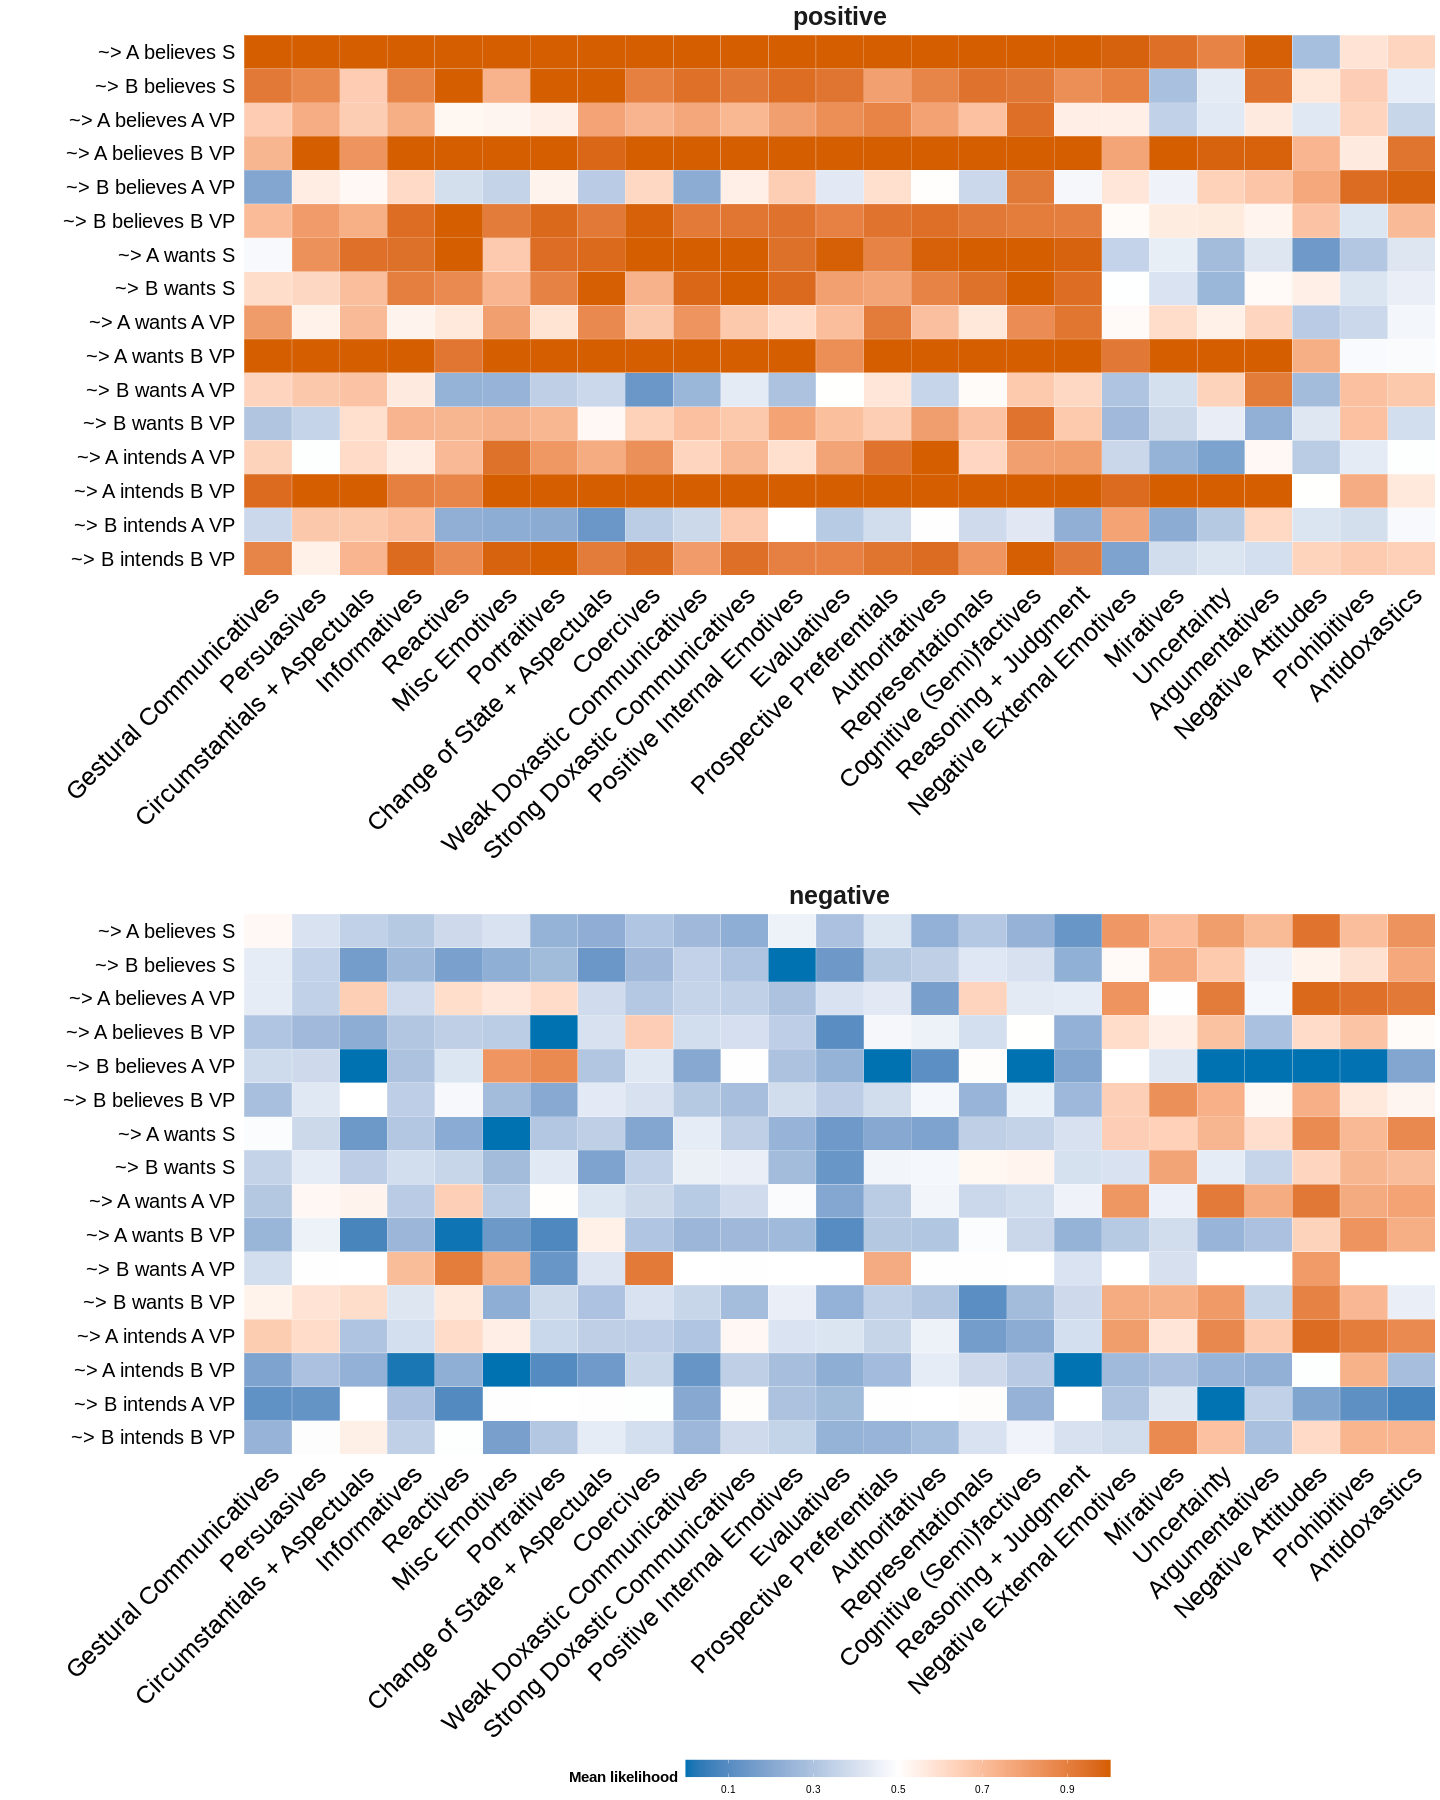

In [89]:
%%R -i best_belief_desire_locs_wm_melt -i CLUSTER_ORDER_L -i best_n_components -w 20 -h 25 -u in

library(tidyverse)

theme_set(theme_bw())

# best_belief_desire_means_melt <- filter(best_belief_desire_means_melt, inferencetype=='doxastic')
best_belief_desire_locs_wm_melt$template <- ordered(best_belief_desire_locs_wm_melt$template,
                                                 levels=rev(c(" ~> A believes S", " ~> B believes S", " ~> A believes A VP", " ~> A believes B VP", " ~> B believes A VP", " ~> B believes B VP",
                                                          " ~> A wants S",    " ~> B wants S",    " ~> A wants A VP",    " ~> A wants B VP",    " ~> B wants A VP",    " ~> B wants B VP",
                                                          " ~> A intends A VP", " ~> A intends B VP", " ~> B intends A VP", " ~> B intends B VP")))

best_belief_desire_locs_wm_melt$label <- ordered(best_belief_desire_locs_wm_melt$label,
                                                levels=CLUSTER_ORDER_L)

best_belief_desire_locs_wm_melt$polarity <- factor(best_belief_desire_locs_wm_melt$polarity, levels=c("positive", "negative"))

g = ggplot(best_belief_desire_locs_wm_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5,
                     na.value = "transparent") +
facet_wrap(best_belief_desire_locs_wm_melt$polarity,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free",
           ncol=1) +
theme(axis.text=element_text(size=20, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(1, "lines"),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text=element_text(size=25, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(0,0,0,2),"cm")
)

ggsave(sprintf('plots/intensional-loadings-means-%s.pdf', best_n_components), width=20, height=25, limitsize=FALSE)
ggsave(sprintf('plots/intensional-loadings-means-%s.png', best_n_components), width=20, height=25, limitsize=FALSE)

g

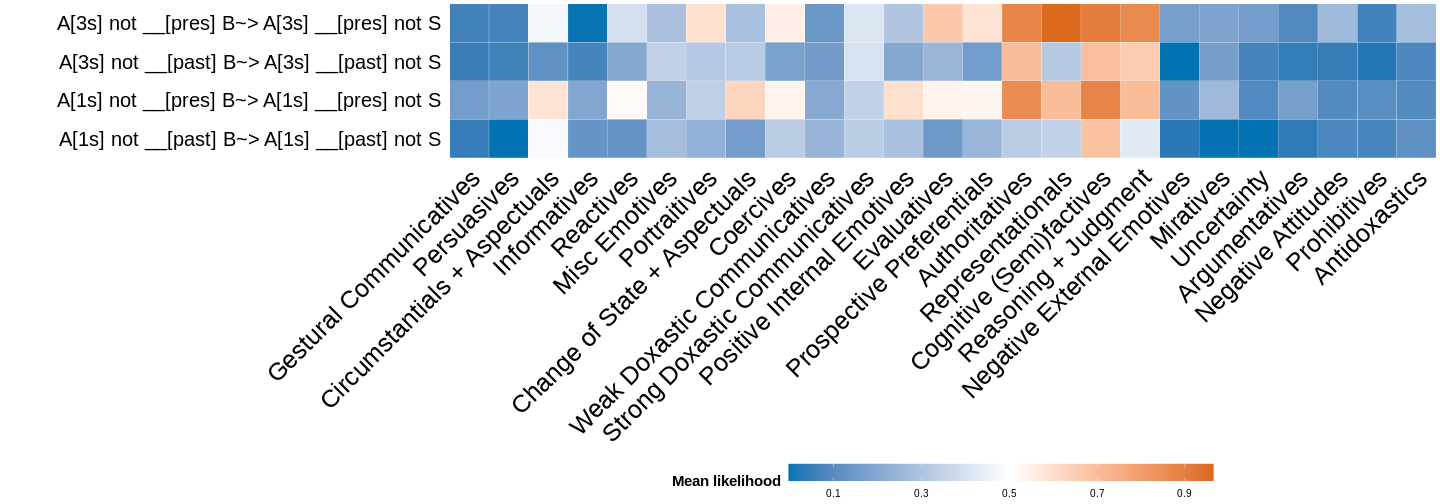

In [90]:
%%R -i best_negraising_locs_wm_melt -i CLUSTER_ORDER_L -i best_n_components -w 20 -h 7 -u in

library(tidyverse)

theme_set(theme_bw())

best_negraising_locs_wm_melt$label <- ordered(best_negraising_locs_wm_melt$label,
                                           levels=CLUSTER_ORDER_L)

best_negraising_locs_wm_melt$template <- factor(best_negraising_locs_wm_melt$template)
best_negraising_locs_wm_melt$tense <- factor(best_negraising_locs_wm_melt$tense, levels=c("past", "present"))

g = ggplot(best_negraising_locs_wm_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5,
                     na.value = "transparent") +
theme(axis.text=element_text(size=20, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(1, "lines"),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text=element_text(size=25, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(0,0,0,2),"cm")
)

ggsave(sprintf('plots/negraising-loadings-means-%s.pdf', best_n_components), width=20, height=7, limitsize=FALSE)
ggsave(sprintf('plots/negraising-loadings-means-%s.png', best_n_components), width=20, height=7, limitsize=FALSE)

g

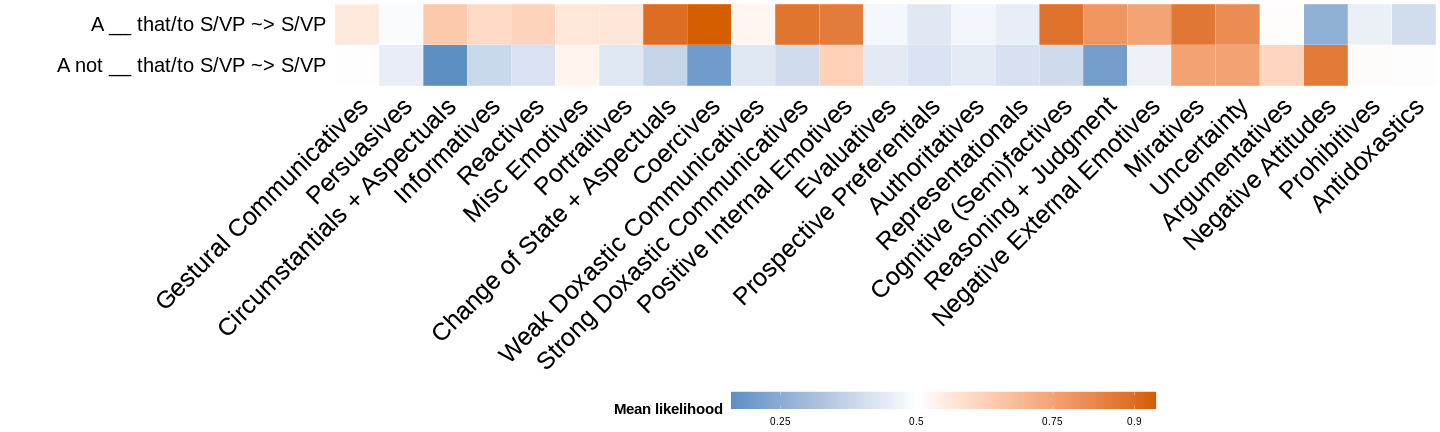

In [91]:
%%R -i best_veridicality_locs_wm_melt -i CLUSTER_ORDER_L -i best_n_components -w 20 -h 6 -u in

library(tidyverse)

theme_set(theme_bw())

best_veridicality_locs_wm_melt$template <- ordered(best_veridicality_locs_wm_melt$template,
                                                 levels=rev(c("A __ that/to S/VP ~> S/VP", "A not __ that/to S/VP ~> S/VP")))

best_veridicality_locs_wm_melt$label <- ordered(best_veridicality_locs_wm_melt$label,
                                             levels=CLUSTER_ORDER_L)

best_veridicality_locs_wm_melt$polarity <- factor(best_veridicality_locs_wm_melt$polarity, levels=c("positive", "negative"))

g = ggplot(best_veridicality_locs_wm_melt, aes(y=template, x=label, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                     na.value = "transparent") +
theme(axis.text=element_text(size=20, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(1, "lines"),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text=element_text(size=25, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(0,0,0,2),"cm")
)

ggsave(sprintf('plots/veridicality-loadings-means-%s.pdf', best_n_components), width=20, height=6, limitsize=FALSE)
ggsave(sprintf('plots/veridicality-loadings-means-%s.png', best_n_components), width=20, height=6, limitsize=FALSE)

g

Next we plot the full disaggregated inference patterns, filtering out those below the acceptability threshold.

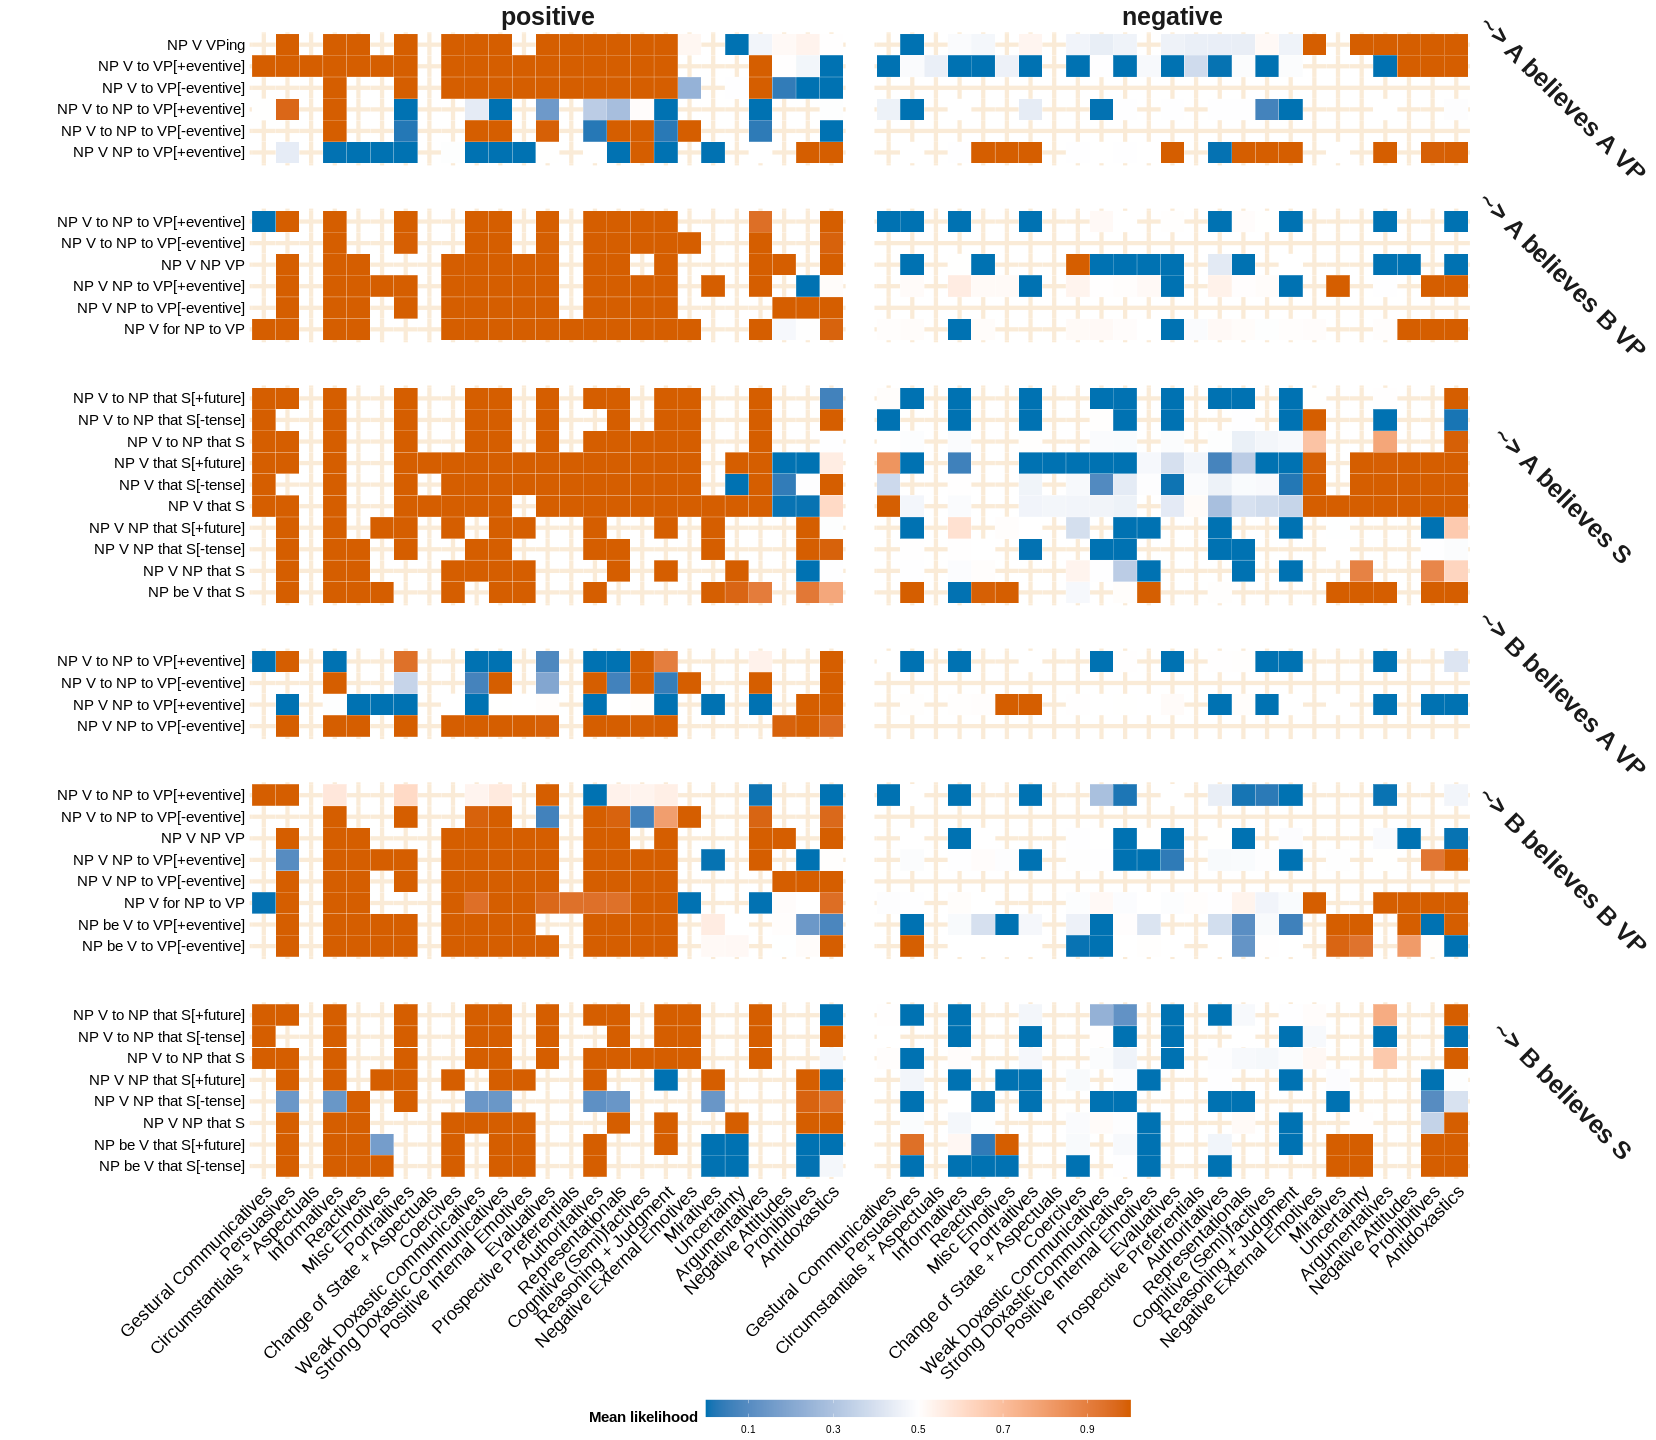

In [92]:
%%R -i best_belief_desire_locs_w_melt -i CLUSTER_ORDER_L -i best_n_components -w 23 -h 20 -u in

library(tidyverse)

theme_set(theme_bw())

best_belief_desire_locs_w_melt <- filter(best_belief_desire_locs_w_melt, inferencetype=='doxastic')

best_belief_desire_locs_w_melt$label <- ordered(best_belief_desire_locs_w_melt$label,
                                                levels=CLUSTER_ORDER_L)

best_belief_desire_locs_w_melt$template <- factor(best_belief_desire_locs_w_melt$template)

best_belief_desire_locs_w_melt$polarity <- factor(best_belief_desire_locs_w_melt$polarity, levels=c("positive", "negative"))
# best_belief_desire_locs_w_melt$frame <- factor(best_belief_desire_locs_w_melt$frame)

g = ggplot(best_belief_desire_locs_w_melt, aes(y=frame, x=label, fill=value_w-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5,
                     na.value = "transparent") +
# facet_wrap(best_belief_desire_locs_w_melt$template,
#           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#           ncol = 2, scales = "free") +
facet_grid(best_belief_desire_locs_w_melt$template ~ best_belief_desire_locs_w_melt$polarity,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free", space = "free") +
theme(axis.text=element_text(size=15, color="black"),
      axis.text.x=element_text(size=18, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      # panel.border = element_rect(colour = "antiquewhite", fill=NA, size=3),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(3, "lines"),
      panel.grid.major = element_line(colour="antiquewhite", size=2),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text.x=element_text(size=25, face="bold"),
      strip.text.y=element_text(size=25, angle=-45, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(0,0,0,2),"cm")
)


ggsave(sprintf('plots/doxastic-loadings-%s.pdf', best_n_components), width=23, height=20, limitsize=FALSE)
ggsave(sprintf('plots/doxastic-loadings-%s.png', best_n_components), width=23, height=20, limitsize=FALSE)

g

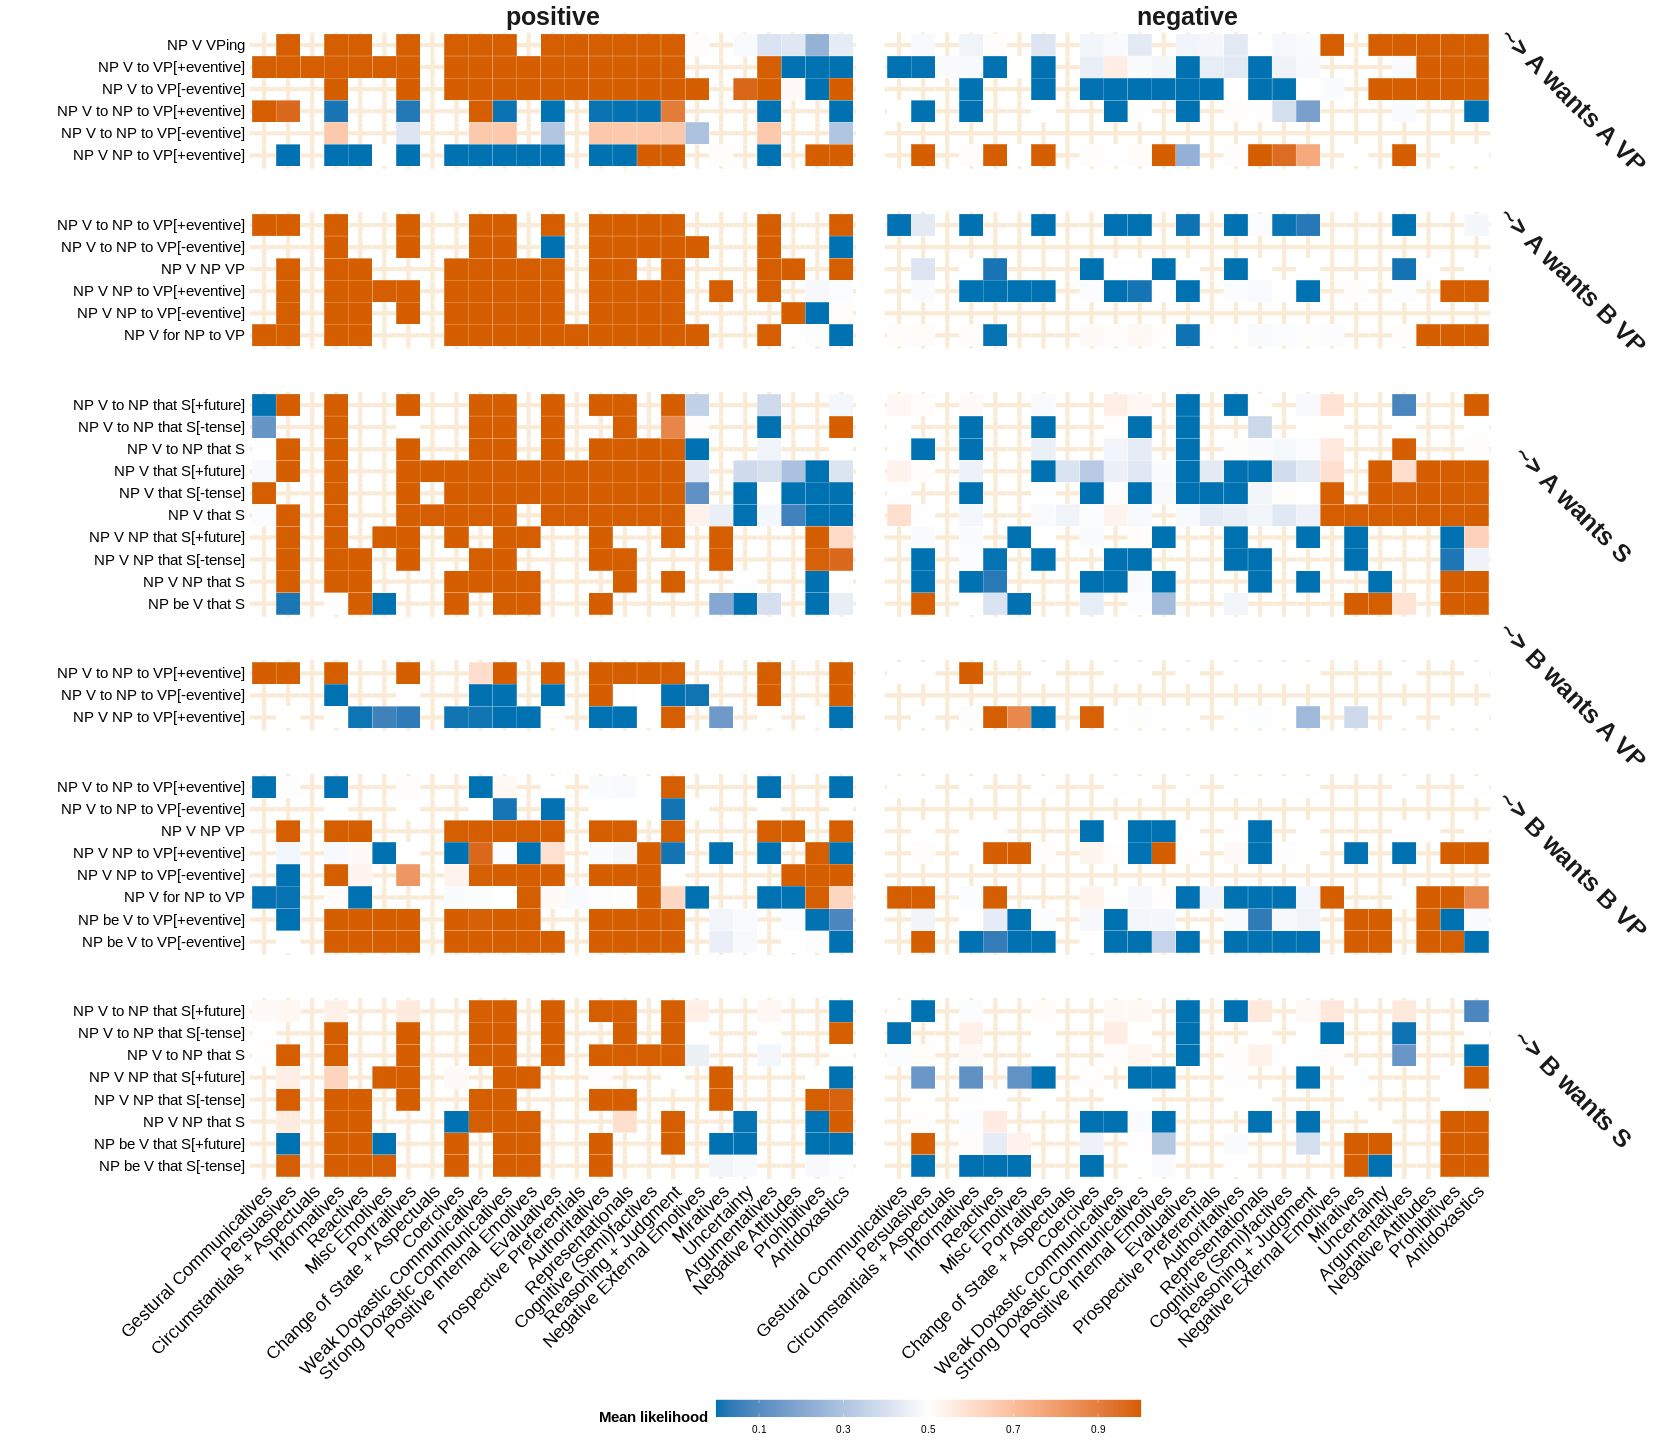

In [93]:
%%R -i best_belief_desire_locs_w_melt -i CLUSTER_ORDER_L -i best_n_components -w 23 -h 20 -u in

library(tidyverse)

theme_set(theme_bw())

best_belief_desire_locs_w_melt <- filter(best_belief_desire_locs_w_melt, inferencetype=='bouletic')

best_belief_desire_locs_w_melt$label <- ordered(best_belief_desire_locs_w_melt$label,
                                                levels=CLUSTER_ORDER_L)

best_belief_desire_locs_w_melt$template <- factor(best_belief_desire_locs_w_melt$template)
best_belief_desire_locs_w_melt$polarity <- factor(best_belief_desire_locs_w_melt$polarity, levels=c("positive", "negative"))
# best_belief_desire_locs_w_melt$frame <- factor(best_belief_desire_locs_w_melt$frame)

g = ggplot(best_belief_desire_locs_w_melt, aes(y=frame, x=label, fill=value_w-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5,
                     na.value = "transparent") +
# facet_wrap(best_belief_desire_locs_w_melt$template,
#           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#           ncol = 2, scales = "free") +
facet_grid(best_belief_desire_locs_w_melt$template ~ best_belief_desire_locs_w_melt$polarity,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free", space = "free") +
theme(axis.text=element_text(size=15, color="black"),
      axis.text.x=element_text(size=18, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      # panel.border = element_rect(colour = "antiquewhite", fill=NA, size=3),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(3, "lines"),
      panel.grid.major = element_line(colour="antiquewhite", size=2),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text.x=element_text(size=25, face="bold"),
      strip.text.y=element_text(size=25, angle=-45, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(0,0,0,2),"cm")
)



ggsave(sprintf('plots/bouletic-loadings-%s.pdf', best_n_components), width=23, height=20, limitsize=FALSE)
ggsave(sprintf('plots/bouletic-loadings-%s.png', best_n_components), width=23, height=20, limitsize=FALSE)

g

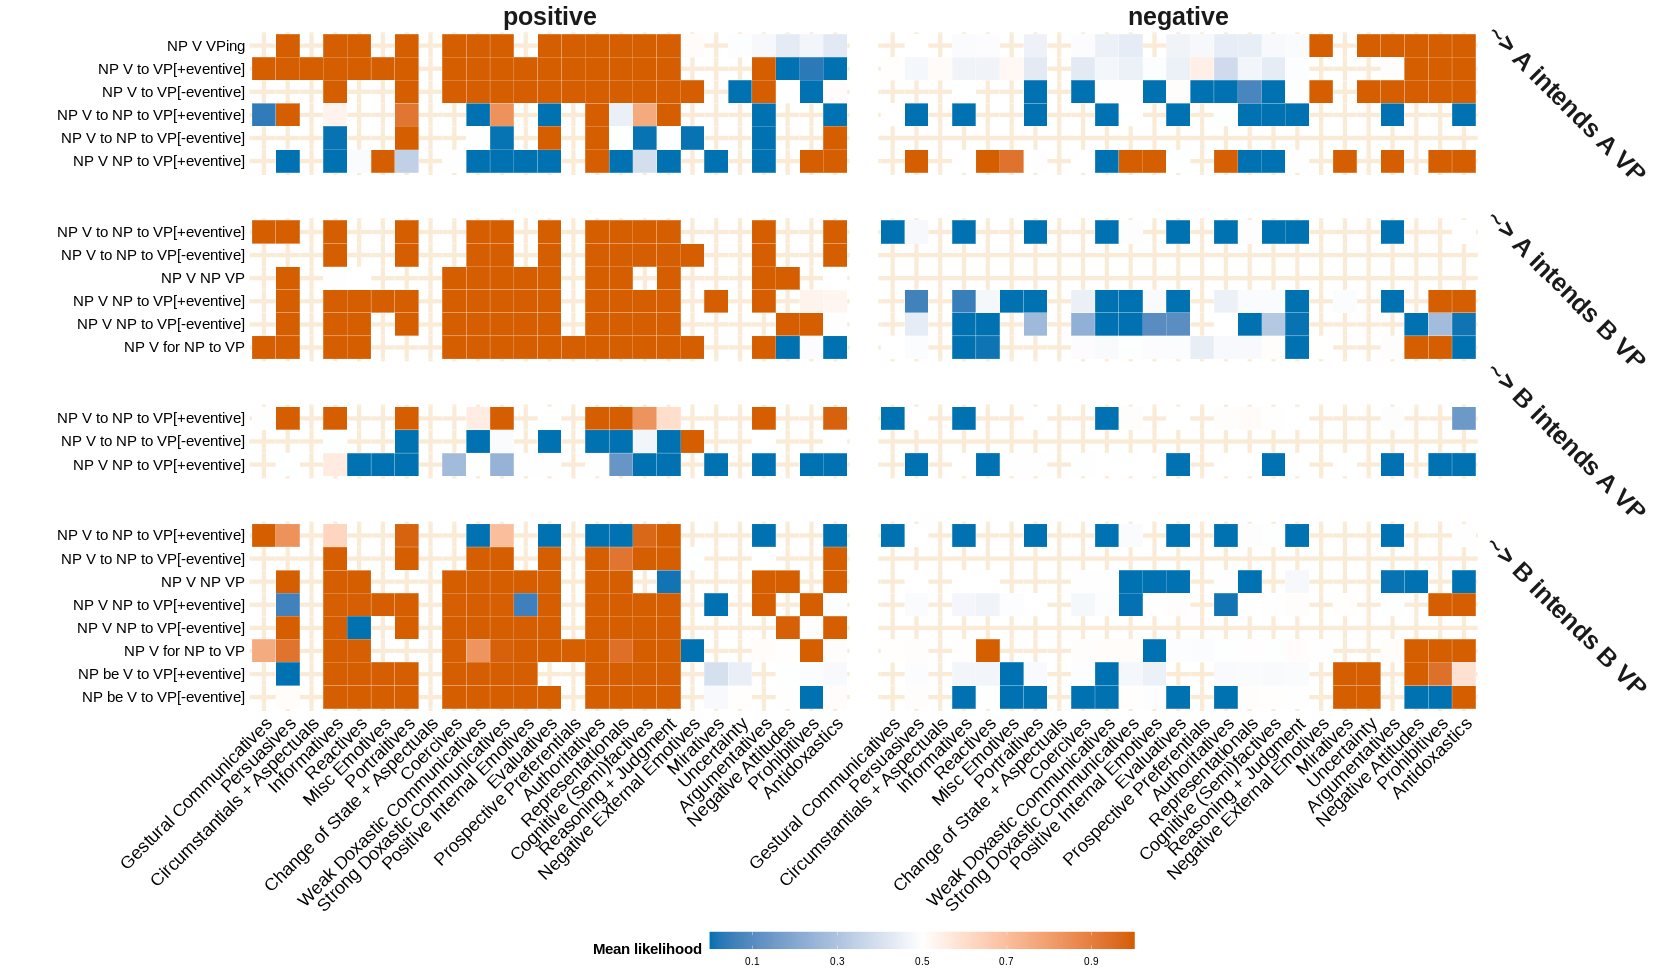

In [94]:
%%R -i best_belief_desire_locs_w_melt -i CLUSTER_ORDER_L -i best_n_components -w 23 -h 13.5 -u in

library(tidyverse)

theme_set(theme_bw())

best_belief_desire_locs_w_melt <- filter(best_belief_desire_locs_w_melt, inferencetype=='intention')

best_belief_desire_locs_w_melt$label <- ordered(best_belief_desire_locs_w_melt$label,
                                                levels=CLUSTER_ORDER_L)

best_belief_desire_locs_w_melt$template <- factor(best_belief_desire_locs_w_melt$template)
best_belief_desire_locs_w_melt$polarity <- factor(best_belief_desire_locs_w_melt$polarity, levels=c("positive", "negative"))
# best_belief_desire_locs_w_melt$frame <- factor(best_belief_desire_locs_w_melt$frame)

g = ggplot(best_belief_desire_locs_w_melt, aes(y=frame, x=label, fill=value_w-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5,
                     na.value = "transparent") +
# facet_wrap(best_belief_desire_locs_w_melt$template,
#           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#           ncol = 2, scales = "free") +
facet_grid(best_belief_desire_locs_w_melt$template ~ best_belief_desire_locs_w_melt$polarity,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free", space = "free") +
theme(axis.text=element_text(size=15, color="black"),
      axis.text.x=element_text(size=18, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      # panel.border = element_rect(colour = "antiquewhite", fill=NA, size=3),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(3, "lines"),
      panel.grid.major = element_line(colour="antiquewhite", size=2),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text.x=element_text(size=25, face="bold"),
      strip.text.y=element_text(size=25, angle=-45, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(0,0,0,2),"cm")
)



ggsave(sprintf('plots/intention-loadings-%s.pdf', best_n_components), width=23, height=13.5, limitsize=FALSE)
ggsave(sprintf('plots/intention-loadings-%s.png', best_n_components), width=23, height=13.5, limitsize=FALSE)

g

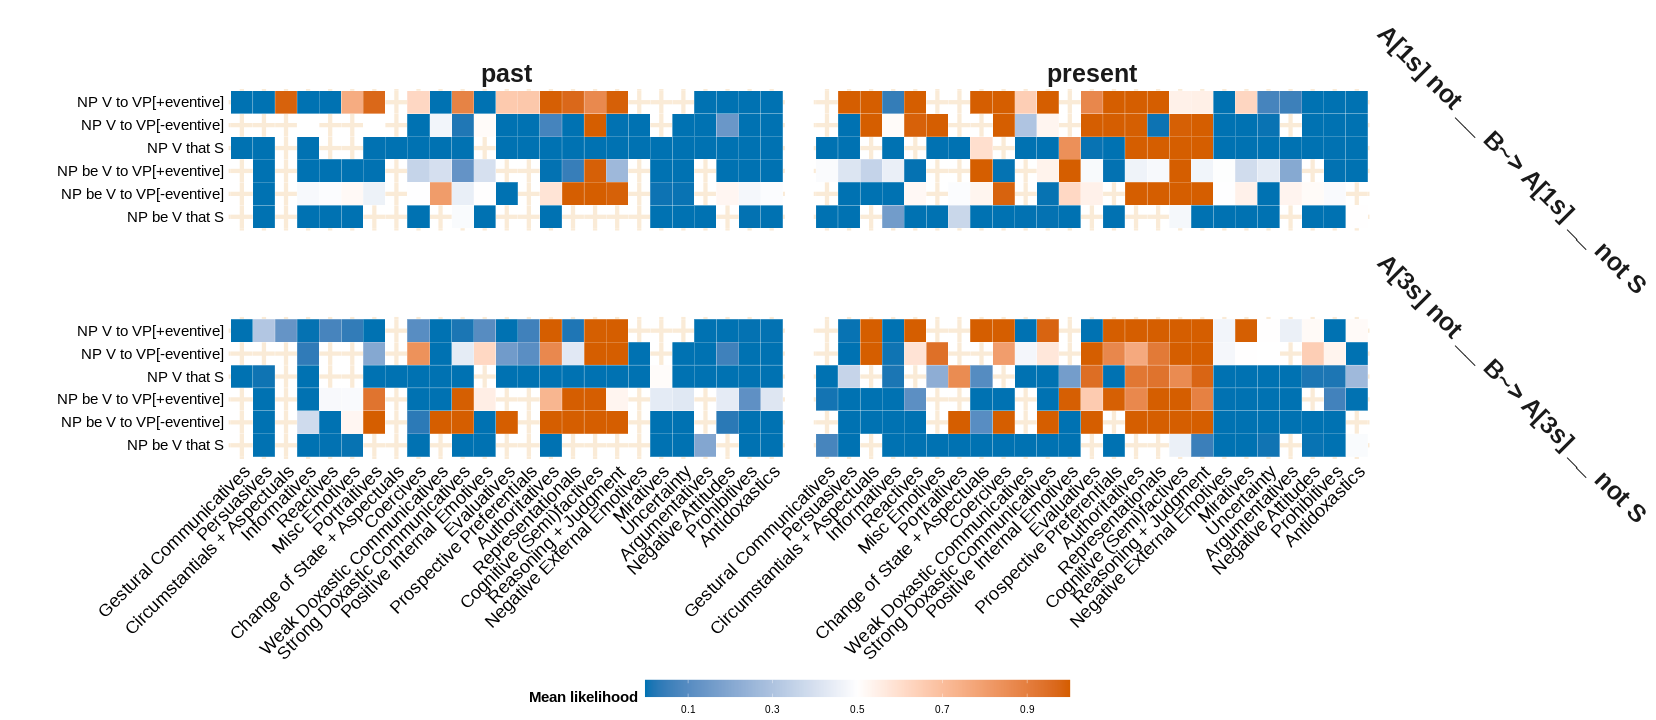

In [95]:
%%R -i best_negraising_locs_w_melt -i CLUSTER_ORDER_L -i best_n_components -w 23 -h 10 -u in

library(tidyverse)

theme_set(theme_bw())

best_negraising_locs_w_melt$label <- ordered(best_negraising_locs_w_melt$label,
                                           levels=CLUSTER_ORDER_L)

best_negraising_locs_w_melt$template <- factor(best_negraising_locs_w_melt$template)
best_negraising_locs_w_melt$tense <- factor(best_negraising_locs_w_melt$tense, levels=c("past", "present"))
# best_negraising_locs_w_melt$frame <- factor(best_negraising_locs_w_melt$frame)

g = ggplot(best_negraising_locs_w_melt, aes(y=frame, x=label, fill=value_w-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5,
                     na.value = "transparent") +
# facet_wrap(best_negraising_locs_w_melt$template,
#           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#           ncol = 2, scales = "free") +
facet_grid(best_negraising_locs_w_melt$template ~ best_negraising_locs_w_melt$tense,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free", space = "free") +
theme(axis.text=element_text(size=15, color="black"),
      axis.text.x=element_text(size=18, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      # panel.border = element_rect(colour = "antiquewhite", fill=NA, size=3),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(6, "lines"),
      panel.grid.major = element_line(colour="antiquewhite", size=2),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text.x=element_text(size=25, face="bold"),
      strip.text.y=element_text(size=25, angle=-45, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(2,0,0,2),"cm")
)

ggsave(sprintf('plots/negraising-loadings-%s.pdf', best_n_components), width=23, height=10, limitsize=FALSE)
ggsave(sprintf('plots/negraising-loadings-%s.png', best_n_components), width=23, height=10, limitsize=FALSE)

g

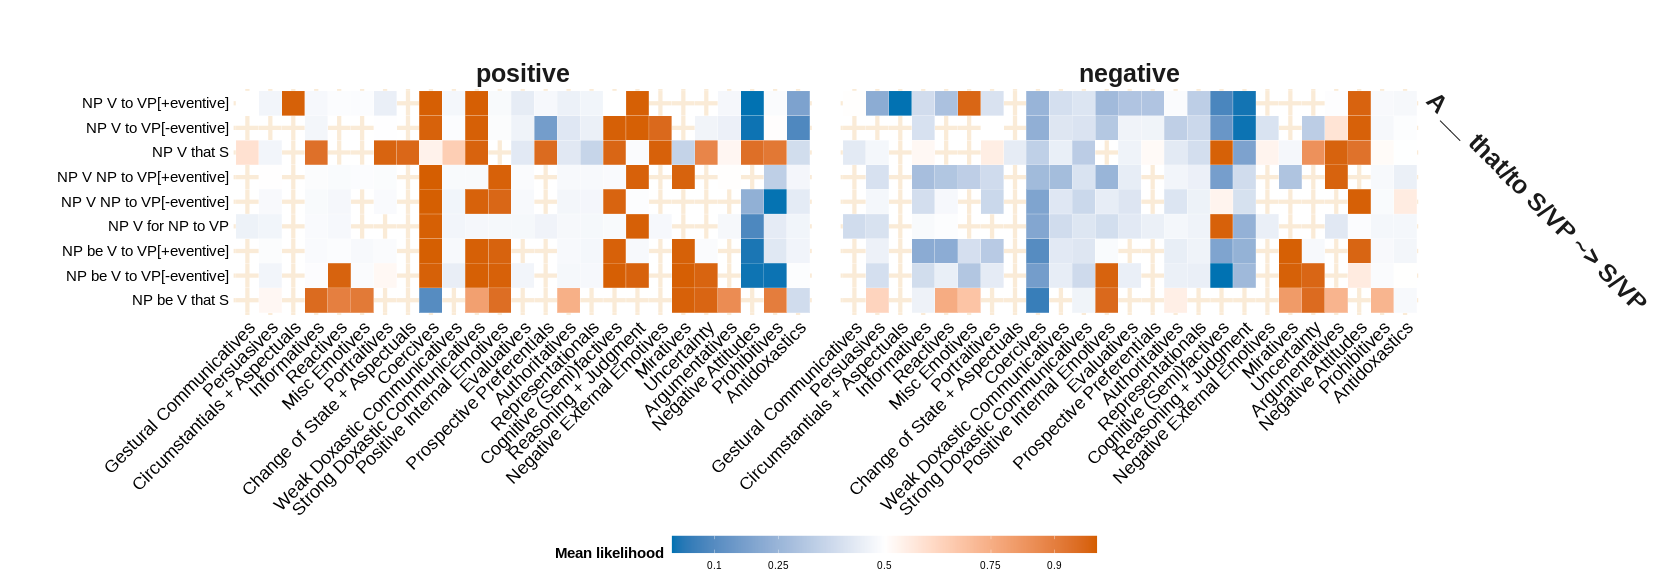

In [96]:
%%R -i best_veridicality_locs_w_melt -i CLUSTER_ORDER_L -i best_n_components -w 23 -h 8 -u in

library(tidyverse)

theme_set(theme_bw())

best_veridicality_locs_w_melt$label <- ordered(best_veridicality_locs_w_melt$label,
                                             levels=CLUSTER_ORDER_L)

best_veridicality_locs_w_melt$template <- factor(best_veridicality_locs_w_melt$template)
best_veridicality_locs_w_melt$polarity <- factor(best_veridicality_locs_w_melt$polarity, levels=c("positive", "negative"))
# best_veridicality_locs_w_melt$frame <- factor(best_veridicality_locs_w_melt$frame)

g = ggplot(best_veridicality_locs_w_melt, aes(y=frame, x=label, fill=value_w-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                     na.value = "transparent") +
# facet_wrap(best_veridicality_locs_w_melt$template,
#           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
#           ncol = 2, scales = "free") +
facet_grid(best_veridicality_locs_w_melt$template ~ best_veridicality_locs_w_melt$polarity,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free", space = "free") +
theme(axis.text=element_text(size=15, color="black"),
      axis.text.x=element_text(size=18, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      # panel.border = element_rect(colour = "antiquewhite", fill=NA, size=3),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(6, "lines"),
      panel.grid.major = element_line(colour="antiquewhite", size=2),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text.x=element_text(size=25, face="bold"),
      strip.text.y=element_text(size=25, angle=-45, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(2,0,0,2),"cm")
)

ggsave(sprintf('plots/veridicality-loadings-%s.pdf', best_n_components), width=23, height=8, limitsize=FALSE)
ggsave(sprintf('plots/veridicality-loadings-%s.png', best_n_components), width=23, height=8, limitsize=FALSE)

g

# Syntactic Feature Prediction

As a preliminary test, we fit a linear multilabel classification model that maps the cluster x frame acceptability loadings to individual syntactic features. To do this, we encode each frame as a vector of syntactic features corresponding to a constituent parse of the frame. Note that some frames are associated with multiple possible parses, so we use a loss function that takes the minimum loss across all possible parses for a frame.

In [97]:
from collections import OrderedDict

frame_to_constituents = OrderedDict({
    'NP be V whichNP to VP': {
        ("NP_subj", "NP_obj", "whichNP to VP"),
        ("NP_obj", "whichNP to VP")
    },
    'NP V for NP to VP': {
        ("NP_subj", "for NP to VP"),
        ("NP_subj", "PP_for", "to VP")
    },
    'NP V NP to VP[+eventive]': {
        ("NP_subj", "NP to VP[+eventive]"),
        ("NP_subj", "NP_obj", "to VP[+eventive]")
    },
    'NP be V whether to VP': {
        ("NP_subj", "NP_obj", "whether to VP"),
        ("NP_obj", "whether to VP")
    },
    'NP V to VP[+eventive]': {
        ("NP_subj", "to VP[+eventive]")
    },
    'NP V NP to NP': {
        ("NP_subj", "NP_obj", "NP_iobj")
    },
    'NP V NP that S': {
        ("NP_subj", "NP_obj", "that S")
    },
    'NP be V about NP': {
        ("NP_subj", "NP_obj", "about NP") ,
        ("NP_obj", "about NP")
    },
    'NP be V that S[-tense]': {
        ("NP_subj", "NP_obj", "S[-tense]") ,
        ("NP_obj", "S[-tense]")
    },
    'NP V to NP that S[+future]': {
        ("NP_subj", "NP_iobj", "that S[+future]")
    },
    'NP V whether to VP': {
        ("NP_subj", "whether to VP")
    },
    'NP V whichNP to VP': {
        ("NP_subj", "whichNP to VP")
    },
    'NP V about whether S': {
        ("NP_subj", "about whether S")
    },
    'NP V whichNP S': {
        ("NP_subj", "whichNP S")
    },
    'NP V that S[-tense]': {
        ("NP_subj", "that S[-tense]")
    },
    'NP V whether S[+future]': {
        ("NP_subj", "whether S[+future]")
    },
    'NP be V that S[+future]': {
        ("NP_subj", "NP_obj", "that S[+future]") ,
        ("NP_obj", "that S[+future]")
    },
    'NP V to NP whether S': {
        ("NP_subj", "NP_iobj", "whether S")
    },
    'NP V': {
        ("NP_subj",)
    },
    'NP V NP to VP[-eventive]': {
        ("NP_subj", "NP to VP[-eventive]"),
        ("NP_subj", "NP_obj", "to VP[-eventive]"),
        ("NP_subj", "NP to VP[-eventive]")
    },
    'NP be V so': {
        ("NP_obj", "so"),
        ("NP_subj", "NP_obj", "so")
    },
    'NP V so': {
        ("NP_subj", "so")
    },
    'NP V NP that S[+future]': {
        ("NP_subj", "NP_obj", "that S[+future]")
    },
    'NP V NP whether S[+future]': {
        ("NP_subj", "NP_obj", "whether S[+future]")
    },
    'NP V to NP whether S[+future]': {
        ("NP_subj", "NP_iobj", "whether S[+future]")
    },
    'NP be V that S': {
        ("NP_obj", "that S"),
        ("NP_subj", "NP_obj", "that S")
    },
    'NP V NP whether S': {
        ("NP_subj", "NP_obj", "whether S")
    },
    'NP be V whether S': {
        ("NP_obj", "whether S"),
        ("NP_subj", "NP_obj", "whether S")
    },
    'NP be V to VP[-eventive]': {
        ("NP_obj", "to VP[-eventive]"),
        ("NP_subj", "NP_obj", "to VP[-eventive]"),
        ("NP_subj", "NP to VP[-eventive]")
    },
    'NP V NP VP': {
        ("NP_subj", "NP_obj", "VP"),
        ("NP_subj", "NP VP")
    },
    'NP V VPing': {
        ("NP_subj", "VPing")
    },
    'NP be V to VP[+eventive]': {
        ("NP_obj", "to VP[+eventive]"),
        ("NP_subj", "NP_obj", "to VP[+eventive]"),
        ("NP_subj", "NP to VP[+eventive]")
    },
    'NP V NP that S[-tense]': {
        ("NP_subj", "NP_obj", "that S[-tense]")
    },
    'NP V that S': {
        ("NP_subj", "that S")
    },
    'NP be V': {
        ("NP_obj",),
        ("NP_subj", "NP_obj")
    },
    'NP V S': {
        ("NP_subj", "S")
    },
    'NP V that S[+future]': {
        ("NP_subj", "that S[+future]")
    },
    'NP be V about whether S': {
        ("NP_subj", "NP_obj", "about whether S") ,
        ("NP_obj", "about whether S")
    },
    'NP V NP': {
        ("NP_subj", "NP_obj")
    },
    'NP V NP VPing': {
        ("NP_subj", "NP_obj", "VPing"),
        ("NP_subj", "NP VPing")
    },
    'NP V NP whichNP S': {
        ("NP_subj", "NP_obj", "whichNP S")
    },
    'NP V about NP': {
        ("NP_subj", "about NP")
    },
    'NP be V S': {
        ("NP_subj", "NP_obj", "S") ,
        ("NP_obj", "S")
    },
    'NP V to NP that S': {
        ("NP_subj", "NP_iobj", "that S"),
    },
    'NP be V whether S[+future]': {
        ("NP_subj", "NP_obj", "whether S[+future]") ,
        ("NP_obj", "whether S[+future]")
    },
    'NP V whether S': {
        ("NP_subj", "whether S")
    },
    'NP be V whichNP S': {
        ("NP_subj", "NP_obj", "whichNP S") ,
        ("NP_obj", "whichNP S")
    },
    'NP V to NP that S[-tense]': {
        ("NP_subj", "NP_iobj", "that S[-tense]")
    },
    'NP V to VP[-eventive]': {
        ("NP_subj", "to VP[-eventive]")
    }
    # S, I V?
    # NP V to NP to VP[+eventive]? 
    # NP V to NP to VP[-eventive]?
})

SYNTACTIC_FRAMES = list(frame_to_constituents.keys())

SYNTACTIC_FEATURES = []
for frame, constituents in frame_to_constituents.items():
    for parse in constituents:
        for x in parse:
            if x not in SYNTACTIC_FEATURES:
                SYNTACTIC_FEATURES.append(x)
                
SYNTACTIC_FEATURES

['NP_obj',
 'whichNP to VP',
 'NP_subj',
 'for NP to VP',
 'PP_for',
 'to VP',
 'to VP[+eventive]',
 'NP to VP[+eventive]',
 'whether to VP',
 'NP_iobj',
 'that S',
 'about NP',
 'S[-tense]',
 'that S[+future]',
 'about whether S',
 'whichNP S',
 'that S[-tense]',
 'whether S[+future]',
 'whether S',
 'NP to VP[-eventive]',
 'to VP[-eventive]',
 'so',
 'VP',
 'NP VP',
 'VPing',
 'S',
 'NP VPing']

In [98]:
# parts_table = []
# for f,const in frame_to_constituents.items():
#     header_m = '\\multirow{2}{0.3\\textwidth}{' + f + '}\n'
#     parts_f = []
#     for p in const:
#         parts_p = []
#         for s in p:
#             parts_p.append(s.replace('_', '\_'))
#         parts_f.append('& ' + ', '.join(parts_p))
#     header = header_m if len(parts_f) > 1 else f+'\n'
#     parts_table.append(header + ' \\\\ \\cline{2-2}\n'.join(parts_f) + ' \\\\\n')
# print('\\midrule\n'.join(parts_table))

In [99]:
def constituent_data_to_matrix(frame_to_constituents, frame_order=SYNTACTIC_FRAMES, constituent_order=SYNTACTIC_FEATURES):
    constituents = np.array(constituent_order)

    max_parses = max(
        len(t) 
        for tups in frame_to_constituents.values() 
        for t in tups 
    )

    frame_to_parse_constituent_indicators = np.zeros([
        len(frame_to_constituents), max_parses, len(constituents)
    ])

    for i, f in enumerate(frame_order):
        parses = frame_to_constituents[f]
        for j, parse in enumerate(parses):
            for k, const in enumerate(parse):
                const_idx = np.where(constituents == const)[0][0]
                frame_to_parse_constituent_indicators[i,j,const_idx] = 1.
                
    return np.array(frame_to_parse_constituent_indicators)

constituent_data_to_matrix(frame_to_constituents).shape

(49, 3, 27)

In [100]:
class SyntacticFeatureClassifier():
    def __init__(self, data):
        self.data = data
        self.n_obs = len(data)
        self._prepare_data()
        
        self.mapping = nn.Linear(self.n_clusters, self.n_features, bias=False).double()
        
    def _prepare_data(self):
        self.frame_index = torch.tensor([x['frame_index'] for x in self.data])
        self.X = torch.tensor([x['cluster_weights'] for x in self.data])
        self.Y = torch.tensor([x['syntactic_features'] for x in self.data]).double()
        self.n_clusters = self.X.shape[-1]
        self.n_features = self.Y.shape[-1]
        self.n_frames = self.frame_index.max().item()+1
        
    def fit(self, n_epoch=2000, lr=1e-1, verbosity=100, seed=42):
        self._seed = seed
        np.random.seed(self._seed)
        torch.manual_seed(self._seed)
        
        torch.nn.init.uniform_(self.mapping.weight)
        
        criterion = nn.BCEWithLogitsLoss(reduction='none')
        optimizer = optim.SGD(self.mapping.parameters(), lr=lr)
        for epoch in range(n_epoch):
            optimizer.zero_grad()
            features = self.mapping(self.X)
            loss = self._loss_agg(self.frame_index, criterion(features, self.Y))
            loss.backward()
            optimizer.step()
            if epoch % verbosity == 0:
                print('Loss: {:.3f}'.format(loss.item()))
                
    def _loss_agg(self, frame_index, item_loss, agg='sum'):
        if agg=='sum':
            aggfunc = lambda x,dim: x.sum(dim=dim)
        else:
            aggfunc = lambda x,dim: x.mean(dim=dim)
        
        frame_loss = aggfunc(item_loss, 1)
        
        # This can likely be implemented more efficiently, but it works well enough here.
        loss = torch.ones(self.n_frames) * torch.inf
        for idx, l in zip(frame_index, frame_loss):
            loss[idx] = torch.minimum(loss[idx].clone(), l)
        loss = torch.nan_to_num(loss, posinf=0.)
            
        return aggfunc(loss, 0)
                
    def pred(self):
        features = self.mapping(self.X)
        return (torch.sigmoid(features)>0.5).double()
        
    def weights(self):
        with torch.no_grad():
            return self.mapping.weight.detach().data.numpy()

In [101]:
frame_cluster_weights = best_acceptability_locs.copy()

frame_cluster_weights = frame_cluster_weights.drop(columns=['template'])

# aggfuncs = {i:'mean' for i in range(best_n_components)}
# aggfuncs['tense'] = 'first'
# frame_cluster_weights = frame_cluster_weights.groupby('frame', as_index=False).agg(aggfuncs)

frame_cluster_weights = frame_cluster_weights.drop(columns=['tense'])[['frame']+list(range(best_n_components))]

print('Dropping frames:', frame_cluster_weights[~frame_cluster_weights['frame'].isin(frame_to_constituents.keys())].frame.unique())
frame_cluster_weights = frame_cluster_weights[frame_cluster_weights['frame'].isin(frame_to_constituents.keys())]

cluster_syntax_data = []
for frame, constituents in frame_to_constituents.items():
    for parse in constituents:
        cluster_syntax_data.append({'frame_index':SYNTACTIC_FRAMES.index(frame),
                                    'cluster_weights':np.array(frame_cluster_weights.query(f"frame=='{frame}'").iloc[0][1:].astype(float)),
                                    'syntactic_features':np.array([1 if x in parse else 0 for x in SYNTACTIC_FEATURES])
                                     })
        
cluster_syntax_data[0:3]

Dropping frames: ['S, I V']


[{'frame_index': 0,
  'cluster_weights': array([0.25469727, 0.19358066, 0.21204436, 0.19269709, 0.70565694,
         0.13729813, 0.19532311, 0.26579429, 0.29552472, 0.13456418,
         0.23974669, 0.14605881, 0.20971115, 0.10079037, 0.12691024,
         0.12348527, 0.99577748, 0.2313282 , 0.75831517, 0.21268571,
         0.18693289, 0.81860867, 0.27534893, 0.27336307, 0.61481811]),
  'syntactic_features': array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0])},
 {'frame_index': 0,
  'cluster_weights': array([0.25469727, 0.19358066, 0.21204436, 0.19269709, 0.70565694,
         0.13729813, 0.19532311, 0.26579429, 0.29552472, 0.13456418,
         0.23974669, 0.14605881, 0.20971115, 0.10079037, 0.12691024,
         0.12348527, 0.99577748, 0.2313282 , 0.75831517, 0.21268571,
         0.18693289, 0.81860867, 0.27534893, 0.27336307, 0.61481811]),
  'syntactic_features': array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       

In [102]:
cluster_syntactic_feature_pred = SyntacticFeatureClassifier(cluster_syntax_data)
cluster_syntactic_feature_pred.fit()

cluster_pred_features = pd.DataFrame(cluster_syntactic_feature_pred.pred(), columns=SYNTACTIC_FEATURES)
cluster_gold_features = pd.DataFrame(cluster_syntactic_feature_pred.Y, columns=SYNTACTIC_FEATURES)
feature_cluster_weights = pd.DataFrame(sigmoid(cluster_syntactic_feature_pred.weights()), index=SYNTACTIC_FEATURES, columns=list(cluster_labels.values()))

Loss: 6649.815


/tmp/ipykernel_22862/3479559833.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  self.X = torch.tensor([x['cluster_weights'] for x in self.data])


Loss: 73.809
Loss: 55.361
Loss: 46.227
Loss: 40.474
Loss: 36.395
Loss: 33.291
Loss: 30.818
Loss: 28.781
Loss: 27.063
Loss: 25.587
Loss: 24.299
Loss: 23.161
Loss: 22.147
Loss: 21.235
Loss: 20.408
Loss: 19.655
Loss: 18.964
Loss: 18.328
Loss: 17.739


We hierarchically cluster the mappings to order the axes in the plot.

In [103]:
syntax_feature_linkage = linkage(feature_cluster_weights, method='complete', metric='correlation')
syntax_cluster_linkage = linkage(feature_cluster_weights.T, method='complete', metric='correlation')

syntax_feature_order = leaves_list(syntax_feature_linkage)
SYNTAX_FEATURE_ORDER_L = [SYNTACTIC_FEATURES[i] for i in syntax_feature_order]

syntax_cluster_order = leaves_list(syntax_cluster_linkage)
SYNTAX_CLUSTER_ORDER_L = [CLUSTER_ORDER_L[i] for i in syntax_cluster_order]

print(SYNTAX_FEATURE_ORDER_L)
print(SYNTAX_CLUSTER_ORDER_L)

['whichNP S', 'that S', 'S', 'NP_subj', 'whether S', 'whether S[+future]', 'whether to VP', 'about whether S', 'NP_obj', 'to VP[+eventive]', 'that S[+future]', 'to VP[-eventive]', 'VPing', 'S[-tense]', 'that S[-tense]', 'so', 'PP_for', 'NP to VP[-eventive]', 'NP VP', 'NP VPing', 'to VP', 'NP to VP[+eventive]', 'for NP to VP', 'about NP', 'NP_iobj', 'whichNP to VP', 'VP']
['Informatives', 'Authoritatives', 'Negative External Emotives', 'Persuasives', 'Change of State + Aspectuals', 'Evaluatives', 'Weak Doxastic Communicatives', 'Cognitive (Semi)factives', 'Circumstantials + Aspectuals', 'Strong Doxastic Communicatives', 'Uncertainty', 'Reactives', 'Coercives', 'Gestural Communicatives', 'Argumentatives', 'Positive Internal Emotives', 'Prospective Preferentials', 'Reasoning + Judgment', 'Negative Attitudes', 'Portraitives', 'Representationals', 'Prohibitives', 'Antidoxastics', 'Misc Emotives', 'Miratives']


In [104]:
cluster_mispredicted_features = cluster_pred_features - cluster_gold_features

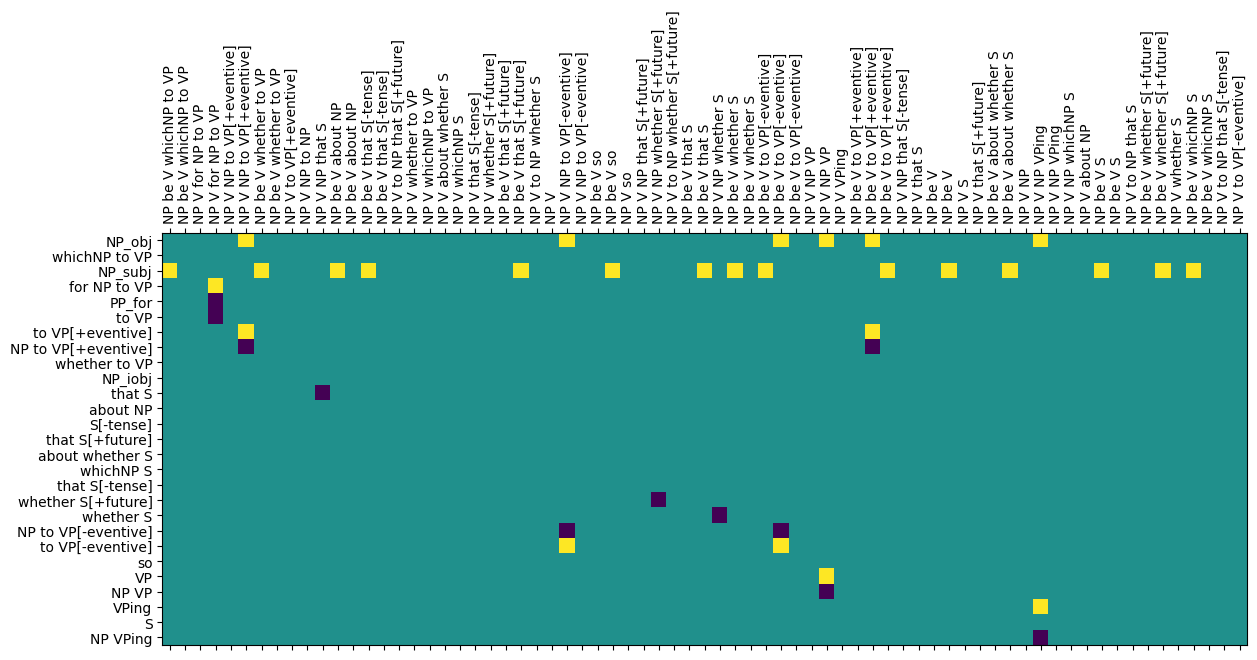

In [105]:
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot()
cax = ax.matshow(cluster_mispredicted_features.T)

xlabels = [SYNTACTIC_FRAMES[d['frame_index']] for d in cluster_syntax_data]

xaxis = np.arange(len(xlabels))
yaxis = np.arange(len(SYNTACTIC_FEATURES))
ax.set_xticks(xaxis)
ax.set_yticks(yaxis)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', rotation=90)
ax.set_yticklabels(SYNTACTIC_FEATURES)

fig.show()

In [106]:
feature_cluster_weights_melt = pd.melt(feature_cluster_weights.reset_index(), id_vars="index")
feature_cluster_weights_melt = feature_cluster_weights_melt.rename(columns={'index':'feature'})
feature_cluster_weights_melt['cluster'] = feature_cluster_weights_melt['variable'].astype(str)

# testlist = ['whichNP S', 'about whether S', 'whether S', 'whether S[+future]', 'that S', 'that S[+future]']
# SYNTAX_FEATURE_ORDER_L = testlist
# feature_cluster_weights_melt = feature_cluster_weights_melt.query('feature in @testlist')

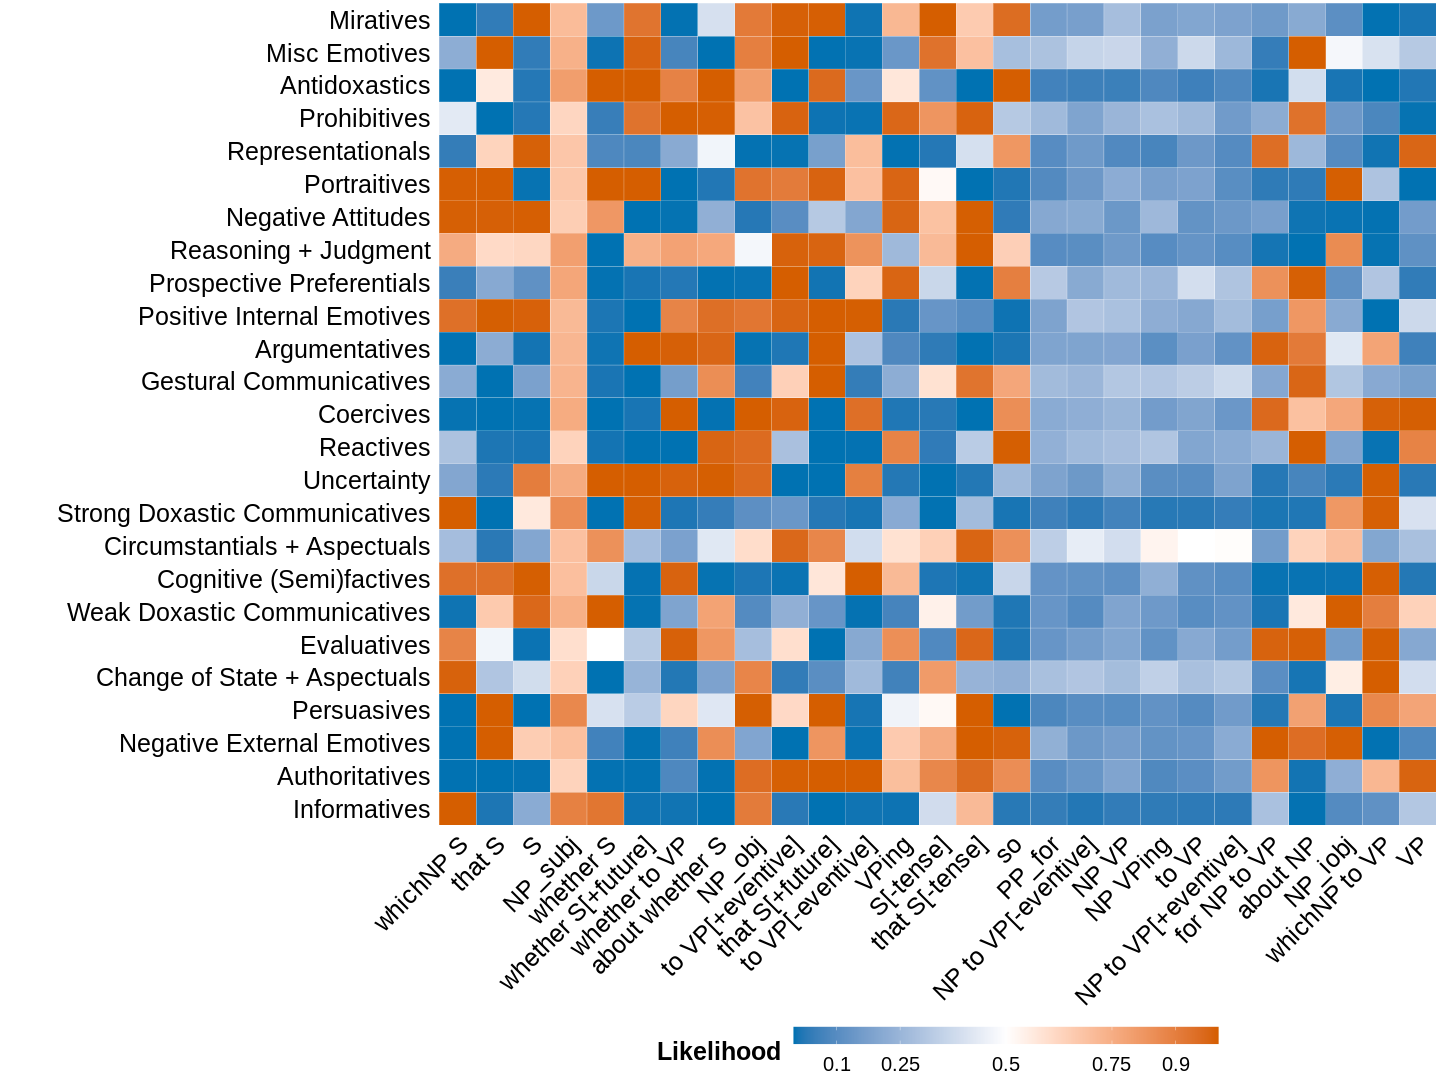

In [107]:
%%R -i feature_cluster_weights_melt -i SYNTAX_FEATURE_ORDER_L -i SYNTAX_CLUSTER_ORDER_L -w 20 -h 15 -u in

library(tidyverse)

theme_set(theme_bw())

feature_cluster_weights_melt$feature <- ordered(feature_cluster_weights_melt$feature, levels=SYNTAX_FEATURE_ORDER_L)
feature_cluster_weights_melt$cluster <- ordered(feature_cluster_weights_melt$cluster, levels=SYNTAX_CLUSTER_ORDER_L)

g = ggplot(feature_cluster_weights_melt, aes(y=cluster, x=feature, fill=value-0.5)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                    ) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/cluster-feature-mapping.pdf', width=20, height=15)
ggsave('plots/cluster-feature-mapping.png', width=20, height=15)

g

In [108]:
# test_feature = 'NP_obj'
# test_feature_subset = [x for x,const in frame_to_constituents.items() if any([any([s == test_feature for s in p]) for p in const])]

# best_acceptability_locs_subset_melt = best_acceptability_locs_melt.query('frame in @test_feature_subset')

In [109]:
# %%R -i best_acceptability_locs_subset_melt -i CLUSTER_ORDER_L -i best_n_components -w 20 -h 10 -u in

# library(tidyverse)

# theme_set(theme_bw())

# best_acceptability_locs_subset_melt$label <- ordered(best_acceptability_locs_subset_melt$label,
#                                               levels=CLUSTER_ORDER_L)

# g = ggplot(best_acceptability_locs_subset_melt, aes(y=template, x=label, fill=value-0.5)) +
# geom_tile(color="white") +
# scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
#                      breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
#                      labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
#                      na.value = "transparent") +
# theme(axis.text=element_text(size=15, color="black"),
#       axis.text.x=element_text(angle=45, hjust=1),
#       axis.title=element_blank(),
#       axis.ticks=element_blank(),
#       legend.title=element_text(size=25, face="bold"),
#       legend.text=element_text(size=20), 
#       legend.key.width=unit(3, "cm"),
#       legend.position="bottom",
#       panel.background=element_blank(),
#       panel.border=element_blank(),
#       panel.grid.major=element_blank(),
#       panel.grid.minor=element_blank(),
#       plot.background=element_blank(),
#      strip.background=element_rect(fill="white", color="white"),
#      strip.text=element_text(size=25, face="bold"),
#      plot.margin=unit(c(0,0,0,2),"cm"))

# g

# Component Decomposition

To discover underlying semantic components, we use a fuzzy logic matrix factorization model to find local components that generate the cluster x inference loadings.

To select the optimal number of components, we fit a separate fuzzy logic regression model that aims to reconstruct the cluster x acceptability loadings from the cluster component weights. Again, we use a loss function that takes the minimum across possible parses.

TODO: show model descriptions.

In [110]:
POS_WEIGHT = 1.
LOSS_AGG = 'sum'
INTERACTION_LEVEL = 1
# KFOLD = 5

# Model config
FACTOR_NEGATION = False
CLAMP = True
REGULARIZATION = 0

# Grid search config
MAX_N_FACTORS = 20
# MAX_REGULARIZATION = 0
# STEP_REGULARIZATION = 4
# MAX_INTERACTIONS = 3

# Config for final model
# INTERACTION_LEVEL_FINAL = 1
# JOINT_FACTORIZATION_FINAL = False

In [111]:
all_locs_bd = best_model['belief_desire_value'].copy()
all_locs_bd['item'] = 'belief_desire-' + all_locs_bd.index
all_locs_bd_melt = pd.melt(all_locs_bd, id_vars=['item'])
all_locs_bd_melt['label'] = all_locs_bd_melt.variable.map(cluster_labels)

all_locs_n = best_model['negraising_value'].copy()
all_locs_n['item'] = 'negraising-' + all_locs_n.index
all_locs_n_melt = pd.melt(all_locs_n, id_vars=['item'])
all_locs_n_melt['label'] = all_locs_n_melt.variable.map(cluster_labels)

all_locs_v = best_model['veridicality_value'].copy()
all_locs_v['item'] = 'veridicality-' + all_locs_v.index
all_locs_v_melt = pd.melt(all_locs_v, id_vars=['item'])
all_locs_v_melt['label'] = all_locs_v_melt.variable.map(cluster_labels)

all_locs_a = best_model['acceptability_value'].copy()
all_locs_a['item'] = 'acceptability-' + all_locs_a.index
all_locs_a_melt = pd.melt(all_locs_a, id_vars=['item'])
all_locs_a_melt['label'] = all_locs_a_melt.variable.map(cluster_labels)

In [112]:
all_inference_locs_melt = pd.concat([all_locs_bd_melt,
                                     all_locs_n_melt,
                                     all_locs_v_melt])

all_inference_locs = all_inference_locs_melt.pivot_table(index='label', columns='item', values='value')


all_inference_locs.shape

(25, 234)

In [113]:
all_syntax_locs_melt = all_locs_a_melt

all_syntax_locs_melt['frame'] = all_locs_a_melt['item'].str.replace('acceptability-', '')
all_syntax_locs_melt['tense'] = all_locs_a_melt['frame'].str.split('-').str[0]
# all_syntax_locs_melt = all_syntax_locs_melt.query("tense == 'present'")
all_syntax_locs_melt = all_syntax_locs_melt[~all_syntax_locs_melt['frame'].str.contains('S, I V')]
all_syntax_locs_melt = all_syntax_locs_melt.drop(columns=['tense', 'item'])
# all_syntax_locs_melt['frame'] = all_syntax_locs_melt['frame'].str.replace('present-', '').str.replace('past-', '').str.replace('past_progressive-', '')

all_syntax_locs = all_syntax_locs_melt.pivot_table(index='label', columns='frame', values='value').T

all_syntax_locs

label                               Antidoxastics  Argumentatives   
frame                                                               
past-NP V                                0.998015        0.998637  \
past-NP V NP                             0.998446        0.367709   
past-NP V NP VP                          0.335568        0.242634   
past-NP V NP VPing                       0.897444        0.232149   
past-NP V NP that S                      0.656906        0.161270   
...                                           ...             ...   
present-NP be V whether S                0.905367        0.375178   
present-NP be V whether S[+future]       0.786246        0.693874   
present-NP be V whether to VP            0.565800        0.626775   
present-NP be V whichNP S                0.711638        0.350981   
present-NP be V whichNP to VP            0.472685        0.003858   

label                               Authoritatives   
frame                                                
past-NP V                                 0.375215  \
past-NP V NP                              0.999526   
past-NP V NP VP                           0.944494   
past-NP V NP VPing                        0.828339   
past-NP V NP that S                       0.226952   
...                                            ...   
present-NP be V whether S                 0.371518   
present-NP be V whether S[+future]        0.240173   
present-NP be V whether to VP             0.382181   
present-NP be V whichNP S                 0.499861   
present-NP be V whichNP to VP             0.748124   

label                               Change of State + Aspectuals   
frame                                                              
past-NP V                                               0.650633  \
past-NP V NP                                            0.999278   
past-NP V NP VP                                         0.184555   
past-NP V NP VPing                                      0.305511   
past-NP V NP that S                                     0.108336   
...                                                          ...   
present-NP be V whether S                               0.649137   
present-NP be V whether S[+future]                      0.015843   
present-NP be V whether to VP                           0.516936   
present-NP be V whichNP S                               0.572183   
present-NP be V whichNP to VP                           0.440982   

label                               Circumstantials + Aspectuals  Coercives   
frame                                                                         
past-NP V                                               0.262056   0.878835  \
past-NP V NP                                            0.210722   0.883313   
past-NP V NP VP                                         0.096197   0.999092   
past-NP V NP VPing                                      0.169215   0.443364   
past-NP V NP that S                                     0.121003   0.274188   
...                                                          ...        ...   
present-NP be V whether S                               0.295216   0.297252   
present-NP be V whether S[+future]                      0.300439   0.196312   
present-NP be V whether to VP                           0.662393   0.818471   
present-NP be V whichNP S                               0.477937   0.825244   
present-NP be V whichNP to VP                           0.203187   0.684862   

label                               Cognitive (Semi)factives  Evaluatives   
frame                                                                       
past-NP V                                           0.991884     0.893204  \
past-NP V NP                                        0.999735     0.999983   
past-NP V NP VP                                     0.201613     0.276724   
past-NP V NP VPing                                  0.999749     0.762542   
past-NP V NP that S     

In [114]:
feature_matrix = pd.DataFrame([[frame]+[1 if x in parse else 0 for x in SYNTACTIC_FEATURES] for frame, constituents in frame_to_constituents.items() for parse in constituents],
                              columns=['frame']+SYNTACTIC_FEATURES)

feature_matrix1 = feature_matrix.copy()
feature_matrix2 = feature_matrix.copy()
feature_matrix3 = feature_matrix.copy()

feature_matrix1['frame'] = 'past-' + feature_matrix1['frame']
feature_matrix2['frame'] = 'past_progressive-' + feature_matrix2['frame']
feature_matrix3['frame'] = 'present-' + feature_matrix3['frame']

feature_matrix = pd.concat([feature_matrix1, feature_matrix2, feature_matrix3])

# feature_matrix_melt = feature_matrix.melt(id_vars=['frame'], value_vars=[c for c in feature_matrix.columns if c != 'frame']).rename(columns={'variable':'feature'})

feature_matrix

frame  NP_obj  whichNP to VP  NP_subj   
0          past-NP be V whichNP to VP       1              1        0  \
1          past-NP be V whichNP to VP       1              1        1   
2              past-NP V for NP to VP       0              0        1   
3              past-NP V for NP to VP       0              0        1   
4       past-NP V NP to VP[+eventive]       1              0        1   
..                                ...     ...            ...      ...   
66             present-NP V whether S       0              0        1   
67          present-NP be V whichNP S       1              0        0   
68          present-NP be V whichNP S       1              0        1   
69  present-NP V to NP that S[-tense]       0              0        1   
70      present-NP V to VP[-eventive]       0              0        1   

    for NP to VP  PP_for  to VP  to VP[+eventive]  NP to VP[+eventive]   
0              0       0      0                 0                    0  \
1              0       0      0                 0                    0   
2              1       0      0                 0                    0   
3              0       1      1                 0                    0   
4              0       0      0                 1                    0   
..           ...     ...    ...               ...                  ...   
66             0       0      0                 0                    0   
67             0       0      0                 0                    0   
68             0       0      0                 0                    0   
69             0       0      0                 0                    0   
70             0       0      0                 0                    0   

    whether to VP  ...  whether S[+future]  whether S  NP to VP[-eventive]   
0               0  ...                   0          0                    0  \
1               0  ...                   0          0                    0   
2               0  ...                   0          0                    0   
3               0  ...                   0          0                    0   
4               0  ...                   0          0                    0   
..            ...  ...                 ...        ...                  ...   
66              0  ...                   0          1                    0   
67              0  ...                   0          0                    0   
68              0  ...                   0          0                    0   
69              0  ...                   0          0                    0   
70              0  ...                   0          0                    0   

    to VP[-eventive]  so  VP  NP VP  VPing  S  NP VPing  
0                  0   0   0      0      0  0         0  
1                  0   0   0      0      0  0         0  
2                  0   0   0      0      0  0         0  
3                  0   0   0      0      0  0         0  
4                  0   0   0      0      0  0         0  
..               ...  ..  ..    ...    ... ..       ...  
66                 0   0   0      0      0  0         0  
67                 0   0   0      0      0  0         0  
68                 0   0   0      0      0  0         0  
69                 0   0   0      0      0  0         0  
70                 1   0   0      0      0  0         0  

[213 rows x 28 columns]

In [115]:
syntax_feature_data = all_syntax_locs.merge(feature_matrix, on='frame')
syntax_feature_data['frame'] = syntax_feature_data['frame'].str.replace('past-', '').str.replace('past_progressive-', '').str.replace('present-', '')
syntax_feature_data['frame_idx'] = syntax_feature_data['frame'].apply(lambda frame: SYNTACTIC_FRAMES.index(frame))
syntax_feature_data = syntax_feature_data.drop(columns=['frame'])

syntax_feature_data

Antidoxastics  Argumentatives  Authoritatives   
0         0.998015        0.998637        0.375215  \
1         0.998446        0.367709        0.999526   
2         0.335568        0.242634        0.944494   
3         0.335568        0.242634        0.944494   
4         0.897444        0.232149        0.828339   
..             ...             ...             ...   
208       0.565800        0.626775        0.382181   
209       0.711638        0.350981        0.499861   
210       0.711638        0.350981        0.499861   
211       0.472685        0.003858        0.748124   
212       0.472685        0.003858        0.748124   

     Change of State + Aspectuals  Circumstantials + Aspectuals  Coercives   
0                        0.650633                      0.262056   0.878835  \
1                        0.999278                      0.210722   0.883313   
2                        0.184555                      0.096197   0.999092   
3                        0.184555                      0.096197   0.999092   
4                        0.305511                      0.169215   0.443364   
..                            ...                           ...        ...   
208                      0.516936                      0.662393   0.818471   
209                      0.572183                      0.477937   0.825244   
210                      0.572183                      0.477937   0.825244   
211                      0.440982                      0.203187   0.684862   
212                      0.440982                      0.203187   0.684862   

     Cognitive (Semi)factives  Evaluatives  Gestural Communicatives   
0                    0.991884     0.893204                 0.999489  \
1                    0.999735     0.999983                 0.184826   
2                    0.201613     0.276724                 0.130873   
3                    0.201613     0.276724                 0.130873   
4                    0.999749     0.762542                 0.138601   
..                        ...          ...                      ...   
208                  0.044159     0.238485                 0.032251   
209                  0.358555     0.413188                 0.465588   
210                  0.358555     0.413188                 0.465588   
211                  0.448240     0.059133                 0.462325   
212                  0.448240     0.059133                 0.462325   

     Informatives  ...  whether S  NP to VP[-eventive]  to VP[-eventive]  so   
0        0.997778  ...          0                    0                 0   0  \
1        0.248794  ...          0                    0                 0   0   
2        0.998253  ...          0                    0                 0   0   
3        0.998253  ...          0                    0                 0   0   
4        0.490188  ...          0                    0                 0   0   
..            ...  ...        ...                  ...               ...  ..   
208      0.904623  ...          0                    0                 0   0   
209      0.881841  ...          0                    0                 0   0   
210      0.881841  ...          0                    0                 0   0   
211      0.870152  ...          0                    0                 0   0   
212      0.870152  ...          0                    0                 0   0   

     VP  NP VP  VPing  S  NP VPing  frame_idx  
0     0      0      0  0         0         18  
1     0      0      0  0         0         38  
2     1      0      0  0         0         29  
3     0      1      0  0         0         29  
4     0      0      0  0         1         39  
..   ..    ...    ... ..       ...        ...  
208   0      0      0  0         0          3  
209   0      0      0  0         0         46  
210   0      0      0  0         0         46  
211   0      0      0  0         0          0  
212   0      0      0  0         0          0  

[213 rows x 53 columns]

### Component factorization model

In [116]:
class MatrixFactorizationModel(torch.nn.Module):

    def __init__(self, n_cluster, n_inference, n_component, negation=False, clamp=False):
        super().__init__()
        
        self.n_cluster = n_cluster
        self.n_inference = n_inference
        self.n_component = n_component
        
        self.negation = negation
        self.clamp = clamp
        
        self.cluster_component_aux = torch.nn.Parameter(torch.randn([n_cluster, n_component]), requires_grad=True)
        self.inference_component_aux = torch.nn.Parameter(torch.randn([n_inference, n_component]), requires_grad=True)
        if self.negation:
            self.cluster_negation_aux = torch.nn.Parameter(torch.randn([n_cluster, n_component]), requires_grad=True)
            
    def forward(self, data):
        return {'inference': self.forward_inference(data['inference'])}

    def forward_inference(self, data):
        cluster_idx = torch.tensor(data['label'].values)
        item_idx = torch.tensor(data['item'].values)
        
        if self.negation:
            p = 1. - torch.prod(
                    1. - self.cluster_component_prob[cluster_idx,:] *
                         (1. - (1. - (1. - self.cluster_negation_prob[cluster_idx,:]) * self.inference_component_prob[item_idx,:]) *
                               (1. - self.cluster_negation_prob[cluster_idx,:] * (1. - self.inference_component_prob[item_idx,:]))),
                axis=1).clamp(ZERO, ONE)
        
        else:
            p = 1. - torch.prod(
                  1. - self.cluster_component_prob[cluster_idx,:] *
                       self.inference_component_prob[item_idx,:],
                    axis=1).clamp(ZERO, ONE)
        
        if self.clamp:
            p = p.clamp(ZERO, ONE)
        
        return p
    
    @property
    def cluster_component_prob(self):
        return torch.sigmoid(self.cluster_component_aux)
    
    @property
    def inference_component_prob(self):
        return torch.sigmoid(self.inference_component_aux)
    
    @property
    def cluster_negation_prob(self):
        if not self.negation:
            return None
        return torch.sigmoid(self.cluster_negation_aux)

In [117]:
class JointMatrixFactorizationModel(torch.nn.Module):

    def __init__(self, n_cluster, n_inference, n_component, n_feature, negation=False, clamp=False, interaction_level=1):
        super().__init__()
        
        self.n_cluster = n_cluster
        self.n_inference = n_inference
        self.n_component = n_component
        self.n_feature = n_feature
        
        self.negation = negation
        self.clamp = clamp
        self.interaction_level = interaction_level
        
        # Inference parameters
        self.cluster_component_aux = torch.nn.Parameter(torch.randn([n_cluster, n_component]), requires_grad=True)
        self.inference_component_aux = torch.nn.Parameter(torch.randn([n_inference, n_component]), requires_grad=True)
        if self.negation:
            self.cluster_negation_aux = torch.nn.Parameter(torch.randn([n_cluster, n_component]), requires_grad=True)
            
        # Syntax parameters
        self.mapping = nn.Linear(self.n_syntax_pred, self.n_feature, bias=False)
        torch.nn.init.uniform_(self.mapping.weight)
        
    def forward(self, data):
        return {'inference': self.forward_inference(data['inference']),
                'syntax': self.forward_syntax(data['syntax'])}

    def forward_inference(self, data):
        cluster_idx = torch.tensor(data['label'].values)
        item_idx = torch.tensor(data['item'].values)
        
        if self.negation:
            p = 1. - torch.prod(
                    1. - self.cluster_component_prob[cluster_idx,:] *
                         (1. - (1. - (1. - self.cluster_negation_prob[cluster_idx,:]) * self.inference_component_prob[item_idx,:]) *
                               (1. - self.cluster_negation_prob[cluster_idx,:] * (1. - self.inference_component_prob[item_idx,:]))),
                axis=1).clamp(ZERO, ONE)
        
        else:
            p = 1. - torch.prod(
                  1. - self.cluster_component_prob[cluster_idx,:] *
                       self.inference_component_prob[item_idx,:],
                    axis=1).clamp(ZERO, ONE)
        
        if self.clamp:
            p = p.clamp(ZERO, ONE)
        
        return p
    
    def forward_syntax(self, data):
        cluster_component_interactions = self._model_interactions()
        component_prob = data['cluster_weights'] @ cluster_component_interactions
        return self.mapping(component_prob)
        
    def _model_interactions(self):
        x1 = self.cluster_component_prob.clone()
        if self.interaction_level >= 3:
            x2 = (x1[:,None,:] * x1[:,:,None]).view(self.n_cluster, self.n_component*self.n_component)
            x3 = (x1[:,None,:,None] * x1[:,:,None,None] * x1[:,None,None,:]).view(self.n_cluster, self.n_component*self.n_component*self.n_component)
            return torch.cat((x1, x2, x3), axis=1)
            
        elif self.interaction_level == 2:
            x2 = (x1[:,None,:] * x1[:,:,None]).view(self.n_cluster, self.n_component*self.n_component)
            return torch.cat((x1, x2), axis=1)
        
        else:
            return x1
    
    @property
    def cluster_component_prob(self):
        return torch.sigmoid(self.cluster_component_aux)
    
    @property
    def inference_component_prob(self):
        return torch.sigmoid(self.inference_component_aux)
    
    @property
    def cluster_negation_prob(self):
        if not self.negation:
            return None
        return torch.sigmoid(self.cluster_negation_aux)
    
    @property
    def component_syntax_prob(self):
        return torch.sigmoid(self.mapping.weight).T
    
    @property
    def n_syntax_pred(self):
        if self.interaction_level >= 3:
            return self.n_component + self.n_component*self.n_component + self.n_component*self.n_component*self.n_component
        elif self.interaction_level == 2:
            return self.n_component + self.n_component*self.n_component
        else:
            return self.n_component

In [118]:
class MatrixFactorization():
    
    def __init__(self, n_component, joint=False,
                 negation=False, clamp=False, loss='l1', regularization=0,
                 interaction_level=1, pos_weight=1., loss_agg='sum'):
        self.n_component = n_component
        self.joint = joint
        
        # inference config
        self.negation = negation
        self.clamp = clamp
        if loss == 'l1':
            self.inf_loss_function = torch.nn.L1Loss(reduction='sum')
        elif loss == 'l2':
            self.inf_loss_function = torch.nn.MSELoss(reduction='sum')
        else:
            raise Exception('Invalid loss function')
        self.lambda_r = regularization
        
        # syntax config
        self.interaction_level = interaction_level
        self.pos_weight = pos_weight
        self.loss_agg = 'sum' if loss_agg == 'sum' else 'mean'
        self.syn_loss_function = nn.BCEWithLogitsLoss(reduction='none', pos_weight=torch.tensor(self.pos_weight))
        
    def _prepare_data(self, inference_data, syntax_data):
        self.inference_matrix = inference_data
        self.n_cluster = self.inference_matrix.shape[0]
        self.n_inference = self.inference_matrix.shape[1]
        
        self.syntax_matrix = syntax_data
        self.n_obs = self.syntax_matrix.shape[0]
        self.n_feature = self.syntax_matrix.shape[1] - (self.n_cluster+1)
        self.n_frame = self.syntax_matrix.frame_idx.max()+1
        
        self.data = {}
        
        # preprocess inference data
        inference_data = inference_data.copy()
        self.data['inference'] = pd.melt(inference_data.reset_index(), id_vars=['label'], value_vars=inference_data.columns)
        self.data['inference']['value'] = torch.tensor(self.data['inference']['value'].values).type(torch.float)
        self.data['inference']['label'] = hash_column(self.data['inference']['label'], CLUSTER_ORDER_L)
        self.data['inference']['item'] = hash_column(self.data['inference']['item'])
        
        # preprocess syntax data
        syntax_data = syntax_data.copy()
        self.data['syntax'] = {}
        # (n_obs)
        self.data['syntax']['frame_idx'] = torch.tensor(syntax_data['frame_idx'])
        # (n_obs, n_cluster)
        self.data['syntax']['cluster_weights'] = torch.tensor(syntax_data[CLUSTER_ORDER_L].values).type(torch.float)
        # (n_obs, n_feature)
        self.data['syntax']['features'] = torch.tensor(syntax_data[SYNTACTIC_FEATURES].values).type(torch.float)
        
    def _create_model(self):
        if self.joint:
            self.model = JointMatrixFactorizationModel(self.n_cluster, self.n_inference, self.n_component, self.n_feature,
                                                       negation=self.negation, clamp=self.clamp, interaction_level=self.interaction_level)
        else:
            self.model = MatrixFactorizationModel(self.n_cluster, self.n_inference, self.n_component,
                                                  negation=self.negation, clamp=self.clamp)
        
    def _find_best_initialization(self, inference_data, n):
        seeds = np.random.randint(0, 10000, size=n)
        best_seed = None
        min_err = np.inf
        
        for seed in seeds:
            torch.manual_seed(seed)
            self._create_model()
            target = torch.tensor(inference_data['value'].values)
            probs = self.model.forward_inference(inference_data)
            err = self.inf_loss_function(probs, target)
            if err < min_err:
                best_seed = seed
                min_err = err
        
        torch.manual_seed(best_seed)
        self._create_model()
        
    def _batch_data(self, data, batch_size, shuffle=True):
        shuffled = data.sample(frac=1, random_state=self._seed) if shuffle else data
        batches = np.array_split(shuffled, np.ceil(1/batch_size))
        return batches
        
    def fit(self, inference_data, syntax_data, batch_size=0.2, max_epochs=10000, lr=1e-2,
            patience=1000, tolerance_loss=1e-5, verbosity=100, seed=42, n_initializations=1000):
        self._prepare_data(inference_data, syntax_data)
        
        self._seed = seed
        np.random.seed(self._seed)
        torch.manual_seed(self._seed)
        
        if n_initializations <= 1:
            self._create_model()
        else:
            self._find_best_initialization(self.data['inference'], n_initializations)
            torch.manual_seed(self._seed)
        
        inf_batches = self._batch_data(self.data['inference'], batch_size)
        
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        
        self.inf_loss_trace = [np.inf]
        self.syn_loss_trace = [np.inf]
        inf_loss_diffs_trace = []
        syn_loss_diffs_trace = []
        
        for e in range(max_epochs):
            epoch_total_inf_loss = 0.
            epoch_total_syn_loss = 0.
            
            # 1. optimize inference predictions using minibatch
            for i, batch in enumerate(inf_batches):
                target = torch.tensor(batch['value'].values)
                
                optimizer.zero_grad()
                
                probs = self.model.forward_inference(batch)
                
                loss = self.inf_loss_function(probs, target)
                loss += self.lambda_r * self._regularization()
                    
                loss.backward()
                optimizer.step()
                epoch_total_inf_loss += loss.detach().numpy()
            
            # 2. optimize syntax predictions using batch
            if self.joint:
                optimizer.zero_grad()
                pred = self.model.forward_syntax(self.data['syntax'])
                loss = self._loss_agg(self.data['syntax']['frame_idx'],
                                      self.syn_loss_function(pred, self.data['syntax']['features']),
                                      agg=self.loss_agg)
                loss.backward()
                optimizer.step()
                epoch_total_syn_loss = loss.detach().numpy().item()
            
            # compute the difference between the current and previous inference/syntax loss, and save mean losses
            inf_loss_diff = self.inf_loss_trace[-1] - epoch_total_inf_loss
            inf_loss_diff_scaled = inf_loss_diff/abs(self.inf_loss_trace[-1]) if e else np.inf
            inf_loss_diffs_trace.append(inf_loss_diff_scaled)
            self.inf_loss_trace.append(epoch_total_inf_loss)
    
            if self.joint:
                syn_loss_diff = self.syn_loss_trace[-1] - epoch_total_syn_loss
                syn_loss_diff_scaled = syn_loss_diff/abs(self.syn_loss_trace[-1]) if e else np.inf
                syn_loss_diffs_trace.append(syn_loss_diff_scaled)
                self.syn_loss_trace.append(epoch_total_syn_loss)
            
            if verbosity and not e % verbosity:
                print(f"Epoch:             {e}")
                print(f"Loss (inf):              {round(epoch_total_inf_loss)}")
                # print(f"loss improvement (inf):  {round(inf_loss_diff_scaled, 7)}")
                if self.joint:
                    print(f"Loss (syn):              {round(epoch_total_syn_loss)}")
                    # print(f"loss improvement (syn):  {round(syn_loss_diff_scaled, 7)}")
                print()
            
            if e > patience and inf_loss_diff_scaled < tolerance_loss and (not self.joint or syn_loss_diff_scaled < tolerance_loss):
                
                if verbosity:
                    print(f"Epoch:             {e}")
                    print(f"Loss (inf):              {round(epoch_total_inf_loss)}")
                    # print(f"loss improvement (inf):  {round(inf_loss_diff_scaled, 7)}")
                    if self.joint:
                        print(f"Loss (syn):              {round(epoch_total_syn_loss)}")
                        # print(f"loss improvement (syn):  {round(syn_loss_diff_scaled, 7)}")
                    print()
                
                break  
        
        return self
    
    def _loss_agg(self, frame_index, item_loss, agg='sum'):
        if agg=='sum':
            aggfunc = lambda x,dim: x.sum(dim=dim)
        else:
            aggfunc = lambda x,dim: x.mean(dim=dim)
        
        frame_loss = aggfunc(item_loss, 1)
        
        # This can likely be implemented more efficiently, but it works well enough here.
        loss = torch.ones(self.n_frame) * torch.inf
        for idx, l in zip(frame_index, frame_loss):
            loss[idx] = torch.minimum(loss[idx].clone(), l)
        loss = torch.nan_to_num(loss, posinf=0.)
            
        if agg == 'none':
            return loss
        else:
            return aggfunc(loss, 0)
    
    def _regularization(self):
        parameters = torch.cat([self.model.inference_component_aux.flatten()])
        return torch.norm(parameters, 1) / parameters.shape[0]
    
    def pred(self):
        pred = {}
        with torch.no_grad():
            pred['inference'] = self.model.forward_inference(self.data['inference']).detach().numpy()
            if self.joint:
                pred['syntax'] = (torch.sigmoid(self.model.forward_syntax(self.data['syntax']))>0.5).detach().numpy()
        return pred
    
    def gold(self):
        gold = {}
        with torch.no_grad():
            gold['inference'] = torch.tensor(self.data['inference']['value'].values).detach().numpy()
            if self.joint:
                gold['syntax'] = self.data['syntax']['features'].detach().numpy()
        return gold
    
    @property
    def error_(self):
        error = {}
        with torch.no_grad():
            inf_target = torch.tensor(self.data['inference']['value'].values)
            inf_probs = self.model.forward_inference(self.data['inference'])
            error['inference'] = self.inf_loss_function(inf_probs, inf_target).detach().numpy()
            
            if self.joint:
                syn_target = self.data['syntax']['features']
                syn_pred = self.model.forward_syntax(self.data['syntax'])
                error['syntax'] = self._loss_agg(self.data['syntax']['frame_idx'],
                                                 self.syn_loss_function(syn_pred, syn_target),
                                                 agg=self.loss_agg).detach().numpy()
        return error
    
    @property
    def cluster_component_prob(self):
        return self.model.cluster_component_prob.detach().numpy()
    
    @property
    def inference_component_prob(self):
        return self.model.inference_component_prob.detach().numpy()
    
    @property
    def cluster_negation_prob(self):
        if not self.negation:
            return None
        return self.model.cluster_negation_prob.detach().numpy()
    
    @property
    def component_syntax_prob(self):
        if not self.joint:
            return None
        return self.model.component_syntax_prob.detach().numpy()

### Model fitting

In [119]:
joint_component_models = {}
joint_component_inference_errors = {}
joint_component_syntax_errors = {}

for n_factors in range(2,MAX_N_FACTORS+1):
    print(f'========== N_FACTORS: {n_factors} ==========')
    
    joint_component_models[n_factors] = MatrixFactorization(n_factors,
                                       joint=True,
                                       negation=FACTOR_NEGATION,
                                       clamp=CLAMP,
                                       regularization=REGULARIZATION,
                                       pos_weight=POS_WEIGHT,
                                       loss_agg=LOSS_AGG,
                                       interaction_level=INTERACTION_LEVEL).fit(all_inference_locs, syntax_feature_data, verbosity=0)
    
    errors = joint_component_models[n_factors].error_
    joint_component_inference_errors[n_factors] = errors['inference']
    joint_component_syntax_errors[n_factors] = errors['syntax']
    
    print(f'*** Final error (inf):', errors['inference'])
    print(f'*** Final error (syn):', errors['syntax'])

========== N_FACTORS: 2 ==========
*** Final error (inf): 861.63293
*** Final error (syn): 202.73273
========== N_FACTORS: 3 ==========
*** Final error (inf): 848.568
*** Final error (syn): 174.02539
========== N_FACTORS: 4 ==========
*** Final error (inf): 795.5836
*** Final error (syn): 150.01227
========== N_FACTORS: 5 ==========
*** Final error (inf): 709.2164
*** Final error (syn): 122.96963
========== N_FACTORS: 6 ==========
*** Final error (inf): 692.99524
*** Final error (syn): 111.46344
========== N_FACTORS: 7 ==========
*** Final error (inf): 659.3935
*** Final error (syn): 103.7108
========== N_FACTORS: 8 ==========
*** Final error (inf): 623.02563
*** Final error (syn): 82.087166
========== N_FACTORS: 9 ==========
*** Final error (inf): 602.46
*** Final error (syn): 54.53932
========== N_FACTORS: 10 ==========
*** Final error (inf): 623.93646
*** Final error (syn): 50.33571
========== N_FACTORS: 11 ==========
*** Final error (inf): 547.8126
*** Final error (syn): 39.82601
=

In [120]:
inf_component_models = {}
inf_component_inference_errors = {}

for n_factors in range(2,MAX_N_FACTORS+1):
    print(f'========== N_FACTORS: {n_factors} ==========')
    
    inf_component_models[n_factors] = MatrixFactorization(n_factors,
                                       joint=False,
                                       negation=FACTOR_NEGATION,
                                       clamp=CLAMP,
                                       regularization=REGULARIZATION,
                                       pos_weight=POS_WEIGHT,
                                       loss_agg=LOSS_AGG,
                                       interaction_level=INTERACTION_LEVEL).fit(all_inference_locs, syntax_feature_data, verbosity=0)
    
    errors = inf_component_models[n_factors].error_
    inf_component_inference_errors[n_factors] = errors['inference']
    
    print(f'*** Final error (inf):', errors['inference'])

========== N_FACTORS: 2 ==========
*** Final error (inf): 874.9175
========== N_FACTORS: 3 ==========
*** Final error (inf): 841.25146
========== N_FACTORS: 4 ==========
*** Final error (inf): 784.44415
========== N_FACTORS: 5 ==========
*** Final error (inf): 772.66595
========== N_FACTORS: 6 ==========
*** Final error (inf): 718.1203
========== N_FACTORS: 7 ==========
*** Final error (inf): 685.6903
========== N_FACTORS: 8 ==========
*** Final error (inf): 645.7398
========== N_FACTORS: 9 ==========
*** Final error (inf): 608.17957
========== N_FACTORS: 10 ==========
*** Final error (inf): 625.20905
========== N_FACTORS: 11 ==========
*** Final error (inf): 575.82935
========== N_FACTORS: 12 ==========
*** Final error (inf): 562.60864
========== N_FACTORS: 13 ==========
*** Final error (inf): 504.81625
========== N_FACTORS: 14 ==========
*** Final error (inf): 489.3061
========== N_FACTORS: 15 ==========
*** Final error (inf): 451.34473
========== N_FACTORS: 16 ==========
*** Final e

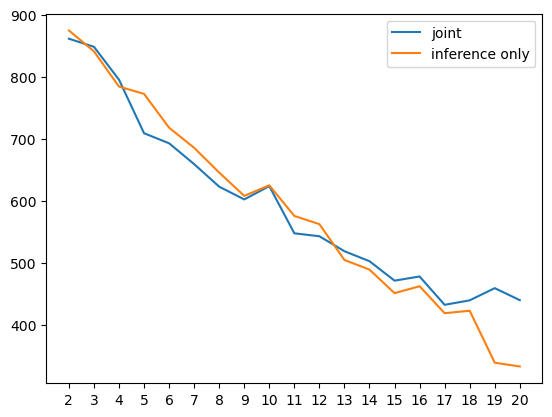

In [121]:
plt.plot(list(joint_component_inference_errors.keys()), list(joint_component_inference_errors.values()), label='joint')
plt.plot(list(inf_component_inference_errors.keys()), list(inf_component_inference_errors.values()), label='inference only')
plt.xticks(list(joint_component_inference_errors.keys()))
plt.legend()
plt.show()

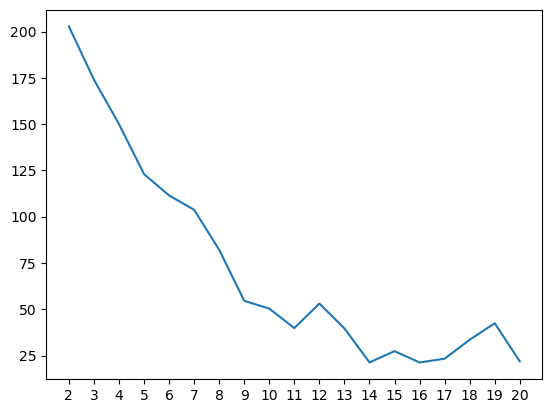

In [122]:
plt.plot(list(joint_component_syntax_errors.keys()), list(joint_component_syntax_errors.values()))
plt.xticks(list(joint_component_syntax_errors.keys()))
plt.show()

### Model investigation

In [123]:
best_n_factors = 10

In [124]:
cluster_component_matrix = joint_component_models[best_n_factors].cluster_component_prob.T
inference_component_matrix = joint_component_models[best_n_factors].inference_component_prob.T
component_syntax_matrix = joint_component_models[best_n_factors].component_syntax_prob

if FACTOR_NEGATION:
    cluster_negation_matrix = joint_component_models[best_n_factors].cluster_negation_prob.T

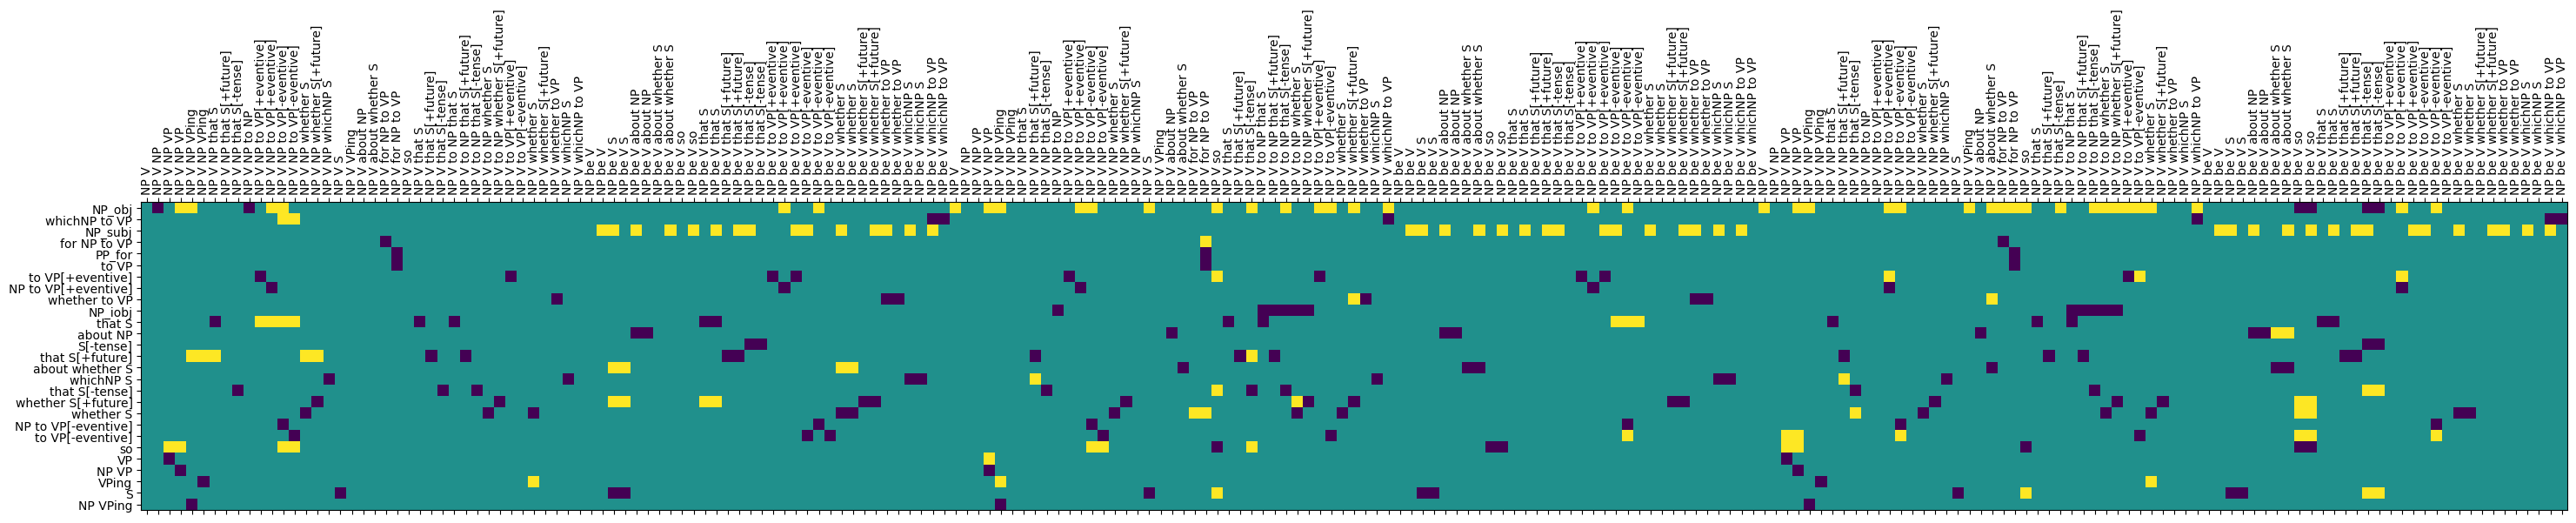

In [125]:
component_mispredicted_features = joint_component_models[best_n_factors].pred()['syntax'] - joint_component_models[best_n_factors].gold()['syntax']

fig = plt.figure(figsize=(36,36))
ax = fig.add_subplot()
cax = ax.matshow(component_mispredicted_features.T)

xlabels = [SYNTACTIC_FRAMES[f] for f in list(syntax_feature_data['frame_idx'])]

xaxis = np.arange(len(xlabels))
yaxis = np.arange(len(SYNTACTIC_FEATURES))
ax.set_xticks(xaxis)
ax.set_yticks(yaxis)
ax.set_xticklabels(xlabels)
ax.tick_params(axis='x', rotation=90)
ax.set_yticklabels(SYNTACTIC_FEATURES)

fig.show()

In [126]:
component_labels = {
    0: 'Internal Representationality',
    1: 'Emotive Communicativity',
    2: 'Negative Preferentiality',
    3: 'Evaluativity', # uncertain
    4: 'Negative Intentionality',
    5: 'Commitment', # uncertain
    6: 'Actuality',
    7: 'Positive Intentionality',
    8: 'External Representationality',
    9: 'Directed Preferentiality'
}

# external means need not involve successful transfer (e.g. differences in obj-taking)

component_labels = {i: str(i) if not component_labels[i] else component_labels[i] for i in range(best_n_factors)}

In [127]:
component_data_labels = list(all_inference_locs.columns) + SYNTACTIC_FEATURES

component_data_matrix = np.concatenate((inference_component_matrix, component_syntax_matrix), axis=1)

component_linkage = linkage(component_data_matrix, method='complete', metric='correlation')
component_data_linkage = linkage(component_data_matrix.T, method='complete', metric='correlation')

component_order = leaves_list(component_linkage)
COMPONENT_ORDER_L = [component_labels[i] for i in component_order]

component_data_order = leaves_list(component_data_linkage)
COMPONENT_DATA_ORDER_L = [component_data_labels[i] for i in component_data_order]

print(COMPONENT_ORDER_L)
print(COMPONENT_DATA_ORDER_L[:5])

['Internal Representationality', 'Negative Preferentiality', 'Emotive Communicativity', 'Negative Intentionality', 'Directed Preferentiality', 'Actuality', 'Positive Intentionality', 'Commitment', 'Evaluativity', 'External Representationality']
['belief_desire-negative-object-object-believe-NP V to NP to VP[+eventive]', 'belief_desire-negative-object-na-believe-NP V NP that S[+future]', 'belief_desire-negative-subject-na-want-NP V NP that S[+future]', 'belief_desire-negative-object-object-want-NP V NP VP', 'whichNP to VP']


In [128]:
cluster_component_loadings = pd.DataFrame(cluster_component_matrix, index=component_labels.values(), columns=CLUSTER_ORDER_L)

cluster_component_loadings

Gestural Communicatives   Persuasives   
Internal Representationality             1.408471e-06  3.686930e-08  \
Emotive Communicativity                  5.452008e-06  9.999985e-01   
Negative Preferentiality                 8.306464e-01  4.281662e-09   
Evaluativity                             4.253194e-06  8.483004e-09   
Negative Intentionality                  4.221210e-09  6.385575e-04   
Commitment                               1.028428e-09  1.000000e+00   
Actuality                                3.421695e-09  2.031248e-08   
Positive Intentionality                  1.000000e+00  4.101964e-09   
External Representationality             2.102092e-08  4.833986e-09   
Directed Preferentiality                 4.731600e-09  1.000000e+00   

                              Circumstantials + Aspectuals  Informatives   
Internal Representationality                  4.365154e-08  2.390793e-09  \
Emotive Communicativity                       7.265560e-10  1.000000e+00   
Negative Preferentiality                      1.003404e-09  3.611622e-06   
Evaluativity                                  8.382586e-10  8.152475e-08   
Negative Intentionality                       9.999735e-01  6.510013e-02   
Commitment                                    1.000000e+00  1.000000e+00   
Actuality                                     1.000000e+00  1.896730e-01   
Positive Intentionality                       1.490472e-09  1.758314e-01   
External Representationality                  1.424621e-09  1.293008e-05   
Directed Preferentiality                      4.325198e-01  6.790177e-09   

                                 Reactives  Misc Emotives  Portraitives   
Internal Representationality  8.797115e-10   5.359455e-10  3.287030e-01  \
Emotive Communicativity       9.999983e-01   2.744170e-09  3.739536e-01   
Negative Preferentiality      7.480639e-10   3.692528e-10  9.109786e-10   
Evaluativity                  1.262830e-01   9.999799e-01  9.975410e-01   
Negative Intentionality       1.434741e-08   8.815699e-01  9.912057e-09   
Commitment                    9.999990e-01   3.984938e-09  5.130082e-09   
Actuality                     1.133057e-09   1.176742e-09  4.018353e-09   
Positive Intentionality       4.898210e-01   9.999541e-01  2.797333e-09   
External Representationality  1.133001e-09   1.833228e-09  9.999856e-01   
Directed Preferentiality      3.997666e-02   3.653585e-09  1.678196e-01   

                              Change of State + Aspectuals     Coercives   
Internal Representationality                  4.820974e-06  1.855251e-09  \
Emotive Communicativity                       1.739753e-08  2.702188e-09   
Negative Preferentiality                      1.876415e-09  9.986121e-09   
Evaluativity                                  6.067500e-10  1.683635e-07   
Negative Intentionality                       7.356950e-02  3.856922e-06   
Commitment                                    3.396574e-01  3.563992e-01   
Actuality                                     9.562474e-01  1.000000e+00   
Positive Intentionality                       9.849746e-01  9.999993e-01   
External Representationality                  9.999849e-01  9.999831e-01   
Directed Preferentiality                      1.376979e-05  1.017172e-09   

                              Weak Doxastic Communicatives  ...   
Internal Representationality                  1.726697e-09  ...  \
Emotive Communicativity                       1.000000e+00  ...   
Negative Preferentiality                      1.804075e-07  ...   
Evaluativity                                  3.971705e-09  ...   
Negative Intentionality                       1.488440e-01  ...   
Commitment                                    1.407771e-09  ...   
Actuality                                     1.133474e-09  ...   
Positive Intentionality                       1.331479e-05  ...   
External Representationality                  9.999900e-01  ...   
Directed Preferentiality                      4.387129e-09  ...   

          

In [129]:
verb_cluster_loadings = best_model['membership_probs'].copy().rename(columns=cluster_labels)[CLUSTER_ORDER_L]

verb_component_loadings = pd.DataFrame(np.matmul(verb_cluster_loadings.values, cluster_component_loadings.values.T),
                                       index=verb_cluster_loadings.index,
                                       columns=cluster_component_loadings.index)

verb_component_loadings

Internal Representationality  Emotive Communicativity   
abhor                         0.452422                 0.025867  \
absolve                       0.223414                 0.157463   
accept                        0.143786                 0.193702   
acclaim                       0.217730                 0.181532   
accredit                      0.118340                 0.096413   
...                                ...                      ...   
write                         0.065243                 0.770256   
yawn                          0.003870                 0.108626   
yearn                         0.083163                 0.044468   
yell                          0.155334                 0.543705   
yelp                          0.055901                 0.472296   

          Negative Preferentiality  Evaluativity  Negative Intentionality   
abhor                     0.865937      0.082106                 0.279326  \
absolve                   0.278842      0.221994                 0.512474   
accept                    0.002299      0.744390                 0.183110   
acclaim                   0.127039      0.278115                 0.219818   
accredit                  0.032049      0.175162                 0.473802   
...                            ...           ...                      ...   
write                     0.009016      0.244196                 0.124536   
yawn                      0.424827      0.225796                 0.416652   
yearn                     0.145677      0.762497                 0.565724   
yell                      0.114346      0.368728                 0.143428   
yelp                      0.337327      0.318164                 0.211181   

          Commitment  Actuality  Positive Intentionality   
abhor       0.214465   0.105236                 0.189356  \
absolve     0.516286   0.216695                 0.148680   
accept      0.266570   0.506503                 0.175643   
acclaim     0.216740   0.133692                 0.625739   
accredit    0.558876   0.502499                 0.400394   
...              ...        ...                      ...   
write       0.437626   0.040984                 0.044047   
yawn        0.243218   0.337734                 0.494252   
yearn       0.227515   0.190553                 0.610634   
yell        0.346317   0.076531                 0.033140   
yelp        0.270852   0.105472                 0.192081   

          External Representationality  Directed Preferentiality  
abhor                         0.064236                  0.543492  
absolve                       0.296201                  0.584698  
accept                        0.778189                  0.399833  
acclaim                       0.641579                  0.188646  
accredit                      0.474763                  0.314615  
...                                ...                       ...  
write                         0.828110                  0.017201  
yawn                          0.124521                  0.113408  
yearn                         0.306565                  0.093517  
yell                          0.787413                  0.012814  
yelp                          0.391436                  0.161266  

[1007 rows x 10 columns]

In [130]:
for c in component_labels.values():
    print(f'----- Verbs with highest weight for component {c} -----')
    print('p>0.9', list(verb_component_loadings[verb_component_loadings[c]>=0.9].head(50).index))
    print('p>0.8', list(verb_component_loadings[(verb_component_loadings[c]>=0.8) & (verb_component_loadings[c]<0.9)].head(50).index))
    print('p>0.7', list(verb_component_loadings[(verb_component_loadings[c]>=0.7) & (verb_component_loadings[c]<0.8)].head(50).index))
    print('p>0.6', list(verb_component_loadings[(verb_component_loadings[c]>=0.6) & (verb_component_loadings[c]<0.7)].head(50).index))
    # print('p>0.2', list(verb_component_loadings[(verb_component_loadings[c]>=0.2) & (verb_component_loadings[c]<0.3)].head(50).index))

----- Verbs with highest weight for component Internal Representationality -----
p>0.9 ['neglect']
p>0.8 ['detest', 'dislike', 'refuse', 'reject', 'resent']
p>0.7 ['decline', 'denounce', 'dismiss', 'disregard', 'doubt', 'fear', 'hate', 'ignore', 'loathe', 'oppose', 'repress']
p>0.6 ['condemn', 'deny', 'disallow', 'dispute', 'distrust', 'dread', 'fail', 'forget', 'misjudge', 'mistrust', 'regret', 'underestimate']
----- Verbs with highest weight for component Emotive Communicativity -----
p>0.9 ['email', 'inform']
p>0.8 ['alert', 'tell', 'warn']
p>0.7 ['advise', 'brief', 'caution', 'clarify', 'consult', 'educate', 'lecture', 'misinform', 'notify', 'pester', 'phone', 'radio', 'remind', 'write']
p>0.6 ['approach', 'ask', 'assure', 'brag', 'chastise', 'communicate', 'confess', 'console', 'counsel', 'divulge', 'explain', 'fax', 'foretell', 'harass', 'hound', 'instruct', 'interview', 'mislead', 'mumble', 'murmur', 'narrate', 'prompt', 'reassure', 'reiterate', 'repeat', 'reprimand', 'show', 's

In [131]:
cluster_component_loadings_melt = pd.melt(cluster_component_loadings.T.reset_index(), id_vars="index")
cluster_component_loadings_melt = cluster_component_loadings_melt.rename(columns={'index':'cluster'})
cluster_component_loadings_melt['label'] = cluster_component_loadings_melt['variable'].astype(str)

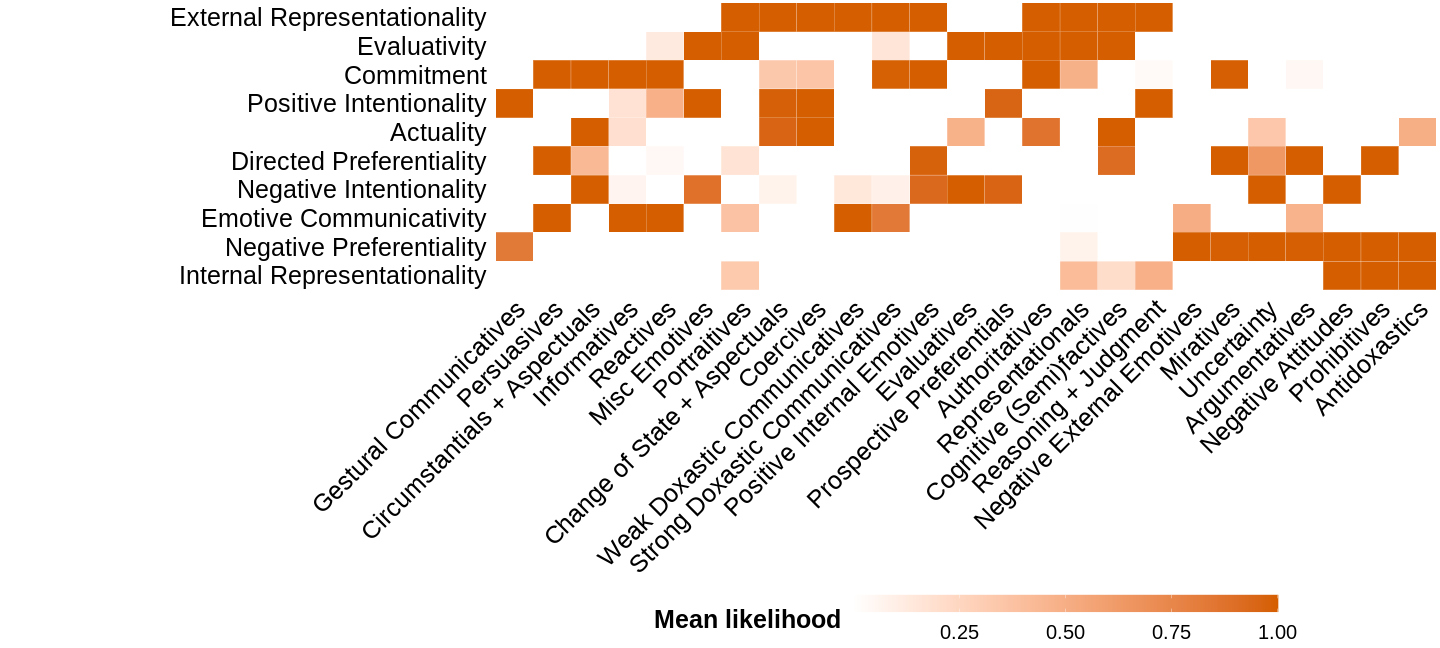

In [132]:
%%R -i cluster_component_loadings_melt -i CLUSTER_ORDER_L -i COMPONENT_ORDER_L -w 20 -h 9 -u in

library(tidyverse)

theme_set(theme_bw())

cluster_component_loadings_melt$label <- ordered(cluster_component_loadings_melt$label,
                                                 levels=COMPONENT_ORDER_L)

cluster_component_loadings_melt$cluster <- ordered(cluster_component_loadings_melt$cluster,
                                           levels=CLUSTER_ORDER_L)

g = ggplot(cluster_component_loadings_melt, aes(y=label, x=cluster, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     # breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     # labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                    ) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,6),"cm"))

ggsave('plots/cluster-component-loadings.pdf', width=20, height=9)
ggsave('plots/cluster-component-loadings.png', width=20, height=9)

g

In [133]:
if FACTOR_NEGATION:
    cluster_negation_loadings = pd.DataFrame(cluster_negation_matrix, index=component_labels.values(), columns=all_inference_locs.index, copy=True)
    
    factors_to_flip = list(cluster_negation_loadings.loc[cluster_negation_loadings.mean(axis=1) > 0.5].index)
    print(factors_to_flip)
    
    for f in factors_to_flip:
        cluster_negation_loadings.loc[f] = 1. - cluster_negation_loadings.loc[f]

In [134]:
if FACTOR_NEGATION:
    cluster_negation_loadings_melt = pd.melt(cluster_negation_loadings.T.reset_index(), id_vars="label")
    cluster_negation_loadings_melt = cluster_negation_loadings_melt.rename(columns={'label':'cluster'})
    cluster_negation_loadings_melt['label'] = cluster_negation_loadings_melt['variable'].astype(str)
else:
    cluster_negation_loadings_melt = pd.DataFrame(columns=cluster_component_loadings_melt.columns)

In [135]:
cluster_negation_loadings_melt

Empty DataFrame
Columns: [cluster, variable, value, label]
Index: []

In [136]:
%%R -i cluster_negation_loadings_melt -i CLUSTER_ORDER_L -i COMPONENT_ORDER_L -w 15 -h 8 -u in

library(tidyverse)

theme_set(theme_bw())

cluster_negation_loadings_melt$label <- ordered(cluster_negation_loadings_melt$label,
                                                 levels=COMPONENT_ORDER_L)

cluster_negation_loadings_melt$cluster <- ordered(cluster_negation_loadings_melt$cluster,
                                           levels=CLUSTER_ORDER_L)

g = ggplot(cluster_negation_loadings_melt, aes(y=label, x=cluster, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     # breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     # labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                    ) +
theme(axis.text=element_text(size=15, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/cluster-negation-loadings.pdf', width=15, height=8)
ggsave('plots/cluster-negation-loadings.png', width=15, height=8)

g

In [137]:
if FACTOR_NEGATION:
    # unused_negation = 1. - (1. - cluster_component_loadings * cluster_negation_loadings) * (1. - (1. - cluster_component_loadings) * (1. - cluster_negation_loadings))
    # unused_negation = 1. - cluster_negation_loadings * (1. - cluster_component_loadings)
    unused_negation = cluster_negation_loadings * (1. - cluster_component_loadings)

    unused_negation_loadings = pd.DataFrame(unused_negation, columns=all_inference_locs.index)

    unused_negation_melt = pd.melt(unused_negation_loadings.T.reset_index(), id_vars="label")
    unused_negation_melt = unused_negation_melt.rename(columns={'label':'cluster'})
    unused_negation_melt['label'] = unused_negation_melt['variable'].astype(str)

    unused_negation.sum(axis=1).sum() / cluster_negation_loadings.sum(axis=1).sum()

else:
    unused_negation_melt = pd.DataFrame(columns=cluster_component_loadings_melt.columns)

In [138]:
%%R -i unused_negation_melt -i CLUSTER_ORDER_L -i COMPONENT_ORDER_L -w 15 -h 8 -u in

library(tidyverse)

theme_set(theme_bw())

unused_negation_melt$label <- ordered(unused_negation_melt$label,
                                                 levels=COMPONENT_ORDER_L)

unused_negation_melt$cluster <- ordered(unused_negation_melt$cluster,
                                           levels=CLUSTER_ORDER_L)

g = ggplot(unused_negation_melt, aes(y=label, x=cluster, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     # breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     # labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                    ) +
theme(axis.text=element_text(size=15, color="black"),
      axis.text.x=element_text(angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/cluster-negation-loadings.pdf', width=15, height=8)
ggsave('plots/cluster-negation-loadings.png', width=15, height=8)

g

In [139]:
NORMALIZE_SYNTAX = False

if INTERACTION_LEVEL >= 3:
    component_pred_index = [component_labels[i] for i in range(best_n_factors)] + \
                           [component_labels[i]+'x'+component_labels[j] for i in range(best_n_factors) for j in range(best_n_factors)] + \
                           [component_labels[i]+'x'+component_labels[j]+'x'+component_labels[k] for i in range(best_n_factors) for j in range(best_n_factors) for k in range(best_n_factors)]
elif INTERACTION_LEVEL == 2:
    component_pred_index = [component_labels[i] for i in range(best_n_factors)] + \
                           [component_labels[i]+'x'+component_labels[j] for i in range(best_n_factors) for j in range(best_n_factors)]
else:
    component_pred_index = [component_labels[i] for i in range(best_n_factors)]

component_syntax_loadings = pd.DataFrame(component_syntax_matrix, index=component_pred_index, columns=SYNTACTIC_FEATURES, copy=True)

if NORMALIZE_SYNTAX:
    component_syntax_loadings = component_syntax_loadings / component_syntax_loadings.sum(axis=0)

component_syntax_loadings

NP_obj  whichNP to VP   NP_subj  for NP to VP   
Internal Representationality  0.242787       0.764911  0.714903      0.054377  \
Emotive Communicativity       0.459562       0.948340  0.665655      0.281752   
Negative Preferentiality      0.095233       0.027132  0.669089      0.629770   
Evaluativity                  0.005089       0.332739  0.607143      0.953655   
Negative Intentionality       0.860582       0.272983  0.716265      0.628797   
Commitment                    0.995929       0.162962  0.645633      0.479083   
Actuality                     0.990398       0.990734  0.701947      0.502538   
Positive Intentionality       0.221804       0.103766  0.616488      0.519332   
External Representationality  0.066836       0.499309  0.721847      0.386569   
Directed Preferentiality      0.843432       0.341841  0.741598      0.072218   

                                PP_for     to VP  to VP[+eventive]   
Internal Representationality  0.430103  0.396158          0.069528  \
Emotive Communicativity       0.451083  0.405393          0.024259   
Negative Preferentiality      0.413884  0.459203          0.034854   
Evaluativity                  0.495144  0.486518          0.817683   
Negative Intentionality       0.419179  0.460536          0.954540   
Commitment                    0.306494  0.450293          0.893046   
Actuality                     0.314005  0.388399          0.857633   
Positive Intentionality       0.514038  0.450620          0.461932   
External Representationality  0.438983  0.337198          0.448609   
Directed Preferentiality      0.370294  0.322439          0.171824   

                              NP to VP[+eventive]  whether to VP   NP_iobj   
Internal Representationality             0.469723       0.079756  0.204029  \
Emotive Communicativity                  0.417889       0.263066  0.984645   
Negative Preferentiality                 0.368379       0.601540  0.147734   
Evaluativity                             0.425047       0.037518  0.305866   
Negative Intentionality                  0.533841       0.981364  0.750918   
Commitment                               0.396469       0.035248  0.181515   
Actuality                                0.432504       0.929119  0.464923   
Positive Intentionality                  0.404337       0.478118  0.335512   
External Representationality             0.355233       0.791987  0.913891   
Directed Preferentiality                 0.392820       0.685455  0.005992   

                              ...  whether S[+future]  whether S   
Internal Representationality  ...            0.078294   0.078883  \
Emotive Communicativity       ...            0.662322   0.848728   
Negative Preferentiality      ...            0.327824   0.054556   
Evaluativity                  ...            0.993396   0.983618   
Negative Intentionality       ...            0.886186   0.867360   
Commitment                    ...            0.469186   0.158308   
Actuality                     ...            0.042021   0.148492   
Positive Intentionality       ...            0.001633   0.391011   
External Representationality  ...            0.357425   0.290438   
Directed Preferentiality      ...            0.879498   0.793753   

                              NP to VP[-eventive]  to VP[-eventive]        so   
Internal Representationality             0.379222          0.428438  0.757424  \
Emotive Communicativity                  0.344814          0.000964  0.159445   
Negative Preferentiality                 0.357048          0.376392  0.672790   
Evaluativity                             0.322247          0.941380  0.790562   
Negative Intentionality                  0.406957          0.232191  0.014689   
Commitment                               0.528810          0.729226  0.882354   
Actuality                                0.454794          0.226029  0.920801   
Positive Intentionality                  0.481441          0.359406  0.601723   
External Representationality    

In [140]:
component_syntax_loadings_melt = pd.melt(component_syntax_loadings.T.reset_index(), id_vars="index")
component_syntax_loadings_melt = component_syntax_loadings_melt.rename(columns={'index':'feature'})
component_syntax_loadings_melt['component'] = component_syntax_loadings_melt['variable'].astype(str)

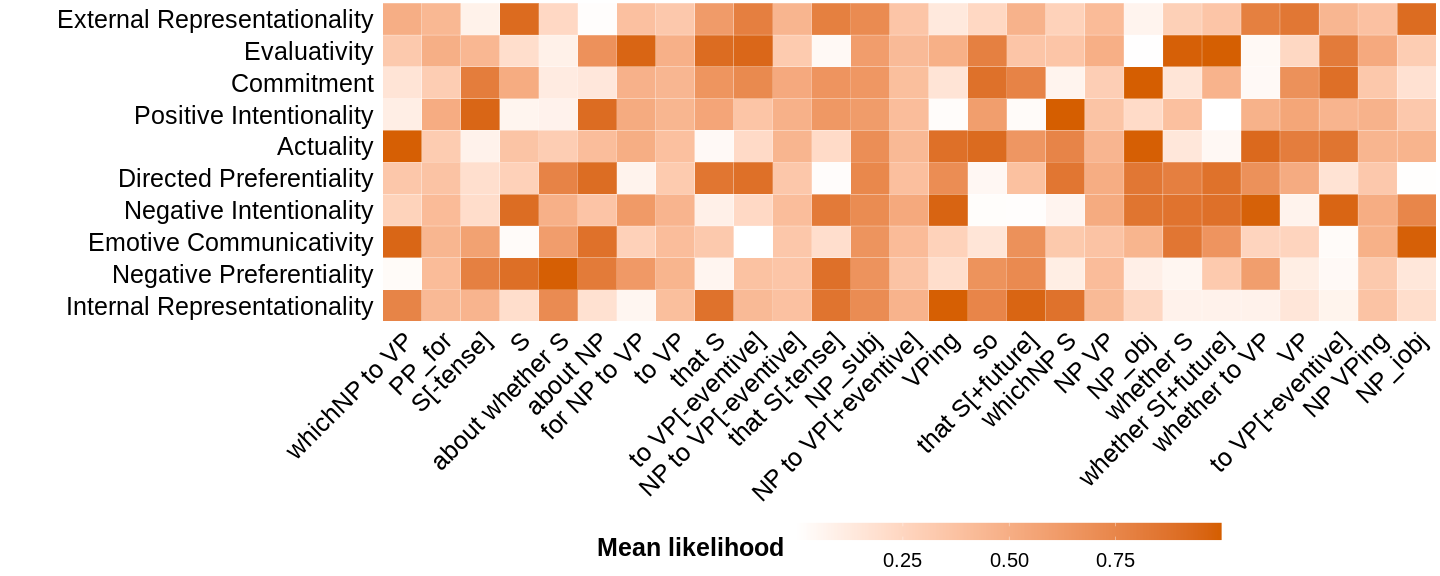

In [141]:
%%R -i component_syntax_loadings_melt -i COMPONENT_ORDER_L -i COMPONENT_DATA_ORDER_L -w 20 -h 8 -u in

library(tidyverse)

theme_set(theme_bw())

component_syntax_loadings_melt$feature <- ordered(component_syntax_loadings_melt$feature,
                                                  levels=COMPONENT_DATA_ORDER_L)

component_syntax_loadings_melt$component <- ordered(component_syntax_loadings_melt$component,
                                                    levels=COMPONENT_ORDER_L)

g = ggplot(component_syntax_loadings_melt, aes(y=component, x=feature, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     # breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     # labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                    ) +
theme(axis.text=element_text(size=25, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=25, face="bold"),
      legend.text=element_text(size=20), 
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      plot.background=element_blank(),
     strip.background=element_rect(fill="white", color="white"),
     strip.text=element_text(size=25, face="bold"),
     plot.margin=unit(c(0,0,0,2),"cm"))

ggsave('plots/component-feature-mapping.pdf', width=20, height=8)
ggsave('plots/component-feature-mapping.png', width=20, height=8)

g

In [142]:
inference_component_loadings = pd.DataFrame(inference_component_matrix, index=component_labels.values(), columns=all_inference_locs.columns, copy=True)

if FACTOR_NEGATION:
    for f in factors_to_flip:
        inference_component_loadings.loc[f] = 1. - inference_component_loadings.loc[f]

inference_component_loadings

item                          belief_desire-negative-object-na-believe-NP V NP that S   
Internal Representationality                                       2.075901e-09        \
Emotive Communicativity                                            4.773239e-01         
Negative Preferentiality                                           4.981709e-01         
Evaluativity                                                       9.931046e-01         
Negative Intentionality                                            4.903737e-09         
Commitment                                                         2.368703e-08         
Actuality                                                          9.978031e-06         
Positive Intentionality                                            9.270844e-06         
External Representationality                                       7.251804e-07         
Directed Preferentiality                                           3.926976e-09         

item                          belief_desire-negative-object-na-believe-NP V NP that S[+future]   
Internal Representationality                                       2.186079e-07                 \
Emotive Communicativity                                            1.587269e-07                  
Negative Preferentiality                                           9.718092e-06                  
Evaluativity                                                       5.262527e-09                  
Negative Intentionality                                            8.756737e-10                  
Commitment                                                         2.469097e-06                  
Actuality                                                          4.813138e-01                  
Positive Intentionality                                            3.296913e-09                  
External Representationality                                       7.966941e-06                  
Directed Preferentiality                                           6.917672e-09                  

item                          belief_desire-negative-object-na-believe-NP V NP that S[-tense]   
Internal Representationality                                       2.012255e-05                \
Emotive Communicativity                                            8.862898e-06                 
Negative Preferentiality                                           7.493637e-06                 
Evaluativity                                                       9.441797e-10                 
Negative Intentionality                                            6.252789e-07                 
Commitment                                                         2.539463e-06                 
Actuality                                                          6.778929e-06                 
Positive Intentionality                                            9.910719e-08                 
External Representationality                                       8.963456e-10                 
Directed Preferentiality                                           2.160384e-09                 

item                          belief_desire-negative-object-na-believe-NP V to NP that S   
Internal Representationality                                       7.577728e-01           \
Emotive Communicativity                                            4.523701e-01            
Negative Preferentiality                                           5.048692e-01            
Evaluativity                                                       1.552542e-01            
Negative Intentionality                                            1.617405e-09            
Commitment                                                         5.318511e-09            
Actuality                                                          3.810783e-04            
Positive Intentionality                                            1.368853e-01            
External Representationality                 

We form dataframes for both the full component x inference weights and the aggregated weights across frames (using a fuzzy logic disjunction).

In [143]:
def aggprob_or(x):
    return 1-np.prod(1-x)

def aggprob_and(x):
    return np.prod(x)

aggfuncs = defaultdict(lambda:'first')
aggfuncs['value'] = 'mean'

In [144]:
belief_desire_component_loadings = inference_component_loadings.filter(like='belief_desire').T

factors = np.array([np.array(x) for x 
                    in belief_desire_component_loadings.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

belief_desire_component_loadings[['type', 'polarity', 'target', 'control', 'consequent_verb', 'frame']] = factors
belief_desire_component_loadings = belief_desire_component_loadings.drop(columns=['type'])
belief_desire_component_loadings['frame'] = belief_desire_component_loadings.frame.str.replace('0', '-')
belief_desire_component_loadings['tense'] = 'past'

belief_desire_component_loadings['template'] = belief_desire_component_loadings.apply(form_belief_desire_antecedent, axis=1) +\
                                      ' ~> ' +\
                                      belief_desire_component_loadings.target.map({'subject': 'A',
                                                                          'object': 'B'}) + ' ' +\
                                      belief_desire_component_loadings.consequent_verb + 's ' +\
                                      belief_desire_component_loadings.control.map({'subject': 'A ',
                                                                          'object': 'B ',
                                                                          'na':''}) +\
                                      belief_desire_component_loadings.control.map({'subject': 'VP', 'object': 'VP',
                                                                           'na': 'S'})

belief_desire_component_loadings_melt = pd.melt(belief_desire_component_loadings.drop(columns=['target', 'control', 'consequent_verb']), 
                                       id_vars=['polarity', 'template', 'frame', 'tense'])

belief_desire_component_loadings_melt['inferencetype'] = belief_desire_component_loadings_melt.template.map(lambda x: 'doxastic' if 'believe' in x else 'bouletic' if 'want' in x else 'intention')

belief_desire_component_loadings_melt

polarity          template                        frame tense   
0     negative   ~> B believes S               NP V NP that S  past  \
1     negative   ~> B believes S      NP V NP that S[+future]  past   
2     negative   ~> B believes S       NP V NP that S[-tense]  past   
3     negative   ~> B believes S            NP V to NP that S  past   
4     negative   ~> B believes S   NP V to NP that S[+future]  past   
...        ...               ...                          ...   ...   
1915  positive   ~> A wants A VP                   NP V VPing  past   
1916  positive   ~> A wants A VP  NP V to NP to VP[+eventive]  past   
1917  positive   ~> A wants A VP  NP V to NP to VP[-eventive]  past   
1918  positive   ~> A wants A VP        NP V to VP[+eventive]  past   
1919  positive   ~> A wants A VP        NP V to VP[-eventive]  past   

                          variable         value inferencetype  
0     Internal Representationality  2.075901e-09      doxastic  
1     Internal Representationality  2.186079e-07      doxastic  
2     Internal Representationality  2.012255e-05      doxastic  
3     Internal Representationality  7.577728e-01      doxastic  
4     Internal Representationality  9.999920e-01      doxastic  
...                            ...           ...           ...  
1915      Directed Preferentiality  6.338718e-10      bouletic  
1916      Directed Preferentiality  1.735483e-02      bouletic  
1917      Directed Preferentiality  2.320056e-02      bouletic  
1918      Directed Preferentiality  1.004834e-05      bouletic  
1919      Directed Preferentiality  9.998407e-01      bouletic  

[1920 rows x 7 columns]

In [145]:
bd_group_cols = [c for c in belief_desire_component_loadings_melt.columns if c not in ['value', 'frame']]

belief_desire_component_loadings_mean_melt = belief_desire_component_loadings_melt.groupby(bd_group_cols, as_index=False).agg(aggfuncs)

belief_desire_component_loadings_mean_melt

polarity             template tense                      variable   
0    negative   ~> A believes A VP  past                     Actuality  \
1    negative   ~> A believes A VP  past                    Commitment   
2    negative   ~> A believes A VP  past      Directed Preferentiality   
3    negative   ~> A believes A VP  past       Emotive Communicativity   
4    negative   ~> A believes A VP  past                  Evaluativity   
..        ...                  ...   ...                           ...   
315  positive         ~> B wants S  past  External Representationality   
316  positive         ~> B wants S  past  Internal Representationality   
317  positive         ~> B wants S  past       Negative Intentionality   
318  positive         ~> B wants S  past      Negative Preferentiality   
319  positive         ~> B wants S  past       Positive Intentionality   

    inferencetype     value  
0        doxastic  0.133871  
1        doxastic  0.000050  
2        doxastic  0.037147  
3        doxastic  0.208336  
4        doxastic  0.392928  
..            ...       ...  
315      bouletic  0.991112  
316      bouletic  0.437143  
317      bouletic  0.436222  
318      bouletic  0.250000  
319      bouletic  0.628381  

[320 rows x 6 columns]

In [146]:
negraising_component_loadings = inference_component_loadings.filter(like='negraising').T

factors = np.array([np.array(x) for x 
                    in negraising_component_loadings.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

negraising_component_loadings[['type', 'person', 'tense', 'frame']] = factors
negraising_component_loadings = negraising_component_loadings.drop(columns=['type'])
negraising_component_loadings['frame'] = negraising_component_loadings.frame.str.replace('0', '-')

negraising_component_loadings['template'] = negraising_component_loadings.apply(form_negraising_antecedent, axis=1) +\
                                                           '~> ' +\
                                                           negraising_component_loadings.person.map({'first': 'A[1s]', 'third': 'A[3s]'}) + ' ' +\
                                                           negraising_component_loadings.tense.map({'past': '__', 'present': '__'}) + ' ' +\
                                                           'not S'

negraising_component_loadings_melt = pd.melt(negraising_component_loadings.drop(columns=['person']), 
                                       id_vars=['template', 'frame', 'tense'])

negraising_component_loadings_melt['inferencetype'] = 'negraising'

negraising_component_loadings_melt

template                     frame    tense   
0    A[1s] not __ B~> A[1s] __ not S               NP V that S     past  \
1    A[1s] not __ B~> A[1s] __ not S     NP V to VP[+eventive]     past   
2    A[1s] not __ B~> A[1s] __ not S     NP V to VP[-eventive]     past   
3    A[1s] not __ B~> A[1s] __ not S            NP be V that S     past   
4    A[1s] not __ B~> A[1s] __ not S  NP be V to VP[+eventive]     past   
..                               ...                       ...      ...   
235  A[3s] not __ B~> A[3s] __ not S     NP V to VP[+eventive]  present   
236  A[3s] not __ B~> A[3s] __ not S     NP V to VP[-eventive]  present   
237  A[3s] not __ B~> A[3s] __ not S            NP be V that S  present   
238  A[3s] not __ B~> A[3s] __ not S  NP be V to VP[+eventive]  present   
239  A[3s] not __ B~> A[3s] __ not S  NP be V to VP[-eventive]  present   

                         variable         value inferencetype  
0    Internal Representationality  2.796325e-09    negraising  
1    Internal Representationality  5.814164e-09    negraising  
2    Internal Representationality  7.779547e-08    negraising  
3    Internal Representationality  6.063417e-05    negraising  
4    Internal Representationality  1.952250e-09    negraising  
..                            ...           ...           ...  
235      Directed Preferentiality  3.547891e-07    negraising  
236      Directed Preferentiality  2.215927e-09    negraising  
237      Directed Preferentiality  1.000626e-05    negraising  
238      Directed Preferentiality  1.769321e-09    negraising  
239      Directed Preferentiality  1.585435e-09    negraising  

[240 rows x 6 columns]

In [147]:
n_group_cols = [c for c in negraising_component_loadings_melt.columns if c not in ['value', 'frame']]

negraising_component_loadings_mean_melt = negraising_component_loadings_melt.groupby(n_group_cols, as_index=False).agg(aggfuncs)

negraising_component_loadings_mean_melt['template'] = negraising_component_loadings_mean_melt.apply(lambda row: row.template.replace('__', '__[pres]') if row.tense == 'present'
                                                                                                    else row.template.replace('__', '__[past]'), axis=1)

negraising_component_loadings_mean_melt

template    tense   
0   A[1s] not __[past] B~> A[1s] __[past] not S     past  \
1   A[1s] not __[past] B~> A[1s] __[past] not S     past   
2   A[1s] not __[past] B~> A[1s] __[past] not S     past   
3   A[1s] not __[past] B~> A[1s] __[past] not S     past   
4   A[1s] not __[past] B~> A[1s] __[past] not S     past   
5   A[1s] not __[past] B~> A[1s] __[past] not S     past   
6   A[1s] not __[past] B~> A[1s] __[past] not S     past   
7   A[1s] not __[past] B~> A[1s] __[past] not S     past   
8   A[1s] not __[past] B~> A[1s] __[past] not S     past   
9   A[1s] not __[past] B~> A[1s] __[past] not S     past   
10  A[1s] not __[pres] B~> A[1s] __[pres] not S  present   
11  A[1s] not __[pres] B~> A[1s] __[pres] not S  present   
12  A[1s] not __[pres] B~> A[1s] __[pres] not S  present   
13  A[1s] not __[pres] B~> A[1s] __[pres] not S  present   
14  A[1s] not __[pres] B~> A[1s] __[pres] not S  present   
15  A[1s] not __[pres] B~> A[1s] __[pres] not S  present   
16  A[1s] not __[pres] B~> A[1s] __[pres] not S  present   
17  A[1s] not __[pres] B~> A[1s] __[pres] not S  present   
18  A[1s] not __[pres] B~> A[1s] __[pres] not S  present   
19  A[1s] not __[pres] B~> A[1s] __[pres] not S  present   
20  A[3s] not __[past] B~> A[3s] __[past] not S     past   
21  A[3s] not __[past] B~> A[3s] __[past] not S     past   
22  A[3s] not __[past] B~> A[3s] __[past] not S     past   
23  A[3s] not __[past] B~> A[3s] __[past] not S     past   
24  A[3s] not __[past] B~> A[3s] __[past] not S     past   
25  A[3s] not __[past] B~> A[3s] __[past] not S     past   
26  A[3s] not __[past] B~> A[3s] __[past] not S     past   
27  A[3s] not __[past] B~> A[3s] __[past] not S     past   
28  A[3s] not __[past] B~> A[3s] __[past] not S     past   
29  A[3s] not __[past] B~> A[3s] __[past] not S     past   
30  A[3s] not __[pres] B~> A[3s] __[pres] not S  present   
31  A[3s] not __[pres] B~> A[3s] __[pres] not S  present   
32  A[3s] not __[pres] B~> A[3s] __[pres] not S  present   
33  A[3s] not __[pres] B~> A[3s] __[pres] not S  present   
34  A[3s] not __[pres] B~> A[3s] __[pres] not S  present   
35  A[3s] not __[pres] B~> A[3s] __[pres] not S  present   
36  A[3s] not __[pres] B~> A[3s] __[pres] not S  present   
37  A[3s] not __[pres] B~> A[3s] __[pres] not S  present   
38  A[3s] not __[pres] B~> A[3s] __[pres] not S  present   
39  A[3s] not __[pres] B~> A[3s] __[pres] not S  present   

                        variable inferencetype     value  
0                      Actuality    negraising  0.030695  
1                     Commitment    negraising  0.000003  
2       Directed Preferentiality    negraising  0.000002  
3        Emotive Communicativity    negraising  0.067137  
4                   Evaluativity    negraising  0.122880  
5   External Representationality    negraising  0.230910  
6   Internal Representationality    negraising  0.078229  
7        Negative Intentionality    negraising  0.023155  
8       Negative Preferentiality    negraising  0.000942  
9        Positive Intentionality    negraising  0.082387  
10                     Actuality    negraising  0.242013  
11                    Commitment    negraising  0.178722  
12      Directed Preferentiality    negraising  0.000883  
13       Emotive Communicativity    negraising  0.021520  
14                  Evaluativity    negraising  0.413255  
15  External Representationality    negraising  0.437711  
16  Internal Representationality    negraising  0.005222  
17       Negative Intentionality    negraising  0.010080  
18      Negative Preferentiality    negraising  0.138899  
19       Positive Intentionality    negraising  0.183427  
20                     Actuality    negraising  0.026753  
21                    Commitment    negraising  0.040233  
22      Directed Preferentiality    negraising  0.008106  
23       Emotive Communicativity    negraising  0.000066  
24                  Evaluativity    negraising  0.258363  
25  External Representationality    negraisi

In [148]:
veridicality_component_loadings = inference_component_loadings.filter(like='veridicality').T

factors = np.array([np.array(x) for x 
                    in veridicality_component_loadings.index.str.replace('-tense', '0tense').str.replace('-eventive', '0eventive').str.split('-', expand=True).values])

veridicality_component_loadings[['type', 'polarity', 'frame']] = factors
veridicality_component_loadings = veridicality_component_loadings.drop(columns=['type'])
veridicality_component_loadings['frame'] = veridicality_component_loadings.frame.str.replace('0', '-')
veridicality_component_loadings['tense'] = 'past'

veridicality_component_loadings['template'] = veridicality_component_loadings.apply(form_veridicality_antecedent, axis=1) +\
                                              ' ~> S/VP'

veridicality_component_loadings_melt = pd.melt(veridicality_component_loadings, 
                                       id_vars=['polarity', 'template', 'frame', 'tense'])

veridicality_component_loadings_melt['inferencetype'] = 'veridicality'

veridicality_component_loadings_melt

polarity                   template                     frame tense   
0    negative  A __ that/to S/VP ~> S/VP  NP V NP to VP[+eventive]  past  \
1    negative  A __ that/to S/VP ~> S/VP  NP V NP to VP[-eventive]  past   
2    negative  A __ that/to S/VP ~> S/VP         NP V for NP to VP  past   
3    negative  A __ that/to S/VP ~> S/VP               NP V that S  past   
4    negative  A __ that/to S/VP ~> S/VP     NP V to VP[+eventive]  past   
..        ...                        ...                       ...   ...   
175  positive  A __ that/to S/VP ~> S/VP     NP V to VP[+eventive]  past   
176  positive  A __ that/to S/VP ~> S/VP     NP V to VP[-eventive]  past   
177  positive  A __ that/to S/VP ~> S/VP            NP be V that S  past   
178  positive  A __ that/to S/VP ~> S/VP  NP be V to VP[+eventive]  past   
179  positive  A __ that/to S/VP ~> S/VP  NP be V to VP[-eventive]  past   

                         variable         value inferencetype  
0    Internal Representationality  1.020384e-01  veridicality  
1    Internal Representationality  3.545642e-01  veridicality  
2    Internal Representationality  1.744942e-01  veridicality  
3    Internal Representationality  8.966113e-02  veridicality  
4    Internal Representationality  4.171541e-07  veridicality  
..                            ...           ...           ...  
175      Directed Preferentiality  2.251139e-01  veridicality  
176      Directed Preferentiality  2.193265e-01  veridicality  
177      Directed Preferentiality  3.892743e-01  veridicality  
178      Directed Preferentiality  3.453045e-01  veridicality  
179      Directed Preferentiality  1.963870e-02  veridicality  

[180 rows x 7 columns]

In [149]:
v_group_cols = [c for c in veridicality_component_loadings_melt.columns if c not in ['value', 'frame']]

veridicality_component_loadings_mean_melt = veridicality_component_loadings_melt.groupby(v_group_cols, as_index=False).agg(aggfuncs)

veridicality_component_loadings_mean_melt['template'] = veridicality_component_loadings_mean_melt.apply(lambda row: row.template.replace('__', 'not __') if row.polarity == 'negative'
                                                                                                                    else row.template, axis=1)

veridicality_component_loadings_mean_melt

polarity                       template tense   
0   negative  A not __ that/to S/VP ~> S/VP  past  \
1   negative  A not __ that/to S/VP ~> S/VP  past   
2   negative  A not __ that/to S/VP ~> S/VP  past   
3   negative  A not __ that/to S/VP ~> S/VP  past   
4   negative  A not __ that/to S/VP ~> S/VP  past   
5   negative  A not __ that/to S/VP ~> S/VP  past   
6   negative  A not __ that/to S/VP ~> S/VP  past   
7   negative  A not __ that/to S/VP ~> S/VP  past   
8   negative  A not __ that/to S/VP ~> S/VP  past   
9   negative  A not __ that/to S/VP ~> S/VP  past   
10  positive      A __ that/to S/VP ~> S/VP  past   
11  positive      A __ that/to S/VP ~> S/VP  past   
12  positive      A __ that/to S/VP ~> S/VP  past   
13  positive      A __ that/to S/VP ~> S/VP  past   
14  positive      A __ that/to S/VP ~> S/VP  past   
15  positive      A __ that/to S/VP ~> S/VP  past   
16  positive      A __ that/to S/VP ~> S/VP  past   
17  positive      A __ that/to S/VP ~> S/VP  past   
18  positive      A __ that/to S/VP ~> S/VP  past   
19  positive      A __ that/to S/VP ~> S/VP  past   

                        variable inferencetype     value  
0                      Actuality  veridicality  0.048536  
1                     Commitment  veridicality  0.082427  
2       Directed Preferentiality  veridicality  0.078412  
3        Emotive Communicativity  veridicality  0.281441  
4                   Evaluativity  veridicality  0.219190  
5   External Representationality  veridicality  0.136357  
6   Internal Representationality  veridicality  0.111034  
7        Negative Intentionality  veridicality  0.238365  
8       Negative Preferentiality  veridicality  0.409937  
9        Positive Intentionality  veridicality  0.111322  
10                     Actuality  veridicality  0.568469  
11                    Commitment  veridicality  0.299644  
12      Directed Preferentiality  veridicality  0.199258  
13       Emotive Communicativity  veridicality  0.396914  
14                  Evaluativity  veridicality  0.098078  
15  External Representationality  veridicality  0.322587  
16  Internal Representationality  veridicality  0.000002  
17       Negative Intentionality  veridicality  0.127722  
18      Negative Preferentiality  veridicality  0.329417  
19       Positive Intentionality  veridicality  0.379688

First we plot the aggregated weights.

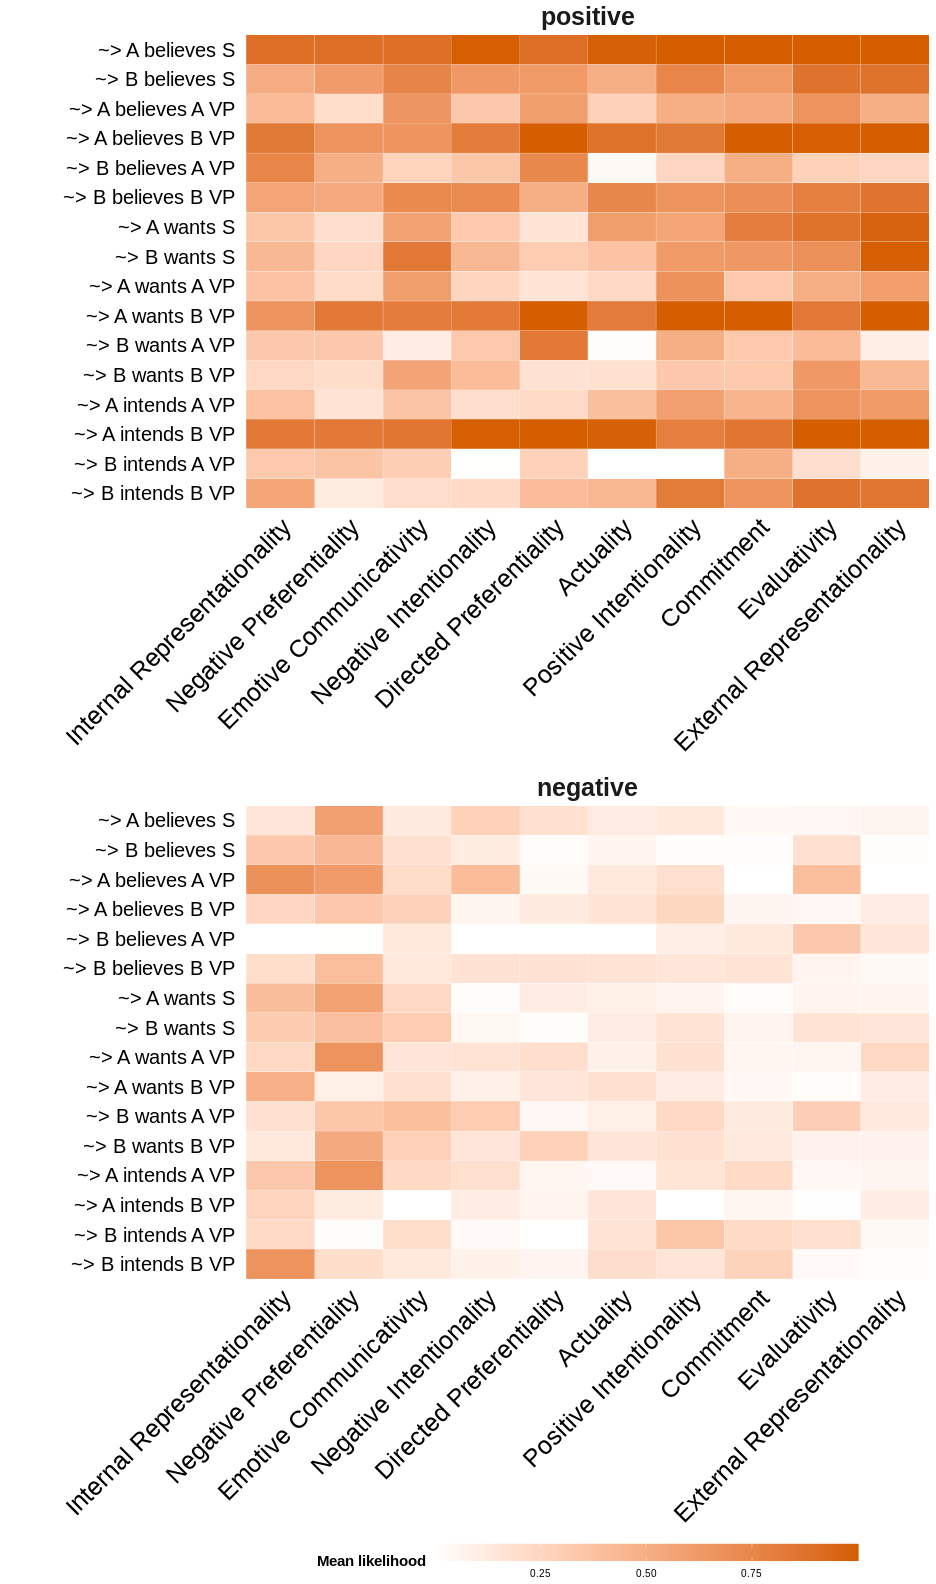

In [150]:
%%R -i belief_desire_component_loadings_mean_melt -i COMPONENT_ORDER_L -w 13 -h 22 -u in

library(tidyverse)

theme_set(theme_bw())

# best_belief_desire_means_melt <- filter(best_belief_desire_means_melt, inferencetype=='doxastic')
belief_desire_component_loadings_mean_melt$template <- ordered(belief_desire_component_loadings_mean_melt$template,
                                                 levels=rev(c(" ~> A believes S", " ~> B believes S", " ~> A believes A VP", " ~> A believes B VP", " ~> B believes A VP", " ~> B believes B VP",
                                                          " ~> A wants S",    " ~> B wants S",    " ~> A wants A VP",    " ~> A wants B VP",    " ~> B wants A VP",    " ~> B wants B VP",
                                                          " ~> A intends A VP", " ~> A intends B VP", " ~> B intends A VP", " ~> B intends B VP")))

belief_desire_component_loadings_mean_melt$variable <- ordered(belief_desire_component_loadings_mean_melt$variable,
                                                               levels=COMPONENT_ORDER_L)

belief_desire_component_loadings_mean_melt$polarity <- factor(belief_desire_component_loadings_mean_melt$polarity, levels=c("positive", "negative"))

g = ggplot(belief_desire_component_loadings_mean_melt, aes(y=template, x=variable, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     # breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     # labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5,
                     na.value = "transparent") +
facet_wrap(belief_desire_component_loadings_mean_melt$polarity,
           labeller = label_wrap_gen(width = 40, multi_line = TRUE),
           scales = "free",
           ncol=1) +
theme(axis.text=element_text(size=20, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(1, "lines"),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text=element_text(size=25, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(0,0,0,2),"cm")
)

ggsave('plots/component-intensional-loadings-means.pdf', width=13, height=22, limitsize=FALSE)
ggsave('plots/component-intensional-loadings-means.png', width=13, height=22, limitsize=FALSE)

g

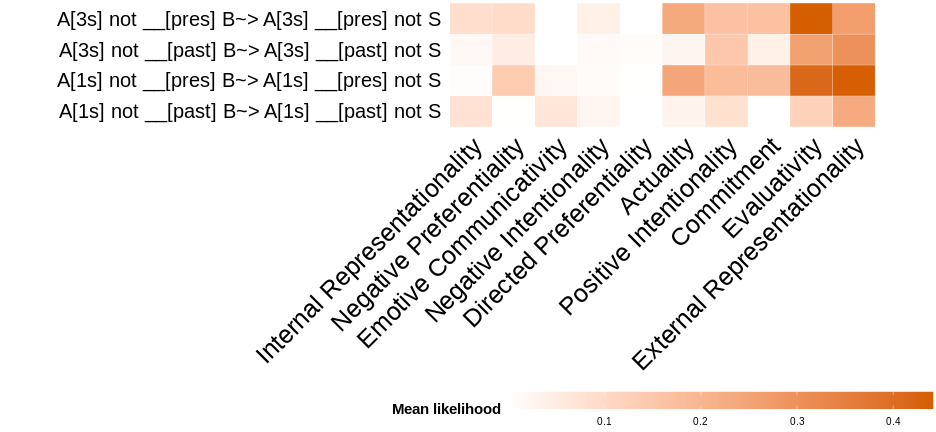

In [151]:
%%R -i negraising_component_loadings_mean_melt -i COMPONENT_ORDER_L -w 13 -h 6 -u in

library(tidyverse)

theme_set(theme_bw())

negraising_component_loadings_mean_melt$variable <- ordered(negraising_component_loadings_mean_melt$variable,
                                                            levels=COMPONENT_ORDER_L)

negraising_component_loadings_mean_melt$template <- factor(negraising_component_loadings_mean_melt$template)
negraising_component_loadings_mean_melt$tense <- factor(negraising_component_loadings_mean_melt$tense, levels=c("past", "present"))

g = ggplot(negraising_component_loadings_mean_melt, aes(y=template, x=variable, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     # breaks=c(-0.4, -0.2, 0, 0.2, 0.4),
                     # labels=c(-0.4, -0.2, 0, 0.2, 0.4)+0.5,
                     na.value = "transparent") +
theme(axis.text=element_text(size=20, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(1, "lines"),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text=element_text(size=25, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(0,2,0,2),"cm")
)

ggsave('plots/component-negraising-loadings-means.pdf', width=13, height=6, limitsize=FALSE)
ggsave('plots/component-negraising-loadings-means.png', width=13, height=6, limitsize=FALSE)

g

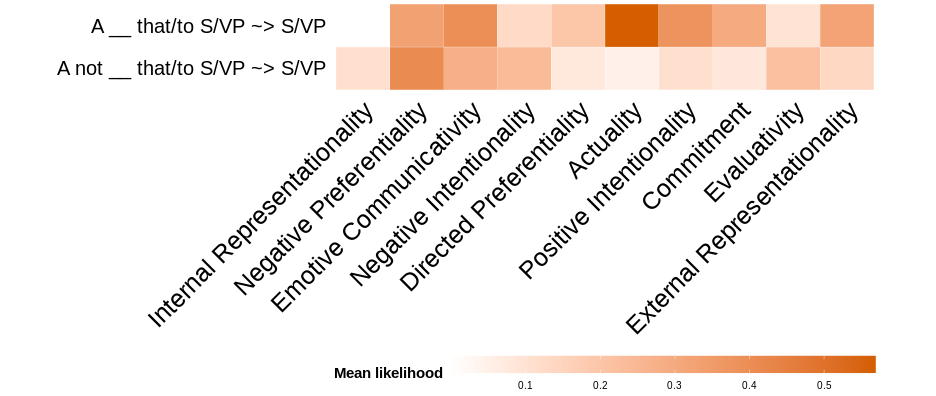

In [152]:
%%R -i veridicality_component_loadings_mean_melt -i COMPONENT_ORDER_L -w 13 -h 5.5 -u in

library(tidyverse)

theme_set(theme_bw())

veridicality_component_loadings_mean_melt$template <- ordered(veridicality_component_loadings_mean_melt$template,
                                                 levels=rev(c("A __ that/to S/VP ~> S/VP", "A not __ that/to S/VP ~> S/VP")))

veridicality_component_loadings_mean_melt$variable <- ordered(veridicality_component_loadings_mean_melt$variable,
                                                              levels=COMPONENT_ORDER_L)

veridicality_component_loadings_mean_melt$polarity <- factor(veridicality_component_loadings_mean_melt$polarity, levels=c("positive", "negative"))

g = ggplot(veridicality_component_loadings_mean_melt, aes(y=template, x=variable, fill=value)) +
geom_tile(color="white") +
scale_fill_gradient2(name='Mean likelihood', low="#0072B2", mid="white", high="#D55E00", 
                     # breaks=c(-0.4, -0.25, 0, 0.25, 0.4),
                     # labels=c(-0.4, -0.25, 0, 0.25, 0.4)+0.5,
                     na.value = "transparent") +
theme(axis.text=element_text(size=20, color="black"),
      axis.text.x=element_text(size=25, angle=45, hjust=1),
      axis.title=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=15, face="bold"),
      legend.text=element_text(size=10),
      legend.key.width=unit(3, "cm"),
      legend.position="bottom",
      panel.background=element_blank(),
      panel.border=element_blank(),
      panel.grid.major=element_blank(),
      panel.grid.minor=element_blank(),
      panel.spacing.x = unit(2, "lines"),
      panel.spacing.y = unit(1, "lines"),
      plot.background=element_blank(),
      strip.background=element_rect(fill="white", color="white"),
      strip.text=element_text(size=25, face="bold"),
      strip.clip = "off",
      plot.margin=unit(c(0,2,0,2),"cm")
)

ggsave('plots/component-veridicality-loadings-means.pdf', width=13, height=5.5, limitsize=FALSE)
ggsave('plots/component-veridicality-loadings-means.png', width=13, height=5.5, limitsize=FALSE)

g